## Modeling

### Model 0 (without Text Features)

#### Model Definition:

In [6]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [7]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(path):
        os.makedirs(path)
    fname = os.path.join(path, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [8]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

gen_print_model_stats(model_0_notext, os.path.join('logs', 'models', 'model_0_notext'), 'model_0_notext')

Model: "model_0_notext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_adj_daily_returns (InputLay [(None, 5)]          0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 5, 1)         0           log_adj_daily_returns[0][0]      
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 32)           4352        lambda[0][0]                     
__________________________________________________________________________________________________
docs (InputLayer)               [(None, None)]       0                                            
_____________________________________________________________________________________

Graph of Model:
![title](logs/models/model_0_notext/model_0_notext.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros', bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(inputs['log_adj_daily_returns'])}
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [4]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [5]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0_notext, baseline_model, batch_size=8, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if (feature_name == 'log_adj_daily_returns'):
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif (feature_name == 'docs'):
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on null features.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)
X_null = null_features(X)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 3s 21ms/sample - loss: 4.2745e-04
Epoch 2/100
128/128 [==============================] - 0s 101us/sample - loss: 4.0872e-04
Epoch 3/100
128/128 [==============================] - 0s 84us/sample - loss: 4.0768e-04
Epoch 4/100
128/128 [==============================] - 0s 104us/sample - loss: 4.0531e-04
Epoch 5/100
128/128 [==============================] - 0s 105us/sample - loss: 3.9986e-04
Epoch 6/100
128/128 [==============================] - 0s 110us/sample - loss: 4.0209e-04
Epoch 7/100
128/128 [==============================] - 0s 109us/sample - loss: 3.9890e-04
Epoch 8/100
128/128 [==============================] - 0s 95us/sample - loss: 4.0073e-04
Epoch 9/100
128/128 [==============================] - 0s 92us/sample - loss: 4.0064e-04
Epoch 10/100
128/128 [==============================] - 0s 108us/sample - loss: 3.9801e-04
Epoch 11/100
128/128 [==============================] - 0s 91us/sample - loss: 3.9

Epoch 91/100
128/128 [==============================] - 0s 93us/sample - loss: 4.0146e-04
Epoch 92/100
128/128 [==============================] - 0s 94us/sample - loss: 4.0286e-04
Epoch 93/100
128/128 [==============================] - 0s 91us/sample - loss: 4.0003e-04
Epoch 94/100
128/128 [==============================] - 0s 99us/sample - loss: 3.9854e-04
Epoch 95/100
128/128 [==============================] - 0s 104us/sample - loss: 3.9936e-04
Epoch 96/100
128/128 [==============================] - 0s 92us/sample - loss: 3.9876e-04
Epoch 97/100
128/128 [==============================] - 0s 107us/sample - loss: 3.9827e-04
Epoch 98/100
128/128 [==============================] - 0s 84us/sample - loss: 3.9905e-04
Epoch 99/100
128/128 [==============================] - 0s 100us/sample - loss: 3.9885e-04
Epoch 100/100
128/128 [==============================] - 0s 97us/sample - loss: 3.9865e-04


Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on zeroed features.

Loss for Model: 0.00042547193879727274


###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on actual data.

In [4]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 3s 21ms/sample - loss: 4.6100e-04
Epoch 2/100
128/128 [==============================] - 0s 98us/sample - loss: 4.3567e-04
Epoch 3/100
128/128 [==============================] - 0s 107us/sample - loss: 4.3054e-04
Epoch 4/100
128/128 [==============================] - 0s 129us/sample - loss: 4.2225e-04
Epoch 5/100
128/128 [==============================] - 0s 104us/sample - loss: 4.1501e-04
Epoch 6/100
128/128 [==============================] - 0s 112us/sample - loss: 4.1262e-04
Epoch 7/100
128/128 [==============================] - 0s 113us/sample - loss: 4.0373e-04
Epoch 8/100
128/128 [==============================] - 0s 111us/sample - loss: 4.0427e-04
Epoch 9/100
128/128 [==============================] - 0s 112us/sample - loss: 4.0029e-04
Epoch 10/100
128/128 [==============================] - 0s 118us/sample - loss: 3.9230e-04
Epoch 11/100
128/128 [==============================] - 0s 123us/sample - loss: 

Evaluating model.

In [5]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [6]:
print()
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))
print()


Metrics for model trained on actual data.

Loss for Model: 0.0003558132302714512



Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')


# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data

Plotting Error against Sample for Before Training, and After Training on the Small Dataset


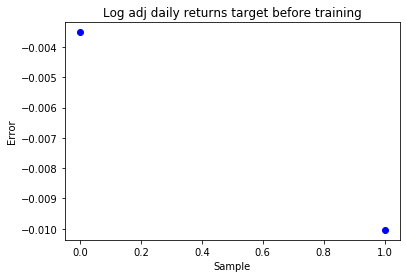

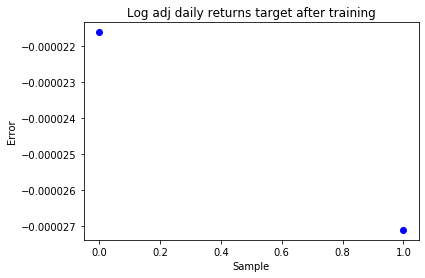


Plotting Each Sample's Time Series for Log Adjusted Daily Returns


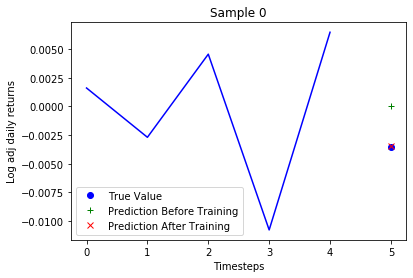

True Target Value: -0.0035051436379571754
Predicted Target Value Before Training: 7.341385753534269e-06
Predicted Target Value After Training: -0.00348352687433362




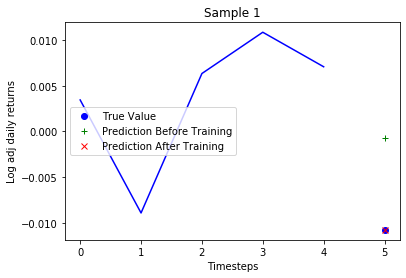

True Target Value: -0.010760221939794423
Predicted Target Value Before Training: -0.0007208752213045955
Predicted Target Value After Training: -0.010733124800026417




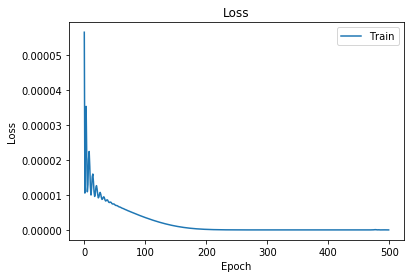

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
overfit_small_sample(model_0_notext, batch_size=2, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
visible_gpus = tf.config.experimental.get_visible_devices('GPU')
print('GPUs: {}'.format(gpus))
print('Visible GPUs: {}'.format(visible_gpus))
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

# Setting Tensorflow Seed
tf.random.set_seed(seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_dataset.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'test_dataset.pickle'), 'rb') as f:
    test_dataset = pickle.load(f)

# Loading Full Dataset
with open(os.path.join(path_to_data, 'dataset.pickle'), 'rb') as f:
    dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    target = targets['_'.join([ts_fname, 'target'])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([ts_fname, 'target']):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
        
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    
    return None

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {'log_adj_daily_returns': tf.keras.Input(shape=(5,), name='log_adj_daily_returns', dtype=tf.float32),
              'docs': tf.keras.Input(shape=(None,), name='docs', dtype=tf.int64)}
    reshape = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))(inputs['log_adj_daily_returns'])
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(reshape)
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target')
    outputs = {'log_adj_daily_returns_target': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Splitting train dataset into train and validation dataset.

In [4]:
train, val = split_dataset(train_dataset, train_size=0.75, random_state=seed)
X_train, y_train = train
X_val, y_val = val

print('Train set size: {}'.format(len(y_train['log_adj_daily_returns_target'])))
print('Validation set size: {}'.format(len(y_val['log_adj_daily_returns_target'])))
print('Test set size: {}'.format(len(test_dataset[1]['log_adj_daily_returns_target'])))

Train set size: 5557
Validation set size: 1853
Test set size: 2470


Training model.

In [5]:
batch_size = 64
epochs = 2

hparams = {'lstm_layer_units': 32, 'output_bias_init': 0}
m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS, callbacks=None)
m_history = m.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 5557 samples, validate on 1853 samples
Epoch 1/2
5557/5557 [==============================] - 4s 686us/sample - loss: 8.0353e-04 - val_loss: 7.8672e-04
Epoch 2/2
5557/5557 [==============================] - 1s 134us/sample - loss: 8.0176e-04 - val_loss: 7.7104e-04


Evaluating model.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
m_preds_train = m.predict(X_train)
m_preds_val = m.predict(X_val)
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_val = (m_preds_val[:, 0] > 0).astype(int)
labels_up_train = y_train['log_adj_daily_returns_target'] > 0
labels_up_val = y_val['log_adj_daily_returns_target'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


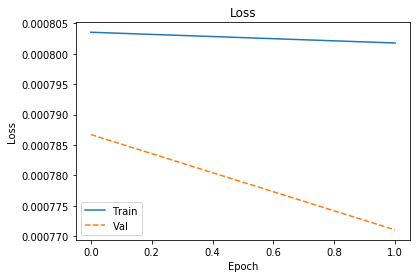

Loss on train dataset: 0.0007875599228051391
Loss on validation dataset: 0.0007710394982165113

Metrics for Classifying Upward Movements
Accuracy on train dataset: 0.4984703976965989
Accuracy on validation dataset: 0.5267134376686454


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))

# ADFADSFASFSAGSA

### Model 0 (without Text Features)

#### Model Definition:

In [9]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and Hardware
config_hardware(gpu_memory=None, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [10]:
def gen_print_model_stats(model, path, model_name):
    m = model()
    if not os.path.exists(path):
        os.makedirs(path)
    fname = os.path.join(path, model_name)
    tf.keras.utils.plot_model(m, fname + '.png', show_shapes=True, expand_nested=True)
    tf.keras.backend.clear_session()
    return m.summary()

In [11]:
def model_0_notext(lstm_layer_units=16, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(features)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, name='log_adj_daily_returns_target_WFC')
    
    outputs = {'log_adj_daily_returns_target_WFC': output_layer(lstm)}
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

gen_print_model_stats(model_0_notext, 'pics', 'model_0_notext')

Model: "model_0_notext"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_adj_daily_returns_WFC (Inpu [(None, 5)]          0                                            
__________________________________________________________________________________________________
log_adj_daily_returns_JPM (Inpu [(None, 5)]          0                                            
__________________________________________________________________________________________________
log_adj_daily_returns_BAC (Inpu [(None, 5)]          0                                            
__________________________________________________________________________________________________
log_adj_daily_returns_C (InputL [(None, 5)]          0                                            
_____________________________________________________________________________________

Graph of Model:
![title](pics/model_0_notext.png)

#### Unit Testing Model

##### 1. Testing if when initialized properly, the model is equivalent to the baseline model.

Restart kernel in order to fully clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and Hardware
config_hardware(gpu_memory=None, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def baseline_model(output_bias_init=0):
    
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64)
             }
    
    features = tf.keras.layers.Concatenate()([inputs[fname] for fname in inputs.keys() if '8-k' not in fname])
    
    output_layer = tf.keras.layers.Dense(1, kernel_initializer='zeros',
                                         bias_initializer=output_bias_init,
                                         name='log_adj_daily_returns_target_WFC')
    
    outputs = {
               'log_adj_daily_returns_target_WFC': output_layer(features), 
              }
    
    model = tf.keras.Model(inputs, outputs, name='baseline_model')
    
    return model

Defining model.

In [5]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(features)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target_WFC')
    
    outputs = {
               'log_adj_daily_returns_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Testing baseline equivalence of model when initialized properly.

In [6]:
def test_baseline_equivalence(model, baseline_model, batch_size, X, y):
    print('Testing if the untrained model when initialized properly is equivalent to the baseline model')
    output_bias_init = 0
    
    baseline_m = build_compiled_model(baseline_model, {'output_bias_init': output_bias_init},
                                      loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    baseline_results = baseline_m.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    hparams = {'output_kernel_init': 'zeros', 'output_bias_init': output_bias_init}
    m1 = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m1_results = m1.evaluate(X, y, batch_size=batch_size, verbose=0)
    
    assert m1_results == baseline_results
    
    return print('Passed')

In [7]:
X, y = sample_dataset(train_dataset, sample_size=16, seed=seed)
test_baseline_equivalence(model_0_notext, baseline_model, batch_size=8, X=X, y=y)

Testing if the untrained model when initialized properly is equivalent to the baseline model
Passed


##### 2. Testing if the model trained on real data performs better than the model trained on null data.

###### Using Null Data.

Restart kernel to clear GPU memory.

In [8]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and Hardware
config_hardware(gpu_memory=None, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [13]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def null_feature(feature_name, feature):
    if 'log_adj_daily_returns' in feature_name:
        null_feature = np.zeros(shape=feature.shape, dtype=feature.dtype)
    elif '8-k' in feature_name:
        null_feature = np.ones(shape=feature.shape, dtype=feature.dtype)
    return null_feature

def null_features(features):
    return {fname: null_feature(fname, features[fname]) for fname in features.keys()}

Defining model.

In [14]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(features)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target_WFC')
    
    outputs = {
               'log_adj_daily_returns_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on null features.

In [15]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)
X_null = null_features(X)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X_null, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 2s 12ms/sample - loss: 9.9765e-04
Epoch 2/100
128/128 [==============================] - 0s 172us/sample - loss: 9.7545e-04
Epoch 3/100
128/128 [==============================] - 0s 157us/sample - loss: 9.7351e-04
Epoch 4/100
128/128 [==============================] - 0s 184us/sample - loss: 9.5387e-04
Epoch 5/100
128/128 [==============================] - 0s 179us/sample - loss: 9.6344e-04
Epoch 6/100
128/128 [==============================] - 0s 197us/sample - loss: 9.6501e-04
Epoch 7/100
128/128 [==============================] - 0s 201us/sample - loss: 9.6252e-04
Epoch 8/100
128/128 [==============================] - 0s 196us/sample - loss: 9.6730e-04
Epoch 9/100
128/128 [==============================] - 0s 201us/sample - loss: 9.6350e-04
Epoch 10/100
128/128 [==============================] - 0s 202us/sample - loss: 9.5699e-04
Epoch 11/100
128/128 [==============================] - 0s 173us/sample - loss:

Epoch 91/100
128/128 [==============================] - 0s 197us/sample - loss: 9.5927e-04
Epoch 92/100
128/128 [==============================] - 0s 180us/sample - loss: 9.5735e-04
Epoch 93/100
128/128 [==============================] - 0s 174us/sample - loss: 9.5690e-04
Epoch 94/100
128/128 [==============================] - 0s 163us/sample - loss: 9.5721e-04
Epoch 95/100
128/128 [==============================] - 0s 182us/sample - loss: 9.5928e-04
Epoch 96/100
128/128 [==============================] - 0s 158us/sample - loss: 9.6050e-04
Epoch 97/100
128/128 [==============================] - 0s 150us/sample - loss: 9.5732e-04
Epoch 98/100
128/128 [==============================] - 0s 175us/sample - loss: 9.5830e-04
Epoch 99/100
128/128 [==============================] - 0s 179us/sample - loss: 9.5702e-04
Epoch 100/100
128/128 [==============================] - 0s 171us/sample - loss: 9.5909e-04


Evaluating model.

In [16]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [17]:
print('Metrics for model trained on zeroed features.')
print()
print('Loss for Model: {}'.format(m_results))

Metrics for model trained on zeroed features.

Loss for Model: 0.0009414300438947976


###### Using Real data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and Hardware
config_hardware(gpu_memory=None, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [5]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

Defining model.

In [6]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(features)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target_WFC')
    
    outputs = {
               'log_adj_daily_returns_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Training model on actual data.

In [7]:
X, y = sample_dataset(train_dataset, sample_size=128, seed=seed)

epochs = 100
batch_size = 64
output_bias_init = 0
hparams = {'output_bias_init': output_bias_init}


m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
m_history = m.fit(X, y, batch_size=batch_size, epochs=epochs)

Train on 128 samples
Epoch 1/100
128/128 [==============================] - 1s 11ms/sample - loss: 9.7149e-04
Epoch 2/100
128/128 [==============================] - 0s 179us/sample - loss: 9.4664e-04
Epoch 3/100
128/128 [==============================] - 0s 157us/sample - loss: 9.3046e-04
Epoch 4/100
128/128 [==============================] - 0s 187us/sample - loss: 9.0190e-04
Epoch 5/100
128/128 [==============================] - 0s 189us/sample - loss: 9.0815e-04
Epoch 6/100
128/128 [==============================] - 0s 168us/sample - loss: 8.9705e-04
Epoch 7/100
128/128 [==============================] - 0s 171us/sample - loss: 8.8841e-04
Epoch 8/100
128/128 [==============================] - 0s 181us/sample - loss: 8.8840e-04
Epoch 9/100
128/128 [==============================] - 0s 181us/sample - loss: 8.7541e-04
Epoch 10/100
128/128 [==============================] - 0s 162us/sample - loss: 8.6296e-04
Epoch 11/100
128/128 [==============================] - 0s 188us/sample - loss:

Epoch 91/100
128/128 [==============================] - 0s 189us/sample - loss: 7.1337e-04
Epoch 92/100
128/128 [==============================] - 0s 184us/sample - loss: 7.1055e-04
Epoch 93/100
128/128 [==============================] - 0s 154us/sample - loss: 7.1100e-04
Epoch 94/100
128/128 [==============================] - 0s 208us/sample - loss: 7.0929e-04
Epoch 95/100
128/128 [==============================] - 0s 185us/sample - loss: 7.0966e-04
Epoch 96/100
128/128 [==============================] - 0s 205us/sample - loss: 7.0465e-04
Epoch 97/100
128/128 [==============================] - 0s 162us/sample - loss: 7.0179e-04
Epoch 98/100
128/128 [==============================] - 0s 224us/sample - loss: 6.9884e-04
Epoch 99/100
128/128 [==============================] - 0s 184us/sample - loss: 6.9654e-04
Epoch 100/100
128/128 [==============================] - 0s 172us/sample - loss: 6.9632e-04


Evaluating model.

In [8]:
m_results = m.evaluate(X, y, batch_size=batch_size, verbose=0)

In [9]:
print()
print('Metrics for model trained on actual data.')
print()
print('Loss for Model: {}'.format(m_results))
print()


Metrics for model trained on actual data.

Loss for Model: 0.0006934269622433931



Checks out. The model when trained on actual data has a smaller loss than when trained on the null features.

##### 3. Testing if the model can overfit on a small sample of data.

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = 42

# Configuring GPU and Hardware
config_hardware(gpu_memory=None, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: []
Visible GPUs: []


In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(dataset, train_size=None, test_size=None, random_state=None, shuffle=True):
    features = dataset[0]
    targets = dataset[1]
    feature_keys = list(features.keys())
    feature_arrays = [features[k] for k in feature_keys]
    target_keys = list(targets.keys())
    target_arrays = [targets[k] for k in target_keys]
    keys = feature_keys + target_keys
    arrays = feature_arrays + target_arrays
    array_splits = train_test_split(*arrays, train_size=train_size, test_size=test_size,
                                    random_state=random_state, shuffle=shuffle)
    train = {keys[i]: array_splits[2*i] for i in range(len(keys))}
    train_features = {k: train[k] for k in feature_keys}
    train_targets = {k: train[k] for k in target_keys}
    
    test = {keys[i]: array_splits[(2*i + 1)] for i in range(len(keys))}
    test_features = {k: test[k] for k in feature_keys}
    test_targets = {k: test[k] for k in target_keys}
    
    train_dataset = (train_features, train_targets)
    test_dataset = (test_features, test_targets)
    
    return train_dataset, test_dataset

def sample_dataset(dataset, sample_size, seed=None):
    if (isinstance(sample_size, float) and (sample_size == 1)) or (isinstance(sample_size, int) and sample_size == len(dataset[1][next(iter(dataset[1].keys()))])):
        ds = dataset
    else:
        ds, not_ds = split_dataset(dataset, train_size=sample_size, random_state=seed)
    return ds

def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

Defining model.

In [3]:
def model_0_notext(lstm_layer_units=32, output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'log_adj_daily_returns_WFC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'log_adj_daily_returns_JPM': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'log_adj_daily_returns_BAC': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'log_adj_daily_returns_C': tf.keras.Input(shape=(5,), name='log_adj_daily_returns_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=lstm_layer_units)(features)
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='log_adj_daily_returns_target_WFC')
    
    outputs = {
               'log_adj_daily_returns_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Overtraining model on a small sample of the data.

In [4]:
def overfit_small_sample(model, batch_size, epochs, X_small, y_small, verbose):
    print('Testing if model can overfit on a small sample of data')
    output_bias_init = 0
    hparams = {'output_bias_init': output_bias_init}
    
    m = build_compiled_model(model, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    m_pred_untrained = m.predict(X_small, batch_size=batch_size)
    m_history = m.fit(X_small, y_small, batch_size=batch_size, epochs=epochs, verbose=verbose)
    m_pred_trained = m.predict(X_small, batch_size=batch_size)
    print()
    
    print('Plotting Error against Sample for Before Training, and After Training on the Small Dataset')
    plot_outputs_errors(m_pred_untrained, y_small, 'Before Training')
    plot_outputs_errors(m_pred_trained, y_small, 'After Training')
    print()
    
    print('Plotting Each Sample\'s Time Series for Log Adjusted Daily Returns')
    plot_ts_samples_ba(X_small, y_small, m_pred_untrained, m_pred_trained, 'log_adj_daily_returns_WFC')
    
    metrics = ['loss'] + list(map(lambda met: met.name, METRICS))
    for met in metrics:
        plot_metric(m_history, metric=met)
        
    return None

Testing if model can overfit on a small sample of data

Plotting Error against Sample for Before Training, and After Training on the Small Dataset


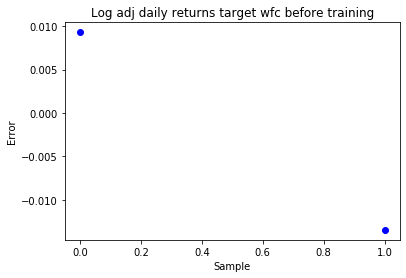

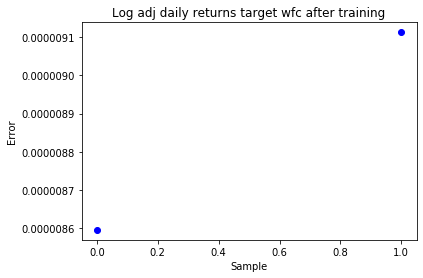


Plotting Each Sample's Time Series for Log Adjusted Daily Returns


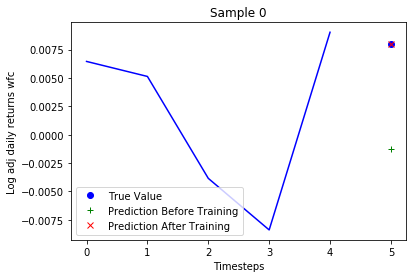

True Target Value: 0.008001144017601103
Predicted Target Value Before Training: -0.0012983159394934773
Predicted Target Value After Training: 0.007992547936737537




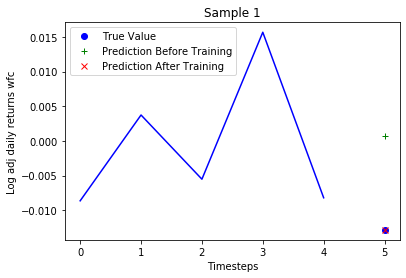

True Target Value: -0.01281384994068091
Predicted Target Value Before Training: 0.0006703478866256773
Predicted Target Value After Training: -0.012822962366044521




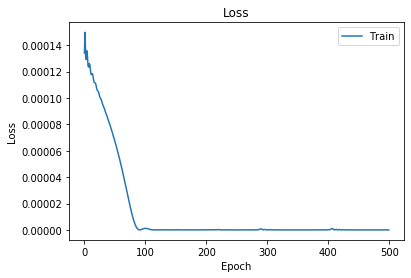

In [5]:
X_small, y_small = sample_dataset(train_dataset, sample_size=2, seed=seed)
# Stripping Extraneous Labels
del y_small['log_adj_daily_returns_target_JPM']
del y_small['log_adj_daily_returns_target_BAC']
del y_small['log_adj_daily_returns_target_C']
overfit_small_sample(model_0_notext, batch_size=2, epochs=500, X_small=X_small, y_small=y_small, verbose=0)

From the above plots its clear that our model has overfit on our small sample of the dataset which is the desired behavior.

#### Evaluating Model:

Restart kernel to clear GPU memory.

In [1]:
# Importing Libraries and Configuring virtual GPU

import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from stockanalysis.train import config_hardware

# Project Paths
project_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
path_to_data = os.path.join(project_dir, 'data')
path_to_docs = os.path.join(path_to_data, 'documents')
path_to_models = os.path.join(project_dir, 'models')

# Random Seed
seed = None

# Configuring GPU and Hardware
config_hardware(gpu_memory=3000, seed=seed)

# Loading Train Dataset
with open(os.path.join(path_to_data, 'train_datasetp2.pickle'), 'rb') as f:
    train_dataset = pickle.load(f)

# Loading Test Dataset
with open(os.path.join(path_to_data, 'val_datasetp2.pickle'), 'rb') as f:
    val_dataset = pickle.load(f)
    
# Defining Helper Functions    
def build_compiled_model(build_model, hparams, loss, optimizer, metrics, callbacks=None):
    model = build_model(**hparams)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, callbacks=callbacks)
    return model

# Model Agnostic Parameters
LOSS = tf.keras.losses.MeanSquaredError()
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00001)
METRICS = []
CALLBACKS = None
with open(os.path.join(path_to_data, 'vocab_8k_norm_trainp2_WFC_JPM_BAC_C.json'), 'r') as f:
    vocab = json.load(f)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
def plot_errors(predictions, true_labels, title):
    fig, ax = plt.subplots()
    err = true_labels - predictions
    ax.plot(err, 'bo')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Error')
    ax.set_title(title)
    plt.show()
    return None

def plot_outputs_errors(predictions, true_labels, title):
    for i in range(len(true_labels.keys())):
        label_name = list(true_labels.keys())[i]
        labels = true_labels[label_name]
        preds = predictions[:, i]
        assert len(preds) == len(labels)
        name = '_'.join([label_name, title]).replace("_"," ").capitalize()
        plot_errors(preds, labels, name)
    return None

def plot_ts_sample_ba(feature_value, target_value, prediction_b_value, prediction_a_value, ts_fname, sample_num):
    name = ts_fname.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(feature_value, '-b')
    ax.plot(len(feature_value), target_value, 'bo', label='True Value')
    ax.plot(len(feature_value), prediction_b_value, 'g+', label='Prediction Before Training')
    ax.plot(len(feature_value), prediction_a_value, 'rx', label='Prediction After Training')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel(name)
    ax.set_title('Sample {}'.format(sample_num))
    ax.legend()
    plt.show()
    print('True Target Value: {}'.format(target_value))
    print('Predicted Target Value Before Training: {}'.format(prediction_b_value))
    print('Predicted Target Value After Training: {}'.format(prediction_a_value))
    print()
    print()
    return None

def plot_ts_samples_ba(features, targets, predictions_b, predictions_a, ts_fname):
    feature = features[ts_fname]
    name = ts_fname.split('_')
    ticker = name.pop()
    name = '_'.join(name)
    target = targets['_'.join([name, 'target', ticker])]
    prediction_b = None
    prediction_a = None
    for i in range(len(targets.keys())):
        target_name = list(targets.keys())[i]
        if target_name == '_'.join([name, 'target', ticker]):
            prediction_b = predictions_b[:, i]
            prediction_a = predictions_a[:, i]
    assert len(prediction_b) == len(prediction_a) == len(target) == len(feature)
    
    for i in range(len(target)):
        plot_ts_sample_ba(feature[i], target[i], prediction_b[i], prediction_a[i], ts_fname, i)
    return None
            
def plot_metric(history, metric):
    name = metric.replace("_"," ").capitalize()
    fig, ax = plt.subplots()
    ax.plot(history.history[metric], label='Train')
    if 'val_' + metric in history.history:
        ax.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    ax.set_title(name)
    ax.legend()
    plt.show()
    return None

def print_metric(metrics_values, metric_idx, name):
    if isinstance(metrics_values, list):
        metric_val = metrics_values[metric_idx]
    else: 
        metric_val = metrics_values
    return print(name.format(metric_val))
    
def plot_print_metrics(history, metrics_train, metrics_val, metrics_names):
    for metric_idx, metric_name in enumerate(metrics_names):
        plot_metric(history, metric_name)
        name_train = metric_name.replace('_', ' ').capitalize() + ' on train dataset: {}'
        print_metric(metrics_train, metric_idx, name_train)
        name_val = metric_name.replace('_', ' ').capitalize() + ' on validation dataset: {}'
        print_metric(metrics_val, metric_idx, name_val)
    return None

Defining model.

In [3]:
def model_0_notext(output_kernel_init=None, output_bias_init=None):
    if output_bias_init is not None:
        output_bias_init = tf.keras.initializers.Constant(output_bias_init)
        
    inputs = {
              'adjusted_close_WFC': tf.keras.Input(shape=(5,), name='adjusted_close_WFC', dtype=tf.float32),
              '8-k_WFC': tf.keras.Input(shape=(None,), name='8-k_WFC', dtype=tf.int64),
              'adjusted_close_JPM': tf.keras.Input(shape=(5,), name='adjusted_close_JPM', dtype=tf.float32),
              '8-k_JPM': tf.keras.Input(shape=(None,), name='8-k_JPM', dtype=tf.int64),
              'adjusted_close_BAC': tf.keras.Input(shape=(5,), name='adjusted_close_BAC', dtype=tf.float32),
              '8-k_BAC': tf.keras.Input(shape=(None,), name='8-k_BAC', dtype=tf.int64),
              'adjusted_close_C': tf.keras.Input(shape=(5,), name='adjusted_close_C', dtype=tf.float32),
              '8-k_C': tf.keras.Input(shape=(None,), name='8-k_C', dtype=tf.int64),
             }
    
    reshape_layer = tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x, axis=-1))
    reshaped = [reshape_layer(inputs[fname]) for fname in inputs.keys() if '8-k' not in fname]
    
    features = tf.keras.layers.Concatenate()(reshaped)
    
    lstm = tf.keras.layers.LSTM(units=16)(features) # with less capacity, 16 units, able to gain val loss of 1.51-50ish and see that val loss decreases model definitely is prone to overfitting
    
    output_layer = tf.keras.layers.Dense(units=1, kernel_initializer=output_kernel_init,
                                         bias_initializer=output_bias_init, 
                                         name='adjusted_close_target_WFC')
    
    outputs = {
               'adjusted_close_target_WFC': output_layer(lstm)
              }
    
    model = tf.keras.Model(inputs, outputs, name='model_0_notext')
    
    return model

Examining our train and validation dataset.

In [4]:
X_train, y_train = train_dataset
X_val, y_val = val_dataset

print('Train set size: {}'.format(len(y_train['adjusted_close_target_WFC'])))
print('Validation set size: {}'.format(len(y_val['adjusted_close_target_WFC'])))

Train set size: 3014
Validation set size: 1001


Training model.

In [5]:
batch_size = 256
epochs = 30000

hparams = {'output_bias_init': 0}
m = build_compiled_model(model_0_notext, hparams, loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS, callbacks=None)
m_history = m.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Train on 3014 samples, validate on 1001 samples
Epoch 1/30000
3014/3014 [==============================] - 3s 1ms/sample - loss: 406.7877 - val_loss: 1432.3099
Epoch 2/30000
3014/3014 [==============================] - 0s 126us/sample - loss: 406.7176 - val_loss: 1432.2061
Epoch 3/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 406.6452 - val_loss: 1432.1018
Epoch 4/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 406.5707 - val_loss: 1431.9986
Epoch 5/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 406.4934 - val_loss: 1431.8956
Epoch 6/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 406.4129 - val_loss: 1431.7930
Epoch 7/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 406.3290 - val_loss: 1431.6912
Epoch 8/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 406.2425 - val_loss: 1431.5887
Epoch 9/30000
3014/3014 [=================

Epoch 72/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 398.0806 - val_loss: 1425.4671
Epoch 73/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 397.9022 - val_loss: 1425.3672
Epoch 74/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 397.7198 - val_loss: 1425.2655
Epoch 75/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 397.5325 - val_loss: 1425.1638
Epoch 76/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 397.3406 - val_loss: 1425.0622
Epoch 77/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 397.1421 - val_loss: 1424.9600
Epoch 78/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 396.9411 - val_loss: 1424.8560
Epoch 79/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 396.7332 - val_loss: 1424.7509
Epoch 80/30000
3014/3014 [==============================] - 0s 152us/sample - lo

Epoch 143/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 384.3221 - val_loss: 1415.0818
Epoch 144/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 384.2132 - val_loss: 1414.8628
Epoch 145/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 384.1076 - val_loss: 1414.6409
Epoch 146/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 384.0013 - val_loss: 1414.4206
Epoch 147/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 383.8978 - val_loss: 1414.1920
Epoch 148/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 383.7932 - val_loss: 1413.9632
Epoch 149/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 383.6896 - val_loss: 1413.7320
Epoch 150/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 383.5875 - val_loss: 1413.4953
Epoch 151/30000
3014/3014 [==============================] - 0s 148us/sa

3014/3014 [==============================] - 0s 142us/sample - loss: 353.8783 - val_loss: 1392.1978
Epoch 214/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 352.7537 - val_loss: 1391.7591
Epoch 215/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 351.4535 - val_loss: 1391.3161
Epoch 216/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 350.0460 - val_loss: 1390.8700
Epoch 217/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 348.5918 - val_loss: 1390.4265
Epoch 218/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 347.2232 - val_loss: 1389.9821
Epoch 219/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 345.9984 - val_loss: 1389.5336
Epoch 220/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 344.9349 - val_loss: 1389.0859
Epoch 221/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 344

Epoch 284/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 328.7162 - val_loss: 1358.3688
Epoch 285/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 328.6110 - val_loss: 1357.8856
Epoch 286/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 328.5070 - val_loss: 1357.4003
Epoch 287/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 328.4027 - val_loss: 1356.9252
Epoch 288/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 328.3014 - val_loss: 1356.4411
Epoch 289/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 328.1999 - val_loss: 1355.9641
Epoch 290/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 328.1001 - val_loss: 1355.4874
Epoch 291/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 328.0006 - val_loss: 1355.0111
Epoch 292/30000
3014/3014 [==============================] - 0s 152us/sa

3014/3014 [==============================] - 0s 148us/sample - loss: 322.6390 - val_loss: 1324.8457
Epoch 355/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 322.5598 - val_loss: 1324.3211
Epoch 356/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 322.4802 - val_loss: 1323.7889
Epoch 357/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 322.4003 - val_loss: 1323.2591
Epoch 358/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 322.3211 - val_loss: 1322.7196
Epoch 359/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 322.2413 - val_loss: 1322.1856
Epoch 360/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 322.1614 - val_loss: 1321.6500
Epoch 361/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 322.0826 - val_loss: 1321.1108
Epoch 362/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 322

Epoch 425/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 316.4153 - val_loss: 1286.9134
Epoch 426/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 316.3084 - val_loss: 1286.3314
Epoch 427/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 316.2010 - val_loss: 1285.7502
Epoch 428/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 316.0948 - val_loss: 1285.1594
Epoch 429/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 315.9862 - val_loss: 1284.5651
Epoch 430/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 315.8777 - val_loss: 1283.9702
Epoch 431/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 315.7685 - val_loss: 1283.3702
Epoch 432/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 315.6589 - val_loss: 1282.7610
Epoch 433/30000
3014/3014 [==============================] - 0s 158us/sa

3014/3014 [==============================] - 0s 148us/sample - loss: 307.7111 - val_loss: 1238.5676
Epoch 496/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 307.5609 - val_loss: 1237.8669
Epoch 497/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 307.4090 - val_loss: 1237.1650
Epoch 498/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 307.2557 - val_loss: 1236.4571
Epoch 499/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 307.0984 - val_loss: 1235.7629
Epoch 500/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 306.9396 - val_loss: 1235.0688
Epoch 501/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 306.7784 - val_loss: 1234.3787
Epoch 502/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 306.6148 - val_loss: 1233.6885
Epoch 503/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 306

Epoch 566/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 286.7946 - val_loss: 1187.4703
Epoch 567/30000
3014/3014 [==============================] - 1s 192us/sample - loss: 286.5886 - val_loss: 1186.7131
Epoch 568/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 286.3826 - val_loss: 1185.9477
Epoch 569/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 286.1741 - val_loss: 1185.1962
Epoch 570/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 285.9642 - val_loss: 1184.4414
Epoch 571/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 285.7502 - val_loss: 1183.6929
Epoch 572/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 285.5330 - val_loss: 1182.9427
Epoch 573/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 285.3104 - val_loss: 1182.1840
Epoch 574/30000
3014/3014 [==============================] - 0s 157us/sa

3014/3014 [==============================] - 0s 149us/sample - loss: 267.7065 - val_loss: 1143.1697
Epoch 637/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 267.5984 - val_loss: 1142.6709
Epoch 638/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 267.4913 - val_loss: 1142.1771
Epoch 639/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 267.3857 - val_loss: 1141.6781
Epoch 640/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 267.2805 - val_loss: 1141.1912
Epoch 641/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 267.1773 - val_loss: 1140.7032
Epoch 642/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 267.0754 - val_loss: 1140.2075
Epoch 643/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 266.9736 - val_loss: 1139.7241
Epoch 644/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 266

Epoch 707/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 261.6402 - val_loss: 1108.6253
Epoch 708/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 261.5636 - val_loss: 1108.1104
Epoch 709/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 261.4877 - val_loss: 1107.5873
Epoch 710/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 261.4110 - val_loss: 1107.0688
Epoch 711/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 261.3341 - val_loss: 1106.5514
Epoch 712/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 261.2579 - val_loss: 1106.0249
Epoch 713/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 261.1815 - val_loss: 1105.4932
Epoch 714/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 261.1038 - val_loss: 1104.9653
Epoch 715/30000
3014/3014 [==============================] - 0s 152us/sa

3014/3014 [==============================] - 0s 138us/sample - loss: 255.1320 - val_loss: 1071.6707
Epoch 778/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 255.0084 - val_loss: 1071.2545
Epoch 779/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 254.8811 - val_loss: 1070.8405
Epoch 780/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 254.7494 - val_loss: 1070.4301
Epoch 781/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 254.6122 - val_loss: 1070.0221
Epoch 782/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 254.4697 - val_loss: 1069.6181
Epoch 783/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 254.3198 - val_loss: 1069.2141
Epoch 784/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 254.1641 - val_loss: 1068.8140
Epoch 785/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 253

Epoch 848/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 239.3178 - val_loss: 1041.5277
Epoch 849/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 239.2136 - val_loss: 1041.1584
Epoch 850/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 239.1067 - val_loss: 1040.7896
Epoch 851/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 238.9947 - val_loss: 1040.4296
Epoch 852/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 238.8807 - val_loss: 1040.0763
Epoch 853/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 238.7604 - val_loss: 1039.7256
Epoch 854/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 238.6338 - val_loss: 1039.3801
Epoch 855/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 238.4991 - val_loss: 1039.0414
Epoch 856/30000
3014/3014 [==============================] - 0s 150us/sa

3014/3014 [==============================] - 0s 149us/sample - loss: 221.7065 - val_loss: 1023.9490
Epoch 919/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 221.6095 - val_loss: 1023.7727
Epoch 920/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 221.5152 - val_loss: 1023.5954
Epoch 921/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 221.4238 - val_loss: 1023.4189
Epoch 922/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 221.3346 - val_loss: 1023.2450
Epoch 923/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 221.2476 - val_loss: 1023.0741
Epoch 924/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 221.1624 - val_loss: 1022.9016
Epoch 925/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 221.0789 - val_loss: 1022.7302
Epoch 926/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 220

Epoch 989/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 214.8709 - val_loss: 1013.1302
Epoch 990/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 214.6268 - val_loss: 1012.9909
Epoch 991/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 214.3883 - val_loss: 1012.8527
Epoch 992/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 214.1559 - val_loss: 1012.7138
Epoch 993/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 213.9327 - val_loss: 1012.5756
Epoch 994/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 213.7153 - val_loss: 1012.4370
Epoch 995/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 213.5118 - val_loss: 1012.2995
Epoch 996/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 213.3140 - val_loss: 1012.1611
Epoch 997/30000
3014/3014 [==============================] - 0s 160us/sa

3014/3014 [==============================] - 0s 149us/sample - loss: 207.4007 - val_loss: 1003.8621
Epoch 1060/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 207.3388 - val_loss: 1003.7338
Epoch 1061/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 207.2777 - val_loss: 1003.6040
Epoch 1062/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 207.2163 - val_loss: 1003.4752
Epoch 1063/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 207.1553 - val_loss: 1003.3466
Epoch 1064/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 207.0946 - val_loss: 1003.2173
Epoch 1065/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 207.0343 - val_loss: 1003.0876
Epoch 1066/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 206.9737 - val_loss: 1002.9585
Epoch 1067/30000
3014/3014 [==============================] - 0s 145us/sample - l

3014/3014 [==============================] - 0s 152us/sample - loss: 202.9835 - val_loss: 993.8532
Epoch 1130/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 202.9058 - val_loss: 993.6799
Epoch 1131/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 202.8288 - val_loss: 993.5012
Epoch 1132/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 202.7490 - val_loss: 993.3245
Epoch 1133/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 202.6702 - val_loss: 993.1445
Epoch 1134/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 202.5902 - val_loss: 992.9631
Epoch 1135/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 202.5086 - val_loss: 992.7805
Epoch 1136/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 202.4274 - val_loss: 992.5944
Epoch 1137/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 202

Epoch 1200/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 196.7508 - val_loss: 976.5678
Epoch 1201/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 196.6697 - val_loss: 976.2632
Epoch 1202/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 196.5890 - val_loss: 975.9543
Epoch 1203/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 196.5090 - val_loss: 975.6445
Epoch 1204/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 196.4299 - val_loss: 975.3308
Epoch 1205/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 196.3518 - val_loss: 975.0174
Epoch 1206/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 196.2727 - val_loss: 974.7040
Epoch 1207/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 196.1953 - val_loss: 974.3911
Epoch 1208/30000
3014/3014 [==============================] - 0s 156us/s

3014/3014 [==============================] - 0s 142us/sample - loss: 191.8937 - val_loss: 955.0675
Epoch 1271/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 191.8175 - val_loss: 954.7901
Epoch 1272/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 191.7398 - val_loss: 954.5124
Epoch 1273/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 191.6584 - val_loss: 954.2356
Epoch 1274/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 191.5742 - val_loss: 953.9567
Epoch 1275/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 191.4863 - val_loss: 953.6859
Epoch 1276/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 191.3925 - val_loss: 953.4155
Epoch 1277/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 191.2933 - val_loss: 953.1397
Epoch 1278/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 191

Epoch 1341/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 179.4256 - val_loss: 937.4111
Epoch 1342/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 179.3597 - val_loss: 937.1849
Epoch 1343/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 179.2947 - val_loss: 936.9569
Epoch 1344/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 179.2293 - val_loss: 936.7284
Epoch 1345/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 179.1644 - val_loss: 936.5004
Epoch 1346/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 179.0996 - val_loss: 936.2726
Epoch 1347/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 179.0347 - val_loss: 936.0455
Epoch 1348/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 178.9700 - val_loss: 935.8190
Epoch 1349/30000
3014/3014 [==============================] - 0s 147us/s

3014/3014 [==============================] - 0s 141us/sample - loss: 171.9709 - val_loss: 921.6929
Epoch 1412/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 171.8865 - val_loss: 921.4780
Epoch 1413/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 171.8029 - val_loss: 921.2634
Epoch 1414/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 171.7204 - val_loss: 921.0504
Epoch 1415/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 171.6389 - val_loss: 920.8360
Epoch 1416/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 171.5580 - val_loss: 920.6260
Epoch 1417/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 171.4785 - val_loss: 920.4123
Epoch 1418/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 171.3990 - val_loss: 920.2012
Epoch 1419/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 171

Epoch 1482/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 166.8254 - val_loss: 908.1085
Epoch 1483/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 166.7639 - val_loss: 907.9350
Epoch 1484/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 166.7029 - val_loss: 907.7606
Epoch 1485/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 166.6423 - val_loss: 907.5860
Epoch 1486/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 166.5820 - val_loss: 907.4124
Epoch 1487/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 166.5225 - val_loss: 907.2374
Epoch 1488/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 166.4630 - val_loss: 907.0635
Epoch 1489/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 166.4039 - val_loss: 906.8889
Epoch 1490/30000
3014/3014 [==============================] - 0s 139us/s

3014/3014 [==============================] - 0s 150us/sample - loss: 162.7725 - val_loss: 893.1081
Epoch 1553/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 162.7084 - val_loss: 892.8007
Epoch 1554/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 162.6446 - val_loss: 892.4839
Epoch 1555/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 162.5798 - val_loss: 892.1660
Epoch 1556/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 162.5152 - val_loss: 891.8449
Epoch 1557/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 162.4500 - val_loss: 891.5214
Epoch 1558/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 162.3840 - val_loss: 891.1964
Epoch 1559/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 162.3175 - val_loss: 890.8664
Epoch 1560/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 162

Epoch 1623/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 156.0183 - val_loss: 871.8364
Epoch 1624/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 155.7973 - val_loss: 871.6351
Epoch 1625/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 155.5537 - val_loss: 871.4355
Epoch 1626/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 155.2776 - val_loss: 871.2393
Epoch 1627/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 154.9686 - val_loss: 871.0443
Epoch 1628/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 154.6162 - val_loss: 870.8525
Epoch 1629/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 154.2111 - val_loss: 870.6618
Epoch 1630/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 153.7438 - val_loss: 870.4743
Epoch 1631/30000
3014/3014 [==============================] - 0s 158us/s

3014/3014 [==============================] - 0s 153us/sample - loss: 143.0048 - val_loss: 861.1676
Epoch 1694/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 142.9592 - val_loss: 861.0414
Epoch 1695/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 142.9135 - val_loss: 860.9153
Epoch 1696/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 142.8677 - val_loss: 860.7907
Epoch 1697/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 142.8225 - val_loss: 860.6657
Epoch 1698/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 142.7772 - val_loss: 860.5405
Epoch 1699/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 142.7321 - val_loss: 860.4157
Epoch 1700/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 142.6869 - val_loss: 860.2916
Epoch 1701/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 142

Epoch 1764/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 139.8796 - val_loss: 852.6692
Epoch 1765/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 139.8367 - val_loss: 852.5527
Epoch 1766/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 139.7937 - val_loss: 852.4371
Epoch 1767/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 139.7510 - val_loss: 852.3212
Epoch 1768/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 139.7080 - val_loss: 852.2055
Epoch 1769/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 139.6653 - val_loss: 852.0896
Epoch 1770/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 139.6225 - val_loss: 851.9736
Epoch 1771/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 139.5797 - val_loss: 851.8576
Epoch 1772/30000
3014/3014 [==============================] - 0s 144us/s

3014/3014 [==============================] - 0s 141us/sample - loss: 136.8821 - val_loss: 844.6482
Epoch 1835/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 136.8387 - val_loss: 844.5346
Epoch 1836/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 136.7951 - val_loss: 844.4210
Epoch 1837/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 136.7511 - val_loss: 844.3075
Epoch 1838/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 136.7074 - val_loss: 844.1940
Epoch 1839/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 136.6635 - val_loss: 844.0802
Epoch 1840/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 136.6194 - val_loss: 843.9670
Epoch 1841/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 136.5754 - val_loss: 843.8535
Epoch 1842/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 136

Epoch 1905/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 133.6835 - val_loss: 836.6365
Epoch 1906/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 133.6392 - val_loss: 836.5246
Epoch 1907/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 133.5954 - val_loss: 836.4123
Epoch 1908/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 133.5511 - val_loss: 836.2999
Epoch 1909/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 133.5072 - val_loss: 836.1874
Epoch 1910/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 133.4629 - val_loss: 836.0755
Epoch 1911/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 133.4191 - val_loss: 835.9636
Epoch 1912/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 133.3751 - val_loss: 835.8514
Epoch 1913/30000
3014/3014 [==============================] - 0s 136us/s

3014/3014 [==============================] - 0s 144us/sample - loss: 129.0108 - val_loss: 828.8177
Epoch 1976/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 128.9594 - val_loss: 828.7062
Epoch 1977/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 128.9083 - val_loss: 828.5950
Epoch 1978/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 128.8575 - val_loss: 828.4836
Epoch 1979/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 128.8070 - val_loss: 828.3724
Epoch 1980/30000
3014/3014 [==============================] - 1s 185us/sample - loss: 128.7567 - val_loss: 828.2609
Epoch 1981/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 128.7065 - val_loss: 828.1496
Epoch 1982/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 128.6565 - val_loss: 828.0383
Epoch 1983/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 128

Epoch 2046/30000
3014/3014 [==============================] - 1s 174us/sample - loss: 122.7150 - val_loss: 820.8309
Epoch 2047/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 122.6372 - val_loss: 820.7169
Epoch 2048/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 122.5597 - val_loss: 820.6030
Epoch 2049/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 122.4830 - val_loss: 820.4896
Epoch 2050/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 122.4069 - val_loss: 820.3757
Epoch 2051/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 122.3311 - val_loss: 820.2618
Epoch 2052/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 122.2551 - val_loss: 820.1483
Epoch 2053/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 122.1792 - val_loss: 820.0349
Epoch 2054/30000
3014/3014 [==============================] - 0s 145us/s

3014/3014 [==============================] - 0s 146us/sample - loss: 115.8958 - val_loss: 812.8906
Epoch 2117/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 115.8420 - val_loss: 812.7789
Epoch 2118/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 115.7888 - val_loss: 812.6674
Epoch 2119/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 115.7359 - val_loss: 812.5557
Epoch 2120/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 115.6834 - val_loss: 812.4443
Epoch 2121/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 115.6313 - val_loss: 812.3322
Epoch 2122/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 115.5791 - val_loss: 812.2208
Epoch 2123/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 115.5277 - val_loss: 812.1092
Epoch 2124/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 115

Epoch 2187/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 112.5478 - val_loss: 805.0519
Epoch 2188/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 112.5037 - val_loss: 804.9428
Epoch 2189/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 112.4598 - val_loss: 804.8333
Epoch 2190/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 112.4161 - val_loss: 804.7238
Epoch 2191/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 112.3722 - val_loss: 804.6149
Epoch 2192/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 112.3286 - val_loss: 804.5054
Epoch 2193/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 112.2850 - val_loss: 804.3957
Epoch 2194/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 112.2413 - val_loss: 804.2867
Epoch 2195/30000
3014/3014 [==============================] - 0s 152us/s

3014/3014 [==============================] - 0s 148us/sample - loss: 109.6078 - val_loss: 797.4453
Epoch 2258/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 109.5675 - val_loss: 797.3372
Epoch 2259/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 109.5273 - val_loss: 797.2285
Epoch 2260/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 109.4867 - val_loss: 797.1209
Epoch 2261/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 109.4465 - val_loss: 797.0127
Epoch 2262/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 109.4062 - val_loss: 796.9047
Epoch 2263/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 109.3659 - val_loss: 796.7970
Epoch 2264/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 109.3258 - val_loss: 796.6888
Epoch 2265/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 109

Epoch 2328/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 106.8484 - val_loss: 789.8101
Epoch 2329/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 106.8109 - val_loss: 789.7032
Epoch 2330/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 106.7733 - val_loss: 789.5962
Epoch 2331/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 106.7359 - val_loss: 789.4890
Epoch 2332/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 106.6984 - val_loss: 789.3819
Epoch 2333/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 106.6608 - val_loss: 789.2752
Epoch 2334/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 106.6235 - val_loss: 789.1680
Epoch 2335/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 106.5860 - val_loss: 789.0609
Epoch 2336/30000
3014/3014 [==============================] - 0s 140us/s

3014/3014 [==============================] - 0s 145us/sample - loss: 104.2245 - val_loss: 782.3411
Epoch 2399/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 104.1866 - val_loss: 782.2349
Epoch 2400/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 104.1488 - val_loss: 782.1286
Epoch 2401/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 104.1109 - val_loss: 782.0222
Epoch 2402/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 104.0731 - val_loss: 781.9158
Epoch 2403/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 104.0352 - val_loss: 781.8091
Epoch 2404/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 103.9973 - val_loss: 781.7029
Epoch 2405/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 103.9594 - val_loss: 781.5965
Epoch 2406/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 103

Epoch 2469/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 101.5886 - val_loss: 774.8083
Epoch 2470/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 101.5522 - val_loss: 774.7026
Epoch 2471/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 101.5159 - val_loss: 774.5964
Epoch 2472/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 101.4792 - val_loss: 774.4912
Epoch 2473/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 101.4430 - val_loss: 774.3854
Epoch 2474/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 101.4066 - val_loss: 774.2800
Epoch 2475/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 101.3704 - val_loss: 774.1739
Epoch 2476/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 101.3339 - val_loss: 774.0681
Epoch 2477/30000
3014/3014 [==============================] - 0s 140us/s

Epoch 2540/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 99.0544 - val_loss: 767.3223
Epoch 2541/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 99.0191 - val_loss: 767.2176
Epoch 2542/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 98.9842 - val_loss: 767.1126
Epoch 2543/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 98.9490 - val_loss: 767.0075
Epoch 2544/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 98.9140 - val_loss: 766.9025
Epoch 2545/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 98.8790 - val_loss: 766.7974
Epoch 2546/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 98.8440 - val_loss: 766.6922
Epoch 2547/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 98.8087 - val_loss: 766.5875
Epoch 2548/30000
3014/3014 [==============================] - 0s 153us/sample - 

3014/3014 [==============================] - 0s 165us/sample - loss: 94.7628 - val_loss: 759.8515
Epoch 2612/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 94.6343 - val_loss: 759.7444
Epoch 2613/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 94.5158 - val_loss: 759.6371
Epoch 2614/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 94.4031 - val_loss: 759.5299
Epoch 2615/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 94.2993 - val_loss: 759.4225
Epoch 2616/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 94.2016 - val_loss: 759.3152
Epoch 2617/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 94.1104 - val_loss: 759.2078
Epoch 2618/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 94.0256 - val_loss: 759.1005
Epoch 2619/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 93.9445 - v

3014/3014 [==============================] - 0s 153us/sample - loss: 91.0015 - val_loss: 752.3354
Epoch 2683/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 90.9626 - val_loss: 752.2314
Epoch 2684/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 90.9241 - val_loss: 752.1265
Epoch 2685/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 90.8855 - val_loss: 752.0225
Epoch 2686/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 90.8472 - val_loss: 751.9179
Epoch 2687/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 90.8089 - val_loss: 751.8135
Epoch 2688/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 90.7706 - val_loss: 751.7093
Epoch 2689/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 90.7327 - val_loss: 751.6047
Epoch 2690/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 90.6946 - v

3014/3014 [==============================] - 0s 151us/sample - loss: 88.4157 - val_loss: 744.9691
Epoch 2754/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 88.3808 - val_loss: 744.8661
Epoch 2755/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 88.3459 - val_loss: 744.7630
Epoch 2756/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 88.3112 - val_loss: 744.6594
Epoch 2757/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 88.2761 - val_loss: 744.5564
Epoch 2758/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 88.2413 - val_loss: 744.4531
Epoch 2759/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 88.2065 - val_loss: 744.3500
Epoch 2760/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 88.1717 - val_loss: 744.2471
Epoch 2761/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 88.1370 - v

3014/3014 [==============================] - 0s 149us/sample - loss: 86.0005 - val_loss: 737.6686
Epoch 2825/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 85.9673 - val_loss: 737.5662
Epoch 2826/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 85.9340 - val_loss: 737.4640
Epoch 2827/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 85.9010 - val_loss: 737.3616
Epoch 2828/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 85.8678 - val_loss: 737.2591
Epoch 2829/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 85.8347 - val_loss: 737.1562
Epoch 2830/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 85.8015 - val_loss: 737.0538
Epoch 2831/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 85.7684 - val_loss: 736.9515
Epoch 2832/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 85.7353 - v

3014/3014 [==============================] - 0s 154us/sample - loss: 83.6799 - val_loss: 730.4170
Epoch 2896/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 83.6477 - val_loss: 730.3153
Epoch 2897/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 83.6154 - val_loss: 730.2137
Epoch 2898/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 83.5833 - val_loss: 730.1115
Epoch 2899/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 83.5510 - val_loss: 730.0097
Epoch 2900/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 83.5187 - val_loss: 729.9083
Epoch 2901/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 83.4866 - val_loss: 729.8065
Epoch 2902/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 83.4545 - val_loss: 729.7046
Epoch 2903/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 83.4222 - v

3014/3014 [==============================] - 0s 151us/sample - loss: 81.2398 - val_loss: 723.2076
Epoch 2967/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 81.1835 - val_loss: 723.1063
Epoch 2968/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 81.1260 - val_loss: 723.0050
Epoch 2969/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 81.0688 - val_loss: 722.9038
Epoch 2970/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 81.0115 - val_loss: 722.8027
Epoch 2971/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 80.9543 - val_loss: 722.7011
Epoch 2972/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 80.8973 - val_loss: 722.5999
Epoch 2973/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 80.8393 - val_loss: 722.4987
Epoch 2974/30000
3014/3014 [==============================] - 1s 172us/sample - loss: 80.7799 - v

3014/3014 [==============================] - 0s 157us/sample - loss: 78.2086 - val_loss: 716.0399
Epoch 3038/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 78.1759 - val_loss: 715.9392
Epoch 3039/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 78.1431 - val_loss: 715.8386
Epoch 3040/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 78.1104 - val_loss: 715.7381
Epoch 3041/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 78.0777 - val_loss: 715.6376
Epoch 3042/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 78.0450 - val_loss: 715.5368
Epoch 3043/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 78.0123 - val_loss: 715.4361
Epoch 3044/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 77.9795 - val_loss: 715.3358
Epoch 3045/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 77.9470 - v

3014/3014 [==============================] - 0s 152us/sample - loss: 75.9510 - val_loss: 708.9201
Epoch 3109/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 75.9202 - val_loss: 708.8205
Epoch 3110/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 75.8894 - val_loss: 708.7204
Epoch 3111/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 75.8587 - val_loss: 708.6204
Epoch 3112/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 75.8279 - val_loss: 708.5209
Epoch 3113/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 75.7974 - val_loss: 708.4205
Epoch 3114/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 75.7666 - val_loss: 708.3206
Epoch 3115/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 75.7359 - val_loss: 708.2208
Epoch 3116/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 75.7053 - v

3014/3014 [==============================] - 0s 155us/sample - loss: 73.8002 - val_loss: 701.8455
Epoch 3180/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 73.7703 - val_loss: 701.7461
Epoch 3181/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 73.7404 - val_loss: 701.6470
Epoch 3182/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 73.7105 - val_loss: 701.5476
Epoch 3183/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 73.6808 - val_loss: 701.4480
Epoch 3184/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 73.6509 - val_loss: 701.3485
Epoch 3185/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 73.6210 - val_loss: 701.2494
Epoch 3186/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 73.5913 - val_loss: 701.1497
Epoch 3187/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 73.5613 - v

3014/3014 [==============================] - 0s 149us/sample - loss: 71.7038 - val_loss: 694.8130
Epoch 3251/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 71.6747 - val_loss: 694.7142
Epoch 3252/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 71.6455 - val_loss: 694.6153
Epoch 3253/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 71.6165 - val_loss: 694.5159
Epoch 3254/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 71.5872 - val_loss: 694.4173
Epoch 3255/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 71.5581 - val_loss: 694.3187
Epoch 3256/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 71.5289 - val_loss: 694.2202
Epoch 3257/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 71.4999 - val_loss: 694.1213
Epoch 3258/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 71.4708 - v

3014/3014 [==============================] - 0s 152us/sample - loss: 69.6577 - val_loss: 687.8247
Epoch 3322/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 69.6292 - val_loss: 687.7268
Epoch 3323/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 69.6009 - val_loss: 687.6285
Epoch 3324/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 69.5723 - val_loss: 687.5304
Epoch 3325/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 69.5438 - val_loss: 687.4324
Epoch 3326/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 69.5155 - val_loss: 687.3339
Epoch 3327/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 69.4870 - val_loss: 687.2357
Epoch 3328/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 69.4585 - val_loss: 687.1375
Epoch 3329/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 69.4300 - v

3014/3014 [==============================] - 0s 144us/sample - loss: 67.6575 - val_loss: 680.8781
Epoch 3393/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 67.6295 - val_loss: 680.7807
Epoch 3394/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 67.6017 - val_loss: 680.6832
Epoch 3395/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 67.5739 - val_loss: 680.5856
Epoch 3396/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 67.5459 - val_loss: 680.4884
Epoch 3397/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 67.5182 - val_loss: 680.3908
Epoch 3398/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 67.4904 - val_loss: 680.2932
Epoch 3399/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 67.4625 - val_loss: 680.1956
Epoch 3400/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 67.4348 - v

3014/3014 [==============================] - 0s 139us/sample - loss: 65.6998 - val_loss: 673.9742
Epoch 3464/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 65.6725 - val_loss: 673.8776
Epoch 3465/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 65.6453 - val_loss: 673.7806
Epoch 3466/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 65.6181 - val_loss: 673.6836
Epoch 3467/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 65.5908 - val_loss: 673.5868
Epoch 3468/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 65.5635 - val_loss: 673.4900
Epoch 3469/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 65.5364 - val_loss: 673.3930
Epoch 3470/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 65.5092 - val_loss: 673.2961
Epoch 3471/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 65.4820 - v

3014/3014 [==============================] - 1s 199us/sample - loss: 63.7840 - val_loss: 667.1139
Epoch 3535/30000
3014/3014 [==============================] - 1s 184us/sample - loss: 63.7574 - val_loss: 667.0177
Epoch 3536/30000
3014/3014 [==============================] - 1s 199us/sample - loss: 63.7307 - val_loss: 666.9213
Epoch 3537/30000
3014/3014 [==============================] - 1s 197us/sample - loss: 63.7041 - val_loss: 666.8248
Epoch 3538/30000
3014/3014 [==============================] - 1s 227us/sample - loss: 63.6774 - val_loss: 666.7283
Epoch 3539/30000
3014/3014 [==============================] - 1s 229us/sample - loss: 63.6506 - val_loss: 666.6326
Epoch 3540/30000
3014/3014 [==============================] - 1s 208us/sample - loss: 63.6241 - val_loss: 666.5363
Epoch 3541/30000
3014/3014 [==============================] - 1s 193us/sample - loss: 63.5974 - val_loss: 666.4399
Epoch 3542/30000
3014/3014 [==============================] - 1s 189us/sample - loss: 63.5708 - v

3014/3014 [==============================] - 1s 197us/sample - loss: 61.9054 - val_loss: 660.2962
Epoch 3606/30000
3014/3014 [==============================] - 1s 198us/sample - loss: 61.8792 - val_loss: 660.2000
Epoch 3607/30000
3014/3014 [==============================] - 1s 188us/sample - loss: 61.8527 - val_loss: 660.1048
Epoch 3608/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 61.8266 - val_loss: 660.0090
Epoch 3609/30000
3014/3014 [==============================] - 1s 196us/sample - loss: 61.8003 - val_loss: 659.9133
Epoch 3610/30000
3014/3014 [==============================] - 1s 192us/sample - loss: 61.7741 - val_loss: 659.8177
Epoch 3611/30000
3014/3014 [==============================] - 1s 195us/sample - loss: 61.7478 - val_loss: 659.7219
Epoch 3612/30000
3014/3014 [==============================] - 1s 196us/sample - loss: 61.7216 - val_loss: 659.6265
Epoch 3613/30000
3014/3014 [==============================] - 1s 198us/sample - loss: 61.6955 - v

3014/3014 [==============================] - 1s 171us/sample - loss: 60.0656 - val_loss: 653.5189
Epoch 3677/30000
3014/3014 [==============================] - 1s 184us/sample - loss: 60.0401 - val_loss: 653.4235
Epoch 3678/30000
3014/3014 [==============================] - 1s 180us/sample - loss: 60.0144 - val_loss: 653.3285
Epoch 3679/30000
3014/3014 [==============================] - 1s 182us/sample - loss: 59.9889 - val_loss: 653.2331
Epoch 3680/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 59.9633 - val_loss: 653.1387
Epoch 3681/30000
3014/3014 [==============================] - 1s 178us/sample - loss: 59.9379 - val_loss: 653.0434
Epoch 3682/30000
3014/3014 [==============================] - 1s 177us/sample - loss: 59.9123 - val_loss: 652.9482
Epoch 3683/30000
3014/3014 [==============================] - 1s 181us/sample - loss: 59.8869 - val_loss: 652.8526
Epoch 3684/30000
3014/3014 [==============================] - 1s 182us/sample - loss: 59.8612 - v

3014/3014 [==============================] - 0s 156us/sample - loss: 58.2700 - val_loss: 646.7864
Epoch 3748/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 58.2450 - val_loss: 646.6920
Epoch 3749/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 58.2202 - val_loss: 646.5973
Epoch 3750/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 58.1951 - val_loss: 646.5030
Epoch 3751/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 58.1701 - val_loss: 646.4088
Epoch 3752/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 58.1453 - val_loss: 646.3138
Epoch 3753/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 58.1201 - val_loss: 646.2198
Epoch 3754/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 58.0953 - val_loss: 646.1251
Epoch 3755/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 58.0703 - v

3014/3014 [==============================] - 0s 153us/sample - loss: 56.5156 - val_loss: 640.0998
Epoch 3819/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 56.4912 - val_loss: 640.0061
Epoch 3820/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 56.4668 - val_loss: 639.9125
Epoch 3821/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 56.4425 - val_loss: 639.8184
Epoch 3822/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 56.4180 - val_loss: 639.7249
Epoch 3823/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 56.3937 - val_loss: 639.6309
Epoch 3824/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 56.3693 - val_loss: 639.5368
Epoch 3825/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 56.3449 - val_loss: 639.4430
Epoch 3826/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 56.3206 - v

3014/3014 [==============================] - 0s 158us/sample - loss: 54.8024 - val_loss: 633.4593
Epoch 3890/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 54.7787 - val_loss: 633.3657
Epoch 3891/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 54.7548 - val_loss: 633.2729
Epoch 3892/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 54.7310 - val_loss: 633.1798
Epoch 3893/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 54.7072 - val_loss: 633.0868
Epoch 3894/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 54.6834 - val_loss: 632.9935
Epoch 3895/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 54.6596 - val_loss: 632.9003
Epoch 3896/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 54.6357 - val_loss: 632.8074
Epoch 3897/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 54.6121 - v

3014/3014 [==============================] - 0s 148us/sample - loss: 53.1301 - val_loss: 626.8619
Epoch 3961/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 53.1070 - val_loss: 626.7692
Epoch 3962/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 53.0836 - val_loss: 626.6768
Epoch 3963/30000
3014/3014 [==============================] - 1s 176us/sample - loss: 53.0604 - val_loss: 626.5840
Epoch 3964/30000
3014/3014 [==============================] - 1s 173us/sample - loss: 53.0371 - val_loss: 626.4919
Epoch 3965/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 53.0140 - val_loss: 626.3988
Epoch 3966/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 52.9907 - val_loss: 626.3062
Epoch 3967/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 52.9675 - val_loss: 626.2135
Epoch 3968/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 52.9443 - v

3014/3014 [==============================] - 0s 156us/sample - loss: 51.4985 - val_loss: 620.3074
Epoch 4032/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 51.4757 - val_loss: 620.2153
Epoch 4033/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 51.4531 - val_loss: 620.1229
Epoch 4034/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 51.4303 - val_loss: 620.0313
Epoch 4035/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 51.4078 - val_loss: 619.9392
Epoch 4036/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 51.3850 - val_loss: 619.8478
Epoch 4037/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 51.3624 - val_loss: 619.7561
Epoch 4038/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 51.3398 - val_loss: 619.6638
Epoch 4039/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 51.3171 - v

3014/3014 [==============================] - 0s 148us/sample - loss: 49.9060 - val_loss: 613.7940
Epoch 4103/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 49.8838 - val_loss: 613.7027
Epoch 4104/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 49.8617 - val_loss: 613.6115
Epoch 4105/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 49.8396 - val_loss: 613.5199
Epoch 4106/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 49.8173 - val_loss: 613.4289
Epoch 4107/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 49.7953 - val_loss: 613.3373
Epoch 4108/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 49.7733 - val_loss: 613.2459
Epoch 4109/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 49.7511 - val_loss: 613.1545
Epoch 4110/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 49.7291 - v

3014/3014 [==============================] - 0s 147us/sample - loss: 48.2934 - val_loss: 607.2783
Epoch 4174/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 48.2709 - val_loss: 607.1865
Epoch 4175/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 48.2484 - val_loss: 607.0951
Epoch 4176/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 48.2258 - val_loss: 607.0033
Epoch 4177/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 48.2033 - val_loss: 606.9121
Epoch 4178/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 48.1808 - val_loss: 606.8203
Epoch 4179/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 48.1583 - val_loss: 606.7287
Epoch 4180/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 48.1357 - val_loss: 606.6372
Epoch 4181/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 48.1131 - v

3014/3014 [==============================] - 0s 140us/sample - loss: 46.7279 - val_loss: 600.8079
Epoch 4245/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 46.7063 - val_loss: 600.7174
Epoch 4246/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 46.6848 - val_loss: 600.6266
Epoch 4247/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 46.6632 - val_loss: 600.5361
Epoch 4248/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 46.6418 - val_loss: 600.4453
Epoch 4249/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 46.6202 - val_loss: 600.3550
Epoch 4250/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 46.5987 - val_loss: 600.2645
Epoch 4251/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 46.5773 - val_loss: 600.1734
Epoch 4252/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 46.5556 - v

3014/3014 [==============================] - 0s 150us/sample - loss: 45.2183 - val_loss: 594.3985
Epoch 4316/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 45.1973 - val_loss: 594.3084
Epoch 4317/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 45.1764 - val_loss: 594.2182
Epoch 4318/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 45.1553 - val_loss: 594.1289
Epoch 4319/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 45.1343 - val_loss: 594.0394
Epoch 4320/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 45.1136 - val_loss: 593.9491
Epoch 4321/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 45.0925 - val_loss: 593.8593
Epoch 4322/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 45.0717 - val_loss: 593.7695
Epoch 4323/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 45.0507 - v

3014/3014 [==============================] - 0s 149us/sample - loss: 43.7470 - val_loss: 588.0398
Epoch 4387/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 43.7265 - val_loss: 587.9503
Epoch 4388/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 43.7061 - val_loss: 587.8608
Epoch 4389/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 43.6854 - val_loss: 587.7723
Epoch 4390/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 43.6651 - val_loss: 587.6831
Epoch 4391/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 43.6447 - val_loss: 587.5936
Epoch 4392/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 43.6242 - val_loss: 587.5046
Epoch 4393/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 43.6038 - val_loss: 587.4154
Epoch 4394/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 43.5837 - v

3014/3014 [==============================] - 1s 168us/sample - loss: 42.3124 - val_loss: 581.7248
Epoch 4458/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 42.2924 - val_loss: 581.6369
Epoch 4459/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 42.2727 - val_loss: 581.5478
Epoch 4460/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 42.2526 - val_loss: 581.4595
Epoch 4461/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 42.2327 - val_loss: 581.3710
Epoch 4462/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 42.2129 - val_loss: 581.2829
Epoch 4463/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 42.1930 - val_loss: 581.1946
Epoch 4464/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 42.1731 - val_loss: 581.1057
Epoch 4465/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 42.1532 - v

3014/3014 [==============================] - 0s 150us/sample - loss: 40.9153 - val_loss: 575.4580
Epoch 4529/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 40.8959 - val_loss: 575.3696
Epoch 4530/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 40.8764 - val_loss: 575.2820
Epoch 4531/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 40.8571 - val_loss: 575.1939
Epoch 4532/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 40.8376 - val_loss: 575.1060
Epoch 4533/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 40.8183 - val_loss: 575.0178
Epoch 4534/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 40.7988 - val_loss: 574.9300
Epoch 4535/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 40.7794 - val_loss: 574.8424
Epoch 4536/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 40.7601 - v

3014/3014 [==============================] - 0s 160us/sample - loss: 39.5545 - val_loss: 569.2363
Epoch 4600/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 39.5357 - val_loss: 569.1487
Epoch 4601/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 39.5167 - val_loss: 569.0616
Epoch 4602/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 39.4979 - val_loss: 568.9746
Epoch 4603/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 39.4791 - val_loss: 568.8868
Epoch 4604/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 39.4602 - val_loss: 568.7993
Epoch 4605/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 39.4412 - val_loss: 568.7124
Epoch 4606/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 39.4224 - val_loss: 568.6252
Epoch 4607/30000
3014/3014 [==============================] - 1s 172us/sample - loss: 39.4035 - v

3014/3014 [==============================] - 0s 131us/sample - loss: 38.2294 - val_loss: 563.0578
Epoch 4671/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 38.2110 - val_loss: 562.9711
Epoch 4672/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 38.1926 - val_loss: 562.8843
Epoch 4673/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 38.1743 - val_loss: 562.7973
Epoch 4674/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 38.1556 - val_loss: 562.7115
Epoch 4675/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 38.1374 - val_loss: 562.6244
Epoch 4676/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 38.1190 - val_loss: 562.5373
Epoch 4677/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 38.1006 - val_loss: 562.4508
Epoch 4678/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 38.0823 - v

3014/3014 [==============================] - 0s 144us/sample - loss: 36.9386 - val_loss: 556.9218
Epoch 4742/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 36.9206 - val_loss: 556.8358
Epoch 4743/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 36.9027 - val_loss: 556.7499
Epoch 4744/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 36.8848 - val_loss: 556.6636
Epoch 4745/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 36.8669 - val_loss: 556.5775
Epoch 4746/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 36.8489 - val_loss: 556.4919
Epoch 4747/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 36.8311 - val_loss: 556.4054
Epoch 4748/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 36.8132 - val_loss: 556.3195
Epoch 4749/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 36.7953 - v

3014/3014 [==============================] - 0s 143us/sample - loss: 35.6805 - val_loss: 550.8292
Epoch 4813/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 35.6631 - val_loss: 550.7428
Epoch 4814/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 35.6454 - val_loss: 550.6576
Epoch 4815/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 35.6280 - val_loss: 550.5718
Epoch 4816/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 35.6104 - val_loss: 550.4869
Epoch 4817/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 35.5930 - val_loss: 550.4011
Epoch 4818/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 35.5755 - val_loss: 550.3156
Epoch 4819/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 35.5581 - val_loss: 550.2297
Epoch 4820/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 35.5406 - v

3014/3014 [==============================] - 0s 143us/sample - loss: 34.4517 - val_loss: 544.7729
Epoch 4884/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 34.4346 - val_loss: 544.6878
Epoch 4885/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 34.4173 - val_loss: 544.6033
Epoch 4886/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 34.4004 - val_loss: 544.5182
Epoch 4887/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 34.3833 - val_loss: 544.4330
Epoch 4888/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 34.3663 - val_loss: 544.3480
Epoch 4889/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 34.3491 - val_loss: 544.2635
Epoch 4890/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 34.3322 - val_loss: 544.1780
Epoch 4891/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 34.3149 - v

3014/3014 [==============================] - 0s 148us/sample - loss: 33.2510 - val_loss: 538.7578
Epoch 4955/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 33.2343 - val_loss: 538.6737
Epoch 4956/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 33.2176 - val_loss: 538.5892
Epoch 4957/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 33.2009 - val_loss: 538.5049
Epoch 4958/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 33.1843 - val_loss: 538.4200
Epoch 4959/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 33.1675 - val_loss: 538.3360
Epoch 4960/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 33.1508 - val_loss: 538.2516
Epoch 4961/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 33.1342 - val_loss: 538.1670
Epoch 4962/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 33.1174 - v

3014/3014 [==============================] - 0s 138us/sample - loss: 32.0762 - val_loss: 532.7790
Epoch 5026/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 32.0600 - val_loss: 532.6949
Epoch 5027/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 32.0435 - val_loss: 532.6113
Epoch 5028/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 32.0272 - val_loss: 532.5270
Epoch 5029/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 32.0109 - val_loss: 532.4434
Epoch 5030/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 31.9947 - val_loss: 532.3597
Epoch 5031/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 31.9784 - val_loss: 532.2754
Epoch 5032/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 31.9618 - val_loss: 532.1918
Epoch 5033/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 31.9456 - v

3014/3014 [==============================] - 0s 145us/sample - loss: 30.9274 - val_loss: 526.8422
Epoch 5097/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 30.9115 - val_loss: 526.7589
Epoch 5098/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 30.8956 - val_loss: 526.6752
Epoch 5099/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 30.8794 - val_loss: 526.5924
Epoch 5100/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 30.8636 - val_loss: 526.5088
Epoch 5101/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 30.8476 - val_loss: 526.4253
Epoch 5102/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 30.8317 - val_loss: 526.3430
Epoch 5103/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 30.8157 - val_loss: 526.2596
Epoch 5104/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 30.7997 - v

3014/3014 [==============================] - 0s 152us/sample - loss: 29.8048 - val_loss: 520.9467
Epoch 5168/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 29.7892 - val_loss: 520.8638
Epoch 5169/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 29.7737 - val_loss: 520.7808
Epoch 5170/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 29.7579 - val_loss: 520.6983
Epoch 5171/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 29.7425 - val_loss: 520.6155
Epoch 5172/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 29.7269 - val_loss: 520.5324
Epoch 5173/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 29.7112 - val_loss: 520.4497
Epoch 5174/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 29.6956 - val_loss: 520.3672
Epoch 5175/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 29.6801 - v

3014/3014 [==============================] - 0s 140us/sample - loss: 28.7101 - val_loss: 515.0927
Epoch 5239/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 28.6949 - val_loss: 515.0107
Epoch 5240/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 28.6797 - val_loss: 514.9283
Epoch 5241/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 28.6645 - val_loss: 514.8458
Epoch 5242/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 28.6492 - val_loss: 514.7641
Epoch 5243/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 28.6341 - val_loss: 514.6828
Epoch 5244/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 28.6189 - val_loss: 514.5998
Epoch 5245/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 28.6037 - val_loss: 514.5176
Epoch 5246/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 28.5885 - v

3014/3014 [==============================] - 0s 143us/sample - loss: 27.6445 - val_loss: 509.2835
Epoch 5310/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 27.6299 - val_loss: 509.2003
Epoch 5311/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 27.6148 - val_loss: 509.1197
Epoch 5312/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 27.6001 - val_loss: 509.0384
Epoch 5313/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 27.5855 - val_loss: 508.9565
Epoch 5314/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 27.5706 - val_loss: 508.8742
Epoch 5315/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 27.5558 - val_loss: 508.7940
Epoch 5316/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 27.5411 - val_loss: 508.7123
Epoch 5317/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 27.5265 - v

3014/3014 [==============================] - 0s 150us/sample - loss: 26.6087 - val_loss: 503.5166
Epoch 5381/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 26.5945 - val_loss: 503.4350
Epoch 5382/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 26.5801 - val_loss: 503.3542
Epoch 5383/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 26.5658 - val_loss: 503.2730
Epoch 5384/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 26.5514 - val_loss: 503.1925
Epoch 5385/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 26.5371 - val_loss: 503.1109
Epoch 5386/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 26.5226 - val_loss: 503.0302
Epoch 5387/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 26.5084 - val_loss: 502.9491
Epoch 5388/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 26.4940 - v

3014/3014 [==============================] - 0s 138us/sample - loss: 25.6030 - val_loss: 497.7952
Epoch 5452/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 25.5889 - val_loss: 497.7144
Epoch 5453/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 25.5749 - val_loss: 497.6346
Epoch 5454/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 25.5611 - val_loss: 497.5534
Epoch 5455/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 25.5471 - val_loss: 497.4731
Epoch 5456/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 25.5330 - val_loss: 497.3934
Epoch 5457/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 25.5193 - val_loss: 497.3129
Epoch 5458/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 25.5053 - val_loss: 497.2322
Epoch 5459/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 25.4914 - v

3014/3014 [==============================] - 0s 142us/sample - loss: 24.6266 - val_loss: 492.1166
Epoch 5523/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 24.6132 - val_loss: 492.0363
Epoch 5524/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 24.5995 - val_loss: 491.9572
Epoch 5525/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 24.5859 - val_loss: 491.8784
Epoch 5526/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 24.5726 - val_loss: 491.7979
Epoch 5527/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 24.5590 - val_loss: 491.7186
Epoch 5528/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 24.5454 - val_loss: 491.6395
Epoch 5529/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 24.5318 - val_loss: 491.5602
Epoch 5530/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 24.5185 - v

3014/3014 [==============================] - 0s 142us/sample - loss: 23.6783 - val_loss: 486.4801
Epoch 5594/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 23.6651 - val_loss: 486.4007
Epoch 5595/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 23.6519 - val_loss: 486.3219
Epoch 5596/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 23.6388 - val_loss: 486.2427
Epoch 5597/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 23.6257 - val_loss: 486.1636
Epoch 5598/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 23.6125 - val_loss: 486.0840
Epoch 5599/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 23.5994 - val_loss: 486.0050
Epoch 5600/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 23.5863 - val_loss: 485.9266
Epoch 5601/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 23.5731 - v

3014/3014 [==============================] - 0s 141us/sample - loss: 22.7528 - val_loss: 480.8789
Epoch 5665/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 22.7400 - val_loss: 480.7991
Epoch 5666/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 22.7270 - val_loss: 480.7202
Epoch 5667/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 22.7141 - val_loss: 480.6418
Epoch 5668/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 22.7013 - val_loss: 480.5631
Epoch 5669/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 22.6884 - val_loss: 480.4845
Epoch 5670/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 22.6756 - val_loss: 480.4057
Epoch 5671/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 22.6627 - val_loss: 480.3275
Epoch 5672/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 22.6498 - v

3014/3014 [==============================] - 0s 144us/sample - loss: 21.8525 - val_loss: 475.3097
Epoch 5736/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 21.8400 - val_loss: 475.2311
Epoch 5737/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 21.8274 - val_loss: 475.1540
Epoch 5738/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 21.8150 - val_loss: 475.0763
Epoch 5739/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 21.8026 - val_loss: 474.9980
Epoch 5740/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 21.7903 - val_loss: 474.9194
Epoch 5741/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 21.7777 - val_loss: 474.8419
Epoch 5742/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 21.7654 - val_loss: 474.7636
Epoch 5743/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 21.7530 - v

3014/3014 [==============================] - 0s 132us/sample - loss: 20.9812 - val_loss: 469.7945
Epoch 5807/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 20.9693 - val_loss: 469.7163
Epoch 5808/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 20.9571 - val_loss: 469.6399
Epoch 5809/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 20.9451 - val_loss: 469.5621
Epoch 5810/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 20.9330 - val_loss: 469.4850
Epoch 5811/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 20.9210 - val_loss: 469.4076
Epoch 5812/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 20.9089 - val_loss: 469.3300
Epoch 5813/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 20.8968 - val_loss: 469.2525
Epoch 5814/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 20.8850 - v

3014/3014 [==============================] - 0s 139us/sample - loss: 20.1376 - val_loss: 464.3242
Epoch 5878/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 20.1260 - val_loss: 464.2480
Epoch 5879/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 20.1141 - val_loss: 464.1721
Epoch 5880/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 20.1025 - val_loss: 464.0960
Epoch 5881/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 20.0909 - val_loss: 464.0192
Epoch 5882/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 20.0792 - val_loss: 463.9423
Epoch 5883/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 20.0675 - val_loss: 463.8661
Epoch 5884/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 20.0558 - val_loss: 463.7895
Epoch 5885/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 20.0443 - v

3014/3014 [==============================] - 0s 139us/sample - loss: 19.3154 - val_loss: 458.9081
Epoch 5949/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 19.3041 - val_loss: 458.8313
Epoch 5950/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 19.2926 - val_loss: 458.7564
Epoch 5951/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 19.2814 - val_loss: 458.6795
Epoch 5952/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 19.2700 - val_loss: 458.6034
Epoch 5953/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 19.2586 - val_loss: 458.5279
Epoch 5954/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 19.2475 - val_loss: 458.4520
Epoch 5955/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 19.2359 - val_loss: 458.3764
Epoch 5956/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 19.2248 - v

3014/3014 [==============================] - 0s 147us/sample - loss: 18.5241 - val_loss: 453.5351
Epoch 6020/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 18.5131 - val_loss: 453.4595
Epoch 6021/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 18.5023 - val_loss: 453.3839
Epoch 6022/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 18.4912 - val_loss: 453.3091
Epoch 6023/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 18.4805 - val_loss: 453.2345
Epoch 6024/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 18.4694 - val_loss: 453.1592
Epoch 6025/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 18.4586 - val_loss: 453.0837
Epoch 6026/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 18.4476 - val_loss: 453.0082
Epoch 6027/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 18.4368 - v

3014/3014 [==============================] - 0s 141us/sample - loss: 17.7601 - val_loss: 448.2118
Epoch 6091/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 17.7496 - val_loss: 448.1375
Epoch 6092/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 17.7390 - val_loss: 448.0635
Epoch 6093/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 17.7285 - val_loss: 447.9887
Epoch 6094/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 17.7178 - val_loss: 447.9147
Epoch 6095/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 17.7075 - val_loss: 447.8392
Epoch 6096/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 17.6967 - val_loss: 447.7650
Epoch 6097/30000
3014/3014 [==============================] - 0s 126us/sample - loss: 17.6862 - val_loss: 447.6908
Epoch 6098/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 17.6757 - v

3014/3014 [==============================] - 0s 128us/sample - loss: 17.0216 - val_loss: 442.9362
Epoch 6162/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 17.0114 - val_loss: 442.8627
Epoch 6163/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 17.0011 - val_loss: 442.7894
Epoch 6164/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 16.9909 - val_loss: 442.7146
Epoch 6165/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 16.9807 - val_loss: 442.6409
Epoch 6166/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 16.9705 - val_loss: 442.5665
Epoch 6167/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 16.9603 - val_loss: 442.4926
Epoch 6168/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 16.9501 - val_loss: 442.4189
Epoch 6169/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 16.9399 - v

3014/3014 [==============================] - 0s 142us/sample - loss: 16.3063 - val_loss: 437.7138
Epoch 6233/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 16.2964 - val_loss: 437.6407
Epoch 6234/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 16.2863 - val_loss: 437.5679
Epoch 6235/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 16.2764 - val_loss: 437.4948
Epoch 6236/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 16.2665 - val_loss: 437.4212
Epoch 6237/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 16.2565 - val_loss: 437.3491
Epoch 6238/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 16.2466 - val_loss: 437.2754
Epoch 6239/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 16.2366 - val_loss: 437.2019
Epoch 6240/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 16.2265 - v

3014/3014 [==============================] - 0s 142us/sample - loss: 15.5941 - val_loss: 432.5605
Epoch 6304/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 15.5844 - val_loss: 432.4877
Epoch 6305/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 15.5747 - val_loss: 432.4151
Epoch 6306/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 15.5652 - val_loss: 432.3421
Epoch 6307/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 15.5555 - val_loss: 432.2695
Epoch 6308/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 15.5459 - val_loss: 432.1973
Epoch 6309/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 15.5364 - val_loss: 432.1250
Epoch 6310/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 15.5268 - val_loss: 432.0514
Epoch 6311/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 15.5172 - v

3014/3014 [==============================] - 0s 141us/sample - loss: 14.9235 - val_loss: 427.4522
Epoch 6375/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 14.9142 - val_loss: 427.3815
Epoch 6376/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 14.9050 - val_loss: 427.3095
Epoch 6377/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 14.8957 - val_loss: 427.2384
Epoch 6378/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 14.8866 - val_loss: 427.1685
Epoch 6379/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 14.8772 - val_loss: 427.0973
Epoch 6380/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 14.8681 - val_loss: 427.0262
Epoch 6381/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 14.8588 - val_loss: 426.9545
Epoch 6382/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 14.8497 - v

3014/3014 [==============================] - 0s 138us/sample - loss: 14.2766 - val_loss: 422.4998
Epoch 6446/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 14.2677 - val_loss: 422.4325
Epoch 6447/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 14.2589 - val_loss: 422.3613
Epoch 6448/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 14.2500 - val_loss: 422.2943
Epoch 6449/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 14.2408 - val_loss: 422.2278
Epoch 6450/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 14.2320 - val_loss: 422.1586
Epoch 6451/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 14.2231 - val_loss: 422.0923
Epoch 6452/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 14.2143 - val_loss: 422.0250
Epoch 6453/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 14.2051 - v

3014/3014 [==============================] - 0s 145us/sample - loss: 13.6504 - val_loss: 417.8274
Epoch 6517/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 13.6417 - val_loss: 417.7634
Epoch 6518/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 13.6329 - val_loss: 417.7021
Epoch 6519/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 13.6243 - val_loss: 417.6373
Epoch 6520/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 13.6154 - val_loss: 417.5783
Epoch 6521/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 13.6067 - val_loss: 417.5157
Epoch 6522/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 13.5977 - val_loss: 417.4550
Epoch 6523/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 13.5890 - val_loss: 417.3894
Epoch 6524/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 13.5801 - v

3014/3014 [==============================] - 0s 137us/sample - loss: 12.9309 - val_loss: 413.7235
Epoch 6588/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 12.9221 - val_loss: 413.6787
Epoch 6589/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 12.9137 - val_loss: 413.6223
Epoch 6590/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 12.9049 - val_loss: 413.5814
Epoch 6591/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 12.8962 - val_loss: 413.5471
Epoch 6592/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 12.8877 - val_loss: 413.4931
Epoch 6593/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 12.8789 - val_loss: 413.4481
Epoch 6594/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 12.8704 - val_loss: 413.4094
Epoch 6595/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 12.8618 - v

3014/3014 [==============================] - 0s 138us/sample - loss: 12.3276 - val_loss: 412.2004
Epoch 6659/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 12.3188 - val_loss: 412.2048
Epoch 6660/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 12.3100 - val_loss: 412.1960
Epoch 6661/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 12.3013 - val_loss: 412.2093
Epoch 6662/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 12.2925 - val_loss: 412.3014
Epoch 6663/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 12.2836 - val_loss: 412.2321
Epoch 6664/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 12.2745 - val_loss: 412.2035
Epoch 6665/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 12.2655 - val_loss: 412.1800
Epoch 6666/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 12.2563 - v

3014/3014 [==============================] - 0s 133us/sample - loss: 11.6915 - val_loss: 413.9248
Epoch 6730/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 11.6835 - val_loss: 414.0189
Epoch 6731/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 11.6754 - val_loss: 413.9532
Epoch 6732/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 11.6673 - val_loss: 414.1258
Epoch 6733/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 11.6593 - val_loss: 414.1774
Epoch 6734/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 11.6512 - val_loss: 414.1543
Epoch 6735/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 11.6432 - val_loss: 414.1866
Epoch 6736/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 11.6351 - val_loss: 414.2872
Epoch 6737/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 11.6270 - v

3014/3014 [==============================] - 0s 137us/sample - loss: 11.1305 - val_loss: 418.8519
Epoch 6801/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 11.1226 - val_loss: 419.1372
Epoch 6802/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 11.1148 - val_loss: 419.5348
Epoch 6803/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 11.1070 - val_loss: 419.7783
Epoch 6804/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 11.0994 - val_loss: 419.5835
Epoch 6805/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 11.0915 - val_loss: 419.3952
Epoch 6806/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 11.0838 - val_loss: 419.3192
Epoch 6807/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 11.0760 - val_loss: 419.6273
Epoch 6808/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 11.0681 - v

3014/3014 [==============================] - 0s 133us/sample - loss: 10.5814 - val_loss: 423.6424
Epoch 6872/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 10.5738 - val_loss: 423.7239
Epoch 6873/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 10.5662 - val_loss: 423.8198
Epoch 6874/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 10.5589 - val_loss: 423.8188
Epoch 6875/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 10.5511 - val_loss: 423.7107
Epoch 6876/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 10.5436 - val_loss: 424.0863
Epoch 6877/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 10.5363 - val_loss: 424.1859
Epoch 6878/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 10.5286 - val_loss: 424.1866
Epoch 6879/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 10.5211 - v

3014/3014 [==============================] - 0s 140us/sample - loss: 10.0591 - val_loss: 427.6410
Epoch 6943/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 10.0508 - val_loss: 427.7894
Epoch 6944/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 10.0413 - val_loss: 428.1218
Epoch 6945/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 10.0305 - val_loss: 428.2978
Epoch 6946/30000
3014/3014 [==============================] - 0s 122us/sample - loss: 10.0154 - val_loss: 428.2598
Epoch 6947/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 9.9957 - val_loss: 428.7911
Epoch 6948/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 9.9720 - val_loss: 429.2844
Epoch 6949/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 9.9491 - val_loss: 429.7281
Epoch 6950/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 9.9294 - val_l

Epoch 7014/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 9.3678 - val_loss: 422.7312
Epoch 7015/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 9.3607 - val_loss: 422.7236
Epoch 7016/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 9.3537 - val_loss: 422.7747
Epoch 7017/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 9.3468 - val_loss: 422.6664
Epoch 7018/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 9.3398 - val_loss: 422.5355
Epoch 7019/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 9.3328 - val_loss: 422.5385
Epoch 7020/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 9.3258 - val_loss: 422.5616
Epoch 7021/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 9.3189 - val_loss: 422.6074
Epoch 7022/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 9.

Epoch 7086/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 8.8768 - val_loss: 424.1975
Epoch 7087/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 8.8702 - val_loss: 424.2919
Epoch 7088/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 8.8636 - val_loss: 424.2522
Epoch 7089/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 8.8572 - val_loss: 424.3600
Epoch 7090/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 8.8503 - val_loss: 424.3210
Epoch 7091/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 8.8437 - val_loss: 424.5152
Epoch 7092/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 8.8371 - val_loss: 424.4742
Epoch 7093/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 8.8305 - val_loss: 424.5827
Epoch 7094/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 8.

Epoch 7158/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 8.4050 - val_loss: 426.3385
Epoch 7159/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 8.3979 - val_loss: 426.2179
Epoch 7160/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 8.3913 - val_loss: 426.2395
Epoch 7161/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 8.3845 - val_loss: 426.3185
Epoch 7162/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 8.3779 - val_loss: 426.3892
Epoch 7163/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 8.3711 - val_loss: 426.2534
Epoch 7164/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 8.3642 - val_loss: 426.3766
Epoch 7165/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 8.3575 - val_loss: 426.6217
Epoch 7166/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 8.

Epoch 7230/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 7.9479 - val_loss: 426.0246
Epoch 7231/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 7.9419 - val_loss: 426.1134
Epoch 7232/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 7.9360 - val_loss: 426.0899
Epoch 7233/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 7.9301 - val_loss: 425.9694
Epoch 7234/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 7.9243 - val_loss: 425.8606
Epoch 7235/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 7.9183 - val_loss: 425.8107
Epoch 7236/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 7.9122 - val_loss: 425.6733
Epoch 7237/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 7.9061 - val_loss: 425.5829
Epoch 7238/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 7.

Epoch 7302/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 7.5287 - val_loss: 421.0232
Epoch 7303/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 7.5231 - val_loss: 421.0307
Epoch 7304/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 7.5174 - val_loss: 420.9834
Epoch 7305/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 7.5117 - val_loss: 420.8426
Epoch 7306/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 7.5062 - val_loss: 420.6330
Epoch 7307/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 7.5006 - val_loss: 420.6182
Epoch 7308/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 7.4948 - val_loss: 420.4339
Epoch 7309/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 7.4891 - val_loss: 420.4554
Epoch 7310/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 7.

Epoch 7374/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 7.1306 - val_loss: 418.3713
Epoch 7375/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 7.1252 - val_loss: 418.4710
Epoch 7376/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 7.1198 - val_loss: 418.4155
Epoch 7377/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 7.1147 - val_loss: 418.4055
Epoch 7378/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 7.1091 - val_loss: 418.1063
Epoch 7379/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 7.1037 - val_loss: 418.1459
Epoch 7380/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 7.0987 - val_loss: 418.0660
Epoch 7381/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 7.0931 - val_loss: 418.1660
Epoch 7382/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 7.

Epoch 7446/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 6.7526 - val_loss: 416.0415
Epoch 7447/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 6.7474 - val_loss: 416.1141
Epoch 7448/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 6.7423 - val_loss: 416.0102
Epoch 7449/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 6.7371 - val_loss: 416.1214
Epoch 7450/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 6.7321 - val_loss: 416.0984
Epoch 7451/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 6.7270 - val_loss: 415.9656
Epoch 7452/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 6.7218 - val_loss: 415.9810
Epoch 7453/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 6.7168 - val_loss: 415.9195
Epoch 7454/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 6.

Epoch 7518/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 6.3925 - val_loss: 413.8414
Epoch 7519/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 6.3876 - val_loss: 413.7002
Epoch 7520/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 6.3827 - val_loss: 413.6338
Epoch 7521/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 6.3779 - val_loss: 413.6309
Epoch 7522/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 6.3731 - val_loss: 413.5925
Epoch 7523/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 6.3681 - val_loss: 413.5896
Epoch 7524/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 6.3634 - val_loss: 413.6485
Epoch 7525/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 6.3587 - val_loss: 413.4442
Epoch 7526/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 6.

Epoch 7590/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 6.0499 - val_loss: 411.3562
Epoch 7591/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 6.0454 - val_loss: 411.3218
Epoch 7592/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 6.0407 - val_loss: 411.3130
Epoch 7593/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 6.0364 - val_loss: 411.1903
Epoch 7594/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 6.0316 - val_loss: 411.2840
Epoch 7595/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 6.0268 - val_loss: 411.1729
Epoch 7596/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 6.0222 - val_loss: 411.1408
Epoch 7597/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 6.0175 - val_loss: 411.1049
Epoch 7598/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 6.

Epoch 7662/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 5.7234 - val_loss: 408.9451
Epoch 7663/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 5.7190 - val_loss: 408.9226
Epoch 7664/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 5.7146 - val_loss: 408.8453
Epoch 7665/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 5.7103 - val_loss: 408.8735
Epoch 7666/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 5.7057 - val_loss: 408.8019
Epoch 7667/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 5.7014 - val_loss: 408.7120
Epoch 7668/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 5.6969 - val_loss: 408.7768
Epoch 7669/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 5.6925 - val_loss: 408.7476
Epoch 7670/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 5.

Epoch 7734/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 5.4133 - val_loss: 406.6595
Epoch 7735/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 5.4092 - val_loss: 406.7358
Epoch 7736/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 5.4051 - val_loss: 406.6028
Epoch 7737/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 5.4008 - val_loss: 406.5906
Epoch 7738/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 5.3965 - val_loss: 406.5017
Epoch 7739/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 5.3924 - val_loss: 406.4645
Epoch 7740/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 5.3881 - val_loss: 406.5180
Epoch 7741/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 5.3840 - val_loss: 406.4525
Epoch 7742/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 5.

Epoch 7806/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 5.1198 - val_loss: 404.2359
Epoch 7807/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 5.1158 - val_loss: 404.2046
Epoch 7808/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 5.1117 - val_loss: 404.1984
Epoch 7809/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 5.1079 - val_loss: 404.1784
Epoch 7810/30000
3014/3014 [==============================] - 0s 126us/sample - loss: 5.1040 - val_loss: 404.0869
Epoch 7811/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 5.1000 - val_loss: 404.0592
Epoch 7812/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 5.0960 - val_loss: 404.0204
Epoch 7813/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 5.0922 - val_loss: 403.9880
Epoch 7814/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 5.

Epoch 7878/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.8422 - val_loss: 401.8268
Epoch 7879/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.8383 - val_loss: 401.7244
Epoch 7880/30000
3014/3014 [==============================] - 0s 127us/sample - loss: 4.8346 - val_loss: 401.7261
Epoch 7881/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 4.8311 - val_loss: 401.6753
Epoch 7882/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.8273 - val_loss: 401.5791
Epoch 7883/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 4.8233 - val_loss: 401.5214
Epoch 7884/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.8196 - val_loss: 401.4781
Epoch 7885/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 4.8160 - val_loss: 401.4624
Epoch 7886/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 4.

Epoch 7950/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 4.5797 - val_loss: 399.2795
Epoch 7951/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 4.5761 - val_loss: 399.1517
Epoch 7952/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.5726 - val_loss: 399.0998
Epoch 7953/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.5692 - val_loss: 399.1097
Epoch 7954/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 4.5656 - val_loss: 399.0232
Epoch 7955/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 4.5620 - val_loss: 399.0436
Epoch 7956/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 4.5584 - val_loss: 399.0162
Epoch 7957/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 4.5549 - val_loss: 398.9567
Epoch 7958/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 4.

Epoch 8022/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 4.3316 - val_loss: 396.7029
Epoch 8023/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 4.3283 - val_loss: 396.6816
Epoch 8024/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 4.3250 - val_loss: 396.6085
Epoch 8025/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 4.3216 - val_loss: 396.5832
Epoch 8026/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 4.3182 - val_loss: 396.6056
Epoch 8027/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 4.3151 - val_loss: 396.5724
Epoch 8028/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.3115 - val_loss: 396.5653
Epoch 8029/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.3082 - val_loss: 396.5360
Epoch 8030/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.

Epoch 8094/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.0971 - val_loss: 394.4347
Epoch 8095/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 4.0941 - val_loss: 394.3658
Epoch 8096/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 4.0911 - val_loss: 394.3464
Epoch 8097/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.0877 - val_loss: 394.2587
Epoch 8098/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 4.0848 - val_loss: 394.2142
Epoch 8099/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 4.0813 - val_loss: 394.2912
Epoch 8100/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 4.0781 - val_loss: 394.2147
Epoch 8101/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 4.0751 - val_loss: 394.1558
Epoch 8102/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 4.

Epoch 8166/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.8739 - val_loss: 392.0625
Epoch 8167/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 3.8709 - val_loss: 392.0498
Epoch 8168/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 3.8679 - val_loss: 392.0143
Epoch 8169/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.8650 - val_loss: 391.9439
Epoch 8170/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.8620 - val_loss: 391.9261
Epoch 8171/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 3.8588 - val_loss: 391.9545
Epoch 8172/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 3.8558 - val_loss: 391.7886
Epoch 8173/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 3.8529 - val_loss: 391.7585
Epoch 8174/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 3.

Epoch 8238/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 3.6627 - val_loss: 389.9715
Epoch 8239/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 3.6598 - val_loss: 389.9366
Epoch 8240/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.6569 - val_loss: 389.8009
Epoch 8241/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 3.6542 - val_loss: 389.9281
Epoch 8242/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.6514 - val_loss: 389.9009
Epoch 8243/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.6486 - val_loss: 389.8605
Epoch 8244/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 3.6457 - val_loss: 389.7224
Epoch 8245/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 3.6429 - val_loss: 389.7657
Epoch 8246/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 3.

Epoch 8310/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.4651 - val_loss: 388.0488
Epoch 8311/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 3.4625 - val_loss: 387.9675
Epoch 8312/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 3.4598 - val_loss: 387.8415
Epoch 8313/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 3.4571 - val_loss: 387.8575
Epoch 8314/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 3.4544 - val_loss: 387.9274
Epoch 8315/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 3.4519 - val_loss: 387.8905
Epoch 8316/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 3.4492 - val_loss: 387.9434
Epoch 8317/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 3.4465 - val_loss: 387.8846
Epoch 8318/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 3.

Epoch 8382/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 3.2799 - val_loss: 386.3544
Epoch 8383/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 3.2775 - val_loss: 386.2991
Epoch 8384/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 3.2748 - val_loss: 386.3598
Epoch 8385/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 3.2724 - val_loss: 386.2667
Epoch 8386/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 3.2699 - val_loss: 386.2396
Epoch 8387/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 3.2675 - val_loss: 386.2793
Epoch 8388/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 3.2650 - val_loss: 386.2672
Epoch 8389/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 3.2627 - val_loss: 386.2754
Epoch 8390/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 3.

Epoch 8454/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 3.1059 - val_loss: 385.2715
Epoch 8455/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 3.1037 - val_loss: 385.2241
Epoch 8456/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 3.1017 - val_loss: 385.1695
Epoch 8457/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 3.0990 - val_loss: 385.3161
Epoch 8458/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 3.0967 - val_loss: 385.1659
Epoch 8459/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 3.0952 - val_loss: 385.0894
Epoch 8460/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 3.0918 - val_loss: 385.1847
Epoch 8461/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 3.0896 - val_loss: 385.2518
Epoch 8462/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 3.

Epoch 8526/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 2.9427 - val_loss: 385.2341
Epoch 8527/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 2.9404 - val_loss: 385.1685
Epoch 8528/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.9383 - val_loss: 385.1670
Epoch 8529/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 2.9360 - val_loss: 385.2148
Epoch 8530/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 2.9338 - val_loss: 385.1915
Epoch 8531/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 2.9319 - val_loss: 385.1456
Epoch 8532/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 2.9294 - val_loss: 385.1481
Epoch 8533/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 2.9273 - val_loss: 385.1036
Epoch 8534/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 2.

Epoch 8598/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.7872 - val_loss: 385.2537
Epoch 8599/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.7848 - val_loss: 385.1921
Epoch 8600/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 2.7826 - val_loss: 385.2197
Epoch 8601/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.7805 - val_loss: 385.1665
Epoch 8602/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 2.7783 - val_loss: 385.1202
Epoch 8603/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 2.7761 - val_loss: 385.2014
Epoch 8604/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.7738 - val_loss: 385.3960
Epoch 8605/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 2.7716 - val_loss: 385.4090
Epoch 8606/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.

Epoch 8670/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 2.6292 - val_loss: 384.2674
Epoch 8671/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 2.6272 - val_loss: 384.3180
Epoch 8672/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 2.6253 - val_loss: 384.1947
Epoch 8673/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 2.6234 - val_loss: 384.3092
Epoch 8674/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.6214 - val_loss: 384.3734
Epoch 8675/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 2.6194 - val_loss: 384.2713
Epoch 8676/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 2.6177 - val_loss: 384.3779
Epoch 8677/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 2.6155 - val_loss: 384.4123
Epoch 8678/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.

Epoch 8742/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 2.4944 - val_loss: 383.8589
Epoch 8743/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.4928 - val_loss: 383.6961
Epoch 8744/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 2.4909 - val_loss: 383.8715
Epoch 8745/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 2.4891 - val_loss: 383.8557
Epoch 8746/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 2.4876 - val_loss: 383.7416
Epoch 8747/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.4856 - val_loss: 383.8705
Epoch 8748/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.4838 - val_loss: 383.9251
Epoch 8749/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 2.4822 - val_loss: 383.7475
Epoch 8750/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 2.

Epoch 8814/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.3696 - val_loss: 383.6390
Epoch 8815/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 2.3680 - val_loss: 383.7300
Epoch 8816/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 2.3662 - val_loss: 383.4896
Epoch 8817/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 2.3645 - val_loss: 383.5414
Epoch 8818/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 2.3629 - val_loss: 383.5981
Epoch 8819/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 2.3613 - val_loss: 383.5872
Epoch 8820/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 2.3596 - val_loss: 383.5551
Epoch 8821/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.3579 - val_loss: 383.6316
Epoch 8822/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 2.

Epoch 8886/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 2.2525 - val_loss: 383.1524
Epoch 8887/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.2507 - val_loss: 383.1066
Epoch 8888/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 2.2491 - val_loss: 383.2351
Epoch 8889/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.2478 - val_loss: 382.9291
Epoch 8890/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 2.2461 - val_loss: 383.1988
Epoch 8891/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 2.2444 - val_loss: 383.2840
Epoch 8892/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.2429 - val_loss: 383.1397
Epoch 8893/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 2.2413 - val_loss: 383.3419
Epoch 8894/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 2.

Epoch 8958/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 2.1396 - val_loss: 383.5755
Epoch 8959/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 2.1380 - val_loss: 383.5813
Epoch 8960/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.1367 - val_loss: 383.4757
Epoch 8961/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.1348 - val_loss: 383.3265
Epoch 8962/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 2.1332 - val_loss: 383.4931
Epoch 8963/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 2.1317 - val_loss: 383.4593
Epoch 8964/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 2.1300 - val_loss: 383.5370
Epoch 8965/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 2.1285 - val_loss: 383.4357
Epoch 8966/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 2.

Epoch 9030/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 2.0087 - val_loss: 384.0458
Epoch 9031/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 2.0061 - val_loss: 384.1155
Epoch 9032/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 2.0038 - val_loss: 384.1992
Epoch 9033/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 2.0012 - val_loss: 384.1861
Epoch 9034/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.9988 - val_loss: 384.1681
Epoch 9035/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.9964 - val_loss: 384.0694
Epoch 9036/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 1.9933 - val_loss: 384.0042
Epoch 9037/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 1.9908 - val_loss: 384.0331
Epoch 9038/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.

Epoch 9102/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 1.8219 - val_loss: 386.5732
Epoch 9103/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 1.8198 - val_loss: 386.6718
Epoch 9104/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 1.8177 - val_loss: 386.6292
Epoch 9105/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.8157 - val_loss: 386.7547
Epoch 9106/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 1.8138 - val_loss: 386.8149
Epoch 9107/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.8119 - val_loss: 386.5933
Epoch 9108/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 1.8099 - val_loss: 386.7379
Epoch 9109/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 1.8080 - val_loss: 386.6948
Epoch 9110/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.

Epoch 9174/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 1.6957 - val_loss: 388.8466
Epoch 9175/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.6946 - val_loss: 388.6614
Epoch 9176/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 1.6925 - val_loss: 389.0112
Epoch 9177/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 1.6909 - val_loss: 388.9831
Epoch 9178/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.6893 - val_loss: 388.8119
Epoch 9179/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.6876 - val_loss: 388.7834
Epoch 9180/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 1.6862 - val_loss: 388.8478
Epoch 9181/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.6845 - val_loss: 388.8046
Epoch 9182/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 1.

Epoch 9246/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 1.5877 - val_loss: 389.4556
Epoch 9247/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 1.5862 - val_loss: 389.2732
Epoch 9248/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.5848 - val_loss: 389.3503
Epoch 9249/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.5837 - val_loss: 389.5243
Epoch 9250/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.5822 - val_loss: 389.5462
Epoch 9251/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.5806 - val_loss: 389.2584
Epoch 9252/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.5790 - val_loss: 389.1913
Epoch 9253/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.5777 - val_loss: 389.3886
Epoch 9254/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 1.

Epoch 9318/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.4882 - val_loss: 389.5171
Epoch 9319/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 1.4870 - val_loss: 389.8743
Epoch 9320/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 1.4854 - val_loss: 389.5552
Epoch 9321/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.4841 - val_loss: 389.5821
Epoch 9322/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.4828 - val_loss: 389.5549
Epoch 9323/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.4814 - val_loss: 389.5912
Epoch 9324/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 1.4800 - val_loss: 389.4776
Epoch 9325/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 1.4787 - val_loss: 389.6816
Epoch 9326/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.

Epoch 9390/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 1.3899 - val_loss: 389.5093
Epoch 9391/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.3887 - val_loss: 389.3078
Epoch 9392/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 1.3871 - val_loss: 389.5573
Epoch 9393/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 1.3860 - val_loss: 389.3690
Epoch 9394/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.3841 - val_loss: 389.4853
Epoch 9395/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.3826 - val_loss: 389.4602
Epoch 9396/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 1.3812 - val_loss: 389.5262
Epoch 9397/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 1.3796 - val_loss: 389.6545
Epoch 9398/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 1.

Epoch 9462/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 1.2155 - val_loss: 387.5782
Epoch 9463/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 1.2139 - val_loss: 387.4820
Epoch 9464/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.2125 - val_loss: 387.5843
Epoch 9465/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.2108 - val_loss: 387.4580
Epoch 9466/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 1.2093 - val_loss: 387.5460
Epoch 9467/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.2078 - val_loss: 387.5325
Epoch 9468/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.2061 - val_loss: 387.4265
Epoch 9469/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.2048 - val_loss: 387.3068
Epoch 9470/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.

Epoch 9534/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 1.1181 - val_loss: 385.1935
Epoch 9535/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 1.1166 - val_loss: 385.1467
Epoch 9536/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 1.1153 - val_loss: 385.0282
Epoch 9537/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.1141 - val_loss: 385.1765
Epoch 9538/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 1.1129 - val_loss: 384.9845
Epoch 9539/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 1.1117 - val_loss: 384.9904
Epoch 9540/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 1.1105 - val_loss: 385.0539
Epoch 9541/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.1094 - val_loss: 384.9348
Epoch 9542/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 1.

Epoch 9606/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 1.0355 - val_loss: 384.4961
Epoch 9607/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 1.0344 - val_loss: 384.5335
Epoch 9608/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.0332 - val_loss: 384.3870
Epoch 9609/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 1.0321 - val_loss: 384.3880
Epoch 9610/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 1.0310 - val_loss: 384.4998
Epoch 9611/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 1.0300 - val_loss: 384.4973
Epoch 9612/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 1.0289 - val_loss: 384.6187
Epoch 9613/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 1.0278 - val_loss: 384.4191
Epoch 9614/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 1.

Epoch 9678/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.9594 - val_loss: 385.2606
Epoch 9679/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.9585 - val_loss: 385.3589
Epoch 9680/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.9576 - val_loss: 385.3879
Epoch 9681/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.9565 - val_loss: 385.3765
Epoch 9682/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.9553 - val_loss: 385.3464
Epoch 9683/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.9548 - val_loss: 385.5360
Epoch 9684/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.9534 - val_loss: 385.4555
Epoch 9685/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.9524 - val_loss: 385.3553
Epoch 9686/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.

Epoch 9750/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.8901 - val_loss: 385.8247
Epoch 9751/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.8891 - val_loss: 385.8239
Epoch 9752/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.8880 - val_loss: 385.6937
Epoch 9753/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.8873 - val_loss: 385.7874
Epoch 9754/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.8866 - val_loss: 385.6746
Epoch 9755/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.8855 - val_loss: 385.7798
Epoch 9756/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.8843 - val_loss: 385.7634
Epoch 9757/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.8836 - val_loss: 385.7732
Epoch 9758/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.

Epoch 9822/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.8262 - val_loss: 385.5458
Epoch 9823/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.8254 - val_loss: 385.5874
Epoch 9824/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.8244 - val_loss: 385.6132
Epoch 9825/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.8236 - val_loss: 385.5238
Epoch 9826/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.8227 - val_loss: 385.5707
Epoch 9827/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.8220 - val_loss: 385.4657
Epoch 9828/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.8211 - val_loss: 385.5544
Epoch 9829/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.8202 - val_loss: 385.4496
Epoch 9830/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.

Epoch 9894/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.7676 - val_loss: 385.0834
Epoch 9895/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.7669 - val_loss: 385.0372
Epoch 9896/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.7660 - val_loss: 384.9975
Epoch 9897/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.7652 - val_loss: 385.0255
Epoch 9898/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.7644 - val_loss: 384.9871
Epoch 9899/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.7636 - val_loss: 384.9744
Epoch 9900/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.7629 - val_loss: 384.9728
Epoch 9901/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.7623 - val_loss: 384.9916
Epoch 9902/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.

Epoch 9966/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.7138 - val_loss: 384.0001
Epoch 9967/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.7132 - val_loss: 384.0201
Epoch 9968/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.7125 - val_loss: 384.0262
Epoch 9969/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.7116 - val_loss: 383.9156
Epoch 9970/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.7109 - val_loss: 383.9355
Epoch 9971/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.7103 - val_loss: 383.9224
Epoch 9972/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.7095 - val_loss: 383.7824
Epoch 9973/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.7089 - val_loss: 383.8222
Epoch 9974/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.

3014/3014 [==============================] - 0s 131us/sample - loss: 0.6657 - val_loss: 382.6907
Epoch 10038/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.6651 - val_loss: 382.6056
Epoch 10039/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.6645 - val_loss: 382.6830
Epoch 10040/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.6639 - val_loss: 382.6045
Epoch 10041/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.6632 - val_loss: 382.5742
Epoch 10042/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.6626 - val_loss: 382.6270
Epoch 10043/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.6619 - val_loss: 382.5834
Epoch 10044/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.6612 - val_loss: 382.5574
Epoch 10045/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.6607 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.6166 - val_loss: 381.3710
Epoch 10109/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.6160 - val_loss: 381.3643
Epoch 10110/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.6157 - val_loss: 381.3599
Epoch 10111/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.6149 - val_loss: 381.3771
Epoch 10112/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.6142 - val_loss: 381.2478
Epoch 10113/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.6136 - val_loss: 381.2775
Epoch 10114/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.6131 - val_loss: 381.2094
Epoch 10115/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.6129 - val_loss: 381.1955
Epoch 10116/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.6117 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.5768 - val_loss: 380.1360
Epoch 10180/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.5764 - val_loss: 380.1426
Epoch 10181/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.5758 - val_loss: 380.1565
Epoch 10182/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.5753 - val_loss: 380.0592
Epoch 10183/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.5747 - val_loss: 380.0546
Epoch 10184/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.5742 - val_loss: 380.0593
Epoch 10185/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.5741 - val_loss: 380.0395
Epoch 10186/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.5739 - val_loss: 380.0426
Epoch 10187/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.5730 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.5405 - val_loss: 379.1332
Epoch 10251/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.5400 - val_loss: 379.1756
Epoch 10252/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.5394 - val_loss: 379.2138
Epoch 10253/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.5390 - val_loss: 379.1228
Epoch 10254/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.5384 - val_loss: 379.1350
Epoch 10255/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.5379 - val_loss: 379.1384
Epoch 10256/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.5376 - val_loss: 379.1486
Epoch 10257/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.5370 - val_loss: 379.1121
Epoch 10258/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.5365 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.5052 - val_loss: 378.5378
Epoch 10322/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.5045 - val_loss: 378.5646
Epoch 10323/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.5041 - val_loss: 378.5415
Epoch 10324/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.5034 - val_loss: 378.5562
Epoch 10325/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.5030 - val_loss: 378.5565
Epoch 10326/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.5025 - val_loss: 378.5169
Epoch 10327/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.5021 - val_loss: 378.5392
Epoch 10328/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.5015 - val_loss: 378.4469
Epoch 10329/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.5009 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.4679 - val_loss: 378.2208
Epoch 10393/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.4669 - val_loss: 378.2325
Epoch 10394/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.4666 - val_loss: 378.2967
Epoch 10395/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.4661 - val_loss: 378.3312
Epoch 10396/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.4655 - val_loss: 378.2691
Epoch 10397/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.4650 - val_loss: 378.2113
Epoch 10398/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.4642 - val_loss: 378.2098
Epoch 10399/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.4638 - val_loss: 378.1921
Epoch 10400/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.4632 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.4317 - val_loss: 377.9038
Epoch 10464/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.4312 - val_loss: 377.8991
Epoch 10465/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.4308 - val_loss: 377.8605
Epoch 10466/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.4307 - val_loss: 377.9636
Epoch 10467/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.4298 - val_loss: 377.8423
Epoch 10468/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.4297 - val_loss: 377.9328
Epoch 10469/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.4291 - val_loss: 377.8807
Epoch 10470/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.4286 - val_loss: 377.9038
Epoch 10471/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.4281 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.4052 - val_loss: 378.3123
Epoch 10535/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.4046 - val_loss: 378.2702
Epoch 10536/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.4042 - val_loss: 378.2701
Epoch 10537/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.4040 - val_loss: 378.3344
Epoch 10538/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.4038 - val_loss: 378.4009
Epoch 10539/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.4036 - val_loss: 378.4604
Epoch 10540/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.4033 - val_loss: 378.3787
Epoch 10541/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.4032 - val_loss: 378.4777
Epoch 10542/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.4025 - va

3014/3014 [==============================] - 0s 153us/sample - loss: 0.3826 - val_loss: 378.8689
Epoch 10606/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.3823 - val_loss: 378.9116
Epoch 10607/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3820 - val_loss: 378.8297
Epoch 10608/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3817 - val_loss: 378.8378
Epoch 10609/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3813 - val_loss: 378.8261
Epoch 10610/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.3810 - val_loss: 378.8292
Epoch 10611/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.3807 - val_loss: 378.6989
Epoch 10612/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3803 - val_loss: 378.7558
Epoch 10613/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.3802 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.3647 - val_loss: 379.8371
Epoch 10677/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3646 - val_loss: 379.8005
Epoch 10678/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.3642 - val_loss: 379.8914
Epoch 10679/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3642 - val_loss: 379.8945
Epoch 10680/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3641 - val_loss: 379.9543
Epoch 10681/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3636 - val_loss: 380.0796
Epoch 10682/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.3634 - val_loss: 379.9795
Epoch 10683/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.3633 - val_loss: 379.8642
Epoch 10684/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3630 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.3498 - val_loss: 382.6292
Epoch 10748/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3496 - val_loss: 382.4448
Epoch 10749/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3494 - val_loss: 382.5983
Epoch 10750/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.3493 - val_loss: 382.5080
Epoch 10751/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.3491 - val_loss: 382.6476
Epoch 10752/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.3490 - val_loss: 382.7295
Epoch 10753/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.3488 - val_loss: 382.7437
Epoch 10754/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.3486 - val_loss: 382.8042
Epoch 10755/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.3486 - va

3014/3014 [==============================] - 0s 158us/sample - loss: 0.3402 - val_loss: 385.2909
Epoch 10819/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.3402 - val_loss: 385.5614
Epoch 10820/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3397 - val_loss: 385.5550
Epoch 10821/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3394 - val_loss: 385.5089
Epoch 10822/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3395 - val_loss: 385.5861
Epoch 10823/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.3394 - val_loss: 385.6957
Epoch 10824/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.3392 - val_loss: 385.6936
Epoch 10825/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3392 - val_loss: 385.7384
Epoch 10826/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.3390 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.3315 - val_loss: 387.9999
Epoch 10890/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3314 - val_loss: 388.1395
Epoch 10891/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.3314 - val_loss: 388.1198
Epoch 10892/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3311 - val_loss: 388.1337
Epoch 10893/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.3313 - val_loss: 388.1795
Epoch 10894/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.3310 - val_loss: 388.2651
Epoch 10895/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.3308 - val_loss: 388.3253
Epoch 10896/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.3308 - val_loss: 388.2149
Epoch 10897/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.3307 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.3244 - val_loss: 390.3129
Epoch 10961/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3242 - val_loss: 390.3875
Epoch 10962/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3242 - val_loss: 390.4391
Epoch 10963/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3240 - val_loss: 390.4153
Epoch 10964/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3239 - val_loss: 390.5061
Epoch 10965/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.3240 - val_loss: 390.4263
Epoch 10966/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3238 - val_loss: 390.5425
Epoch 10967/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3236 - val_loss: 390.5254
Epoch 10968/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3236 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.3182 - val_loss: 392.6284
Epoch 11032/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3182 - val_loss: 392.6906
Epoch 11033/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3182 - val_loss: 392.7996
Epoch 11034/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.3181 - val_loss: 392.8495
Epoch 11035/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.3185 - val_loss: 392.7761
Epoch 11036/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.3179 - val_loss: 392.6763
Epoch 11037/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3176 - val_loss: 392.7086
Epoch 11038/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.3176 - val_loss: 392.6499
Epoch 11039/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.3175 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.3128 - val_loss: 394.3163
Epoch 11103/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.3128 - val_loss: 394.3189
Epoch 11104/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3127 - val_loss: 394.3408
Epoch 11105/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.3127 - val_loss: 394.3592
Epoch 11106/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.3126 - val_loss: 394.3635
Epoch 11107/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.3125 - val_loss: 394.2040
Epoch 11108/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3124 - val_loss: 394.2959
Epoch 11109/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.3127 - val_loss: 394.2133
Epoch 11110/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.3123 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.3082 - val_loss: 395.5728
Epoch 11174/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.3081 - val_loss: 395.6226
Epoch 11175/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.3081 - val_loss: 395.7533
Epoch 11176/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3082 - val_loss: 395.6722
Epoch 11177/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.3081 - val_loss: 395.7008
Epoch 11178/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.3080 - val_loss: 395.6780
Epoch 11179/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.3079 - val_loss: 395.8472
Epoch 11180/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3079 - val_loss: 395.7242
Epoch 11181/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.3079 - va

3014/3014 [==============================] - 0s 131us/sample - loss: 0.3041 - val_loss: 396.6765
Epoch 11245/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.3043 - val_loss: 396.7290
Epoch 11246/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.3041 - val_loss: 396.6990
Epoch 11247/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.3041 - val_loss: 396.6966
Epoch 11248/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.3040 - val_loss: 396.6851
Epoch 11249/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3039 - val_loss: 396.7457
Epoch 11250/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.3039 - val_loss: 396.7330
Epoch 11251/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.3037 - val_loss: 396.7769
Epoch 11252/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3038 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.3006 - val_loss: 397.6702
Epoch 11316/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.3006 - val_loss: 397.6089
Epoch 11317/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.3006 - val_loss: 397.6527
Epoch 11318/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.3006 - val_loss: 397.7070
Epoch 11319/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.3009 - val_loss: 397.6913
Epoch 11320/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.3008 - val_loss: 397.7669
Epoch 11321/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.3007 - val_loss: 397.8327
Epoch 11322/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.3006 - val_loss: 397.8140
Epoch 11323/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.3005 - va

3014/3014 [==============================] - 1s 167us/sample - loss: 0.2977 - val_loss: 398.2383
Epoch 11387/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2976 - val_loss: 398.1451
Epoch 11388/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 0.2977 - val_loss: 398.2728
Epoch 11389/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2977 - val_loss: 398.2959
Epoch 11390/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2974 - val_loss: 398.2676
Epoch 11391/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2974 - val_loss: 398.2974
Epoch 11392/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2975 - val_loss: 398.1946
Epoch 11393/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2974 - val_loss: 398.3515
Epoch 11394/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2975 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2949 - val_loss: 398.6308
Epoch 11458/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2950 - val_loss: 398.6476
Epoch 11459/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2948 - val_loss: 398.7184
Epoch 11460/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2948 - val_loss: 398.7012
Epoch 11461/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2948 - val_loss: 398.7023
Epoch 11462/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2947 - val_loss: 398.7644
Epoch 11463/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2947 - val_loss: 398.6712
Epoch 11464/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2946 - val_loss: 398.7089
Epoch 11465/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2946 - va

3014/3014 [==============================] - 0s 161us/sample - loss: 0.2925 - val_loss: 398.9451
Epoch 11529/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2924 - val_loss: 399.0316
Epoch 11530/30000
3014/3014 [==============================] - 1s 174us/sample - loss: 0.2924 - val_loss: 399.0799
Epoch 11531/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2924 - val_loss: 399.0673
Epoch 11532/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2927 - val_loss: 399.0700
Epoch 11533/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2927 - val_loss: 398.9909
Epoch 11534/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2925 - val_loss: 399.0627
Epoch 11535/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2924 - val_loss: 399.0585
Epoch 11536/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2923 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2904 - val_loss: 399.4237
Epoch 11600/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2904 - val_loss: 399.3846
Epoch 11601/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2905 - val_loss: 399.3784
Epoch 11602/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2903 - val_loss: 399.4699
Epoch 11603/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2902 - val_loss: 399.3920
Epoch 11604/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2901 - val_loss: 399.3397
Epoch 11605/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2902 - val_loss: 399.2713
Epoch 11606/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2901 - val_loss: 399.3008
Epoch 11607/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2902 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.2885 - val_loss: 399.5265
Epoch 11671/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2885 - val_loss: 399.5273
Epoch 11672/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2884 - val_loss: 399.4972
Epoch 11673/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2884 - val_loss: 399.4937
Epoch 11674/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2884 - val_loss: 399.4090
Epoch 11675/30000
3014/3014 [==============================] - 1s 174us/sample - loss: 0.2884 - val_loss: 399.4402
Epoch 11676/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2885 - val_loss: 399.4379
Epoch 11677/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2885 - val_loss: 399.5165
Epoch 11678/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2883 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2868 - val_loss: 399.6508
Epoch 11742/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2869 - val_loss: 399.6428
Epoch 11743/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2867 - val_loss: 399.6972
Epoch 11744/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2867 - val_loss: 399.6255
Epoch 11745/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2868 - val_loss: 399.5844
Epoch 11746/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2869 - val_loss: 399.6078
Epoch 11747/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2870 - val_loss: 399.6941
Epoch 11748/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2870 - val_loss: 399.6422
Epoch 11749/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2868 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2852 - val_loss: 399.6263
Epoch 11813/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2852 - val_loss: 399.6638
Epoch 11814/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2852 - val_loss: 399.6405
Epoch 11815/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2851 - val_loss: 399.6209
Epoch 11816/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2853 - val_loss: 399.6647
Epoch 11817/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2852 - val_loss: 399.6876
Epoch 11818/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2852 - val_loss: 399.7556
Epoch 11819/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2852 - val_loss: 399.6330
Epoch 11820/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2851 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2838 - val_loss: 399.6134
Epoch 11884/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2838 - val_loss: 399.5627
Epoch 11885/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2837 - val_loss: 399.6336
Epoch 11886/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2837 - val_loss: 399.5575
Epoch 11887/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2837 - val_loss: 399.5752
Epoch 11888/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2837 - val_loss: 399.5597
Epoch 11889/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2837 - val_loss: 399.6474
Epoch 11890/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2837 - val_loss: 399.5675
Epoch 11891/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2837 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2824 - val_loss: 399.4737
Epoch 11955/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2825 - val_loss: 399.4670
Epoch 11956/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2824 - val_loss: 399.4877
Epoch 11957/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2826 - val_loss: 399.4558
Epoch 11958/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2825 - val_loss: 399.4587
Epoch 11959/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2825 - val_loss: 399.4948
Epoch 11960/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2823 - val_loss: 399.4687
Epoch 11961/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2824 - val_loss: 399.4484
Epoch 11962/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2825 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2813 - val_loss: 399.4071
Epoch 12026/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2813 - val_loss: 399.3588
Epoch 12027/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2814 - val_loss: 399.2765
Epoch 12028/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2813 - val_loss: 399.2998
Epoch 12029/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2812 - val_loss: 399.2385
Epoch 12030/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2812 - val_loss: 399.3168
Epoch 12031/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2813 - val_loss: 399.3932
Epoch 12032/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2812 - val_loss: 399.3744
Epoch 12033/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2813 - va

3014/3014 [==============================] - 0s 153us/sample - loss: 0.2802 - val_loss: 399.0574
Epoch 12097/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2803 - val_loss: 399.1148
Epoch 12098/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2802 - val_loss: 399.1135
Epoch 12099/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2804 - val_loss: 399.0062
Epoch 12100/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2801 - val_loss: 399.0613
Epoch 12101/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2799 - val_loss: 399.0406
Epoch 12102/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2800 - val_loss: 399.0490
Epoch 12103/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2801 - val_loss: 399.0290
Epoch 12104/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2800 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2791 - val_loss: 398.8589
Epoch 12168/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2792 - val_loss: 398.8767
Epoch 12169/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2789 - val_loss: 398.7950
Epoch 12170/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2792 - val_loss: 398.8159
Epoch 12171/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2793 - val_loss: 398.7830
Epoch 12172/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2789 - val_loss: 398.8071
Epoch 12173/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2790 - val_loss: 398.8401
Epoch 12174/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2793 - val_loss: 398.8304
Epoch 12175/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2793 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2781 - val_loss: 398.4171
Epoch 12239/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2780 - val_loss: 398.4665
Epoch 12240/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2782 - val_loss: 398.4467
Epoch 12241/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2781 - val_loss: 398.5200
Epoch 12242/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2779 - val_loss: 398.4746
Epoch 12243/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2780 - val_loss: 398.4452
Epoch 12244/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2784 - val_loss: 398.5453
Epoch 12245/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2781 - val_loss: 398.5140
Epoch 12246/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2779 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2772 - val_loss: 398.2288
Epoch 12310/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2771 - val_loss: 398.2476
Epoch 12311/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2770 - val_loss: 398.1957
Epoch 12312/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2771 - val_loss: 398.1813
Epoch 12313/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2771 - val_loss: 398.2197
Epoch 12314/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2769 - val_loss: 398.2983
Epoch 12315/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2769 - val_loss: 398.2950
Epoch 12316/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2770 - val_loss: 398.2598
Epoch 12317/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2769 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2760 - val_loss: 397.8698
Epoch 12381/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2761 - val_loss: 397.8013
Epoch 12382/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2762 - val_loss: 397.9030
Epoch 12383/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2761 - val_loss: 397.8446
Epoch 12384/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2761 - val_loss: 397.8574
Epoch 12385/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2760 - val_loss: 397.8510
Epoch 12386/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2760 - val_loss: 397.8498
Epoch 12387/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2762 - val_loss: 397.8602
Epoch 12388/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2761 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2754 - val_loss: 397.5141
Epoch 12452/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2752 - val_loss: 397.5162
Epoch 12453/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2751 - val_loss: 397.5125
Epoch 12454/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2751 - val_loss: 397.4746
Epoch 12455/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2751 - val_loss: 397.4504
Epoch 12456/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2752 - val_loss: 397.5325
Epoch 12457/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2753 - val_loss: 397.5048
Epoch 12458/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2753 - val_loss: 397.4376
Epoch 12459/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2755 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2749 - val_loss: 397.2760
Epoch 12523/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2743 - val_loss: 397.2774
Epoch 12524/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2745 - val_loss: 397.2476
Epoch 12525/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2745 - val_loss: 397.2176
Epoch 12526/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2743 - val_loss: 397.2240
Epoch 12527/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2744 - val_loss: 397.2645
Epoch 12528/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2742 - val_loss: 397.2215
Epoch 12529/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2742 - val_loss: 397.2850
Epoch 12530/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2742 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2736 - val_loss: 396.8178
Epoch 12594/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2734 - val_loss: 396.7913
Epoch 12595/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2736 - val_loss: 396.7907
Epoch 12596/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2735 - val_loss: 396.7645
Epoch 12597/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2734 - val_loss: 396.7704
Epoch 12598/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2736 - val_loss: 396.8238
Epoch 12599/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2735 - val_loss: 396.7993
Epoch 12600/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2733 - val_loss: 396.8233
Epoch 12601/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2734 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2731 - val_loss: 396.4093
Epoch 12665/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2727 - val_loss: 396.4097
Epoch 12666/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2728 - val_loss: 396.4629
Epoch 12667/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2728 - val_loss: 396.3386
Epoch 12668/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2727 - val_loss: 396.4019
Epoch 12669/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2727 - val_loss: 396.4350
Epoch 12670/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2726 - val_loss: 396.3703
Epoch 12671/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2727 - val_loss: 396.3557
Epoch 12672/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2727 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2719 - val_loss: 396.0422
Epoch 12736/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2723 - val_loss: 395.9765
Epoch 12737/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2719 - val_loss: 395.9144
Epoch 12738/30000
3014/3014 [==============================] - 1s 177us/sample - loss: 0.2719 - val_loss: 395.9068
Epoch 12739/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2719 - val_loss: 395.9067
Epoch 12740/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2720 - val_loss: 395.8417
Epoch 12741/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2720 - val_loss: 395.8463
Epoch 12742/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2721 - val_loss: 395.8833
Epoch 12743/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2720 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2711 - val_loss: 395.4479
Epoch 12807/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2710 - val_loss: 395.4996
Epoch 12808/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2712 - val_loss: 395.4137
Epoch 12809/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2712 - val_loss: 395.4274
Epoch 12810/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2712 - val_loss: 395.4659
Epoch 12811/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2713 - val_loss: 395.4823
Epoch 12812/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2711 - val_loss: 395.3869
Epoch 12813/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2714 - val_loss: 395.3635
Epoch 12814/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2717 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2705 - val_loss: 395.0501
Epoch 12878/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2704 - val_loss: 395.0329
Epoch 12879/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2704 - val_loss: 395.0634
Epoch 12880/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2705 - val_loss: 395.0686
Epoch 12881/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2705 - val_loss: 395.0067
Epoch 12882/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2704 - val_loss: 395.0972
Epoch 12883/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2703 - val_loss: 395.0575
Epoch 12884/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2703 - val_loss: 395.1080
Epoch 12885/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2704 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2698 - val_loss: 394.7450
Epoch 12949/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2697 - val_loss: 394.6905
Epoch 12950/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2697 - val_loss: 394.6971
Epoch 12951/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2698 - val_loss: 394.6756
Epoch 12952/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2697 - val_loss: 394.7340
Epoch 12953/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2699 - val_loss: 394.7175
Epoch 12954/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2701 - val_loss: 394.6202
Epoch 12955/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2697 - val_loss: 394.6870
Epoch 12956/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2697 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2694 - val_loss: 394.2956
Epoch 13020/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2694 - val_loss: 394.2225
Epoch 13021/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2692 - val_loss: 394.2986
Epoch 13022/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2694 - val_loss: 394.4009
Epoch 13023/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2690 - val_loss: 394.3321
Epoch 13024/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2690 - val_loss: 394.3143
Epoch 13025/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2691 - val_loss: 394.2051
Epoch 13026/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2690 - val_loss: 394.1866
Epoch 13027/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2690 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2685 - val_loss: 393.9189
Epoch 13091/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2685 - val_loss: 393.8704
Epoch 13092/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2684 - val_loss: 393.8103
Epoch 13093/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2683 - val_loss: 393.9130
Epoch 13094/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2685 - val_loss: 393.9068
Epoch 13095/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2685 - val_loss: 393.7576
Epoch 13096/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2686 - val_loss: 393.7135
Epoch 13097/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2683 - val_loss: 393.7469
Epoch 13098/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2683 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2678 - val_loss: 393.3696
Epoch 13162/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2677 - val_loss: 393.3758
Epoch 13163/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2678 - val_loss: 393.4046
Epoch 13164/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2679 - val_loss: 393.3506
Epoch 13165/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2678 - val_loss: 393.2884
Epoch 13166/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2677 - val_loss: 393.3444
Epoch 13167/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2678 - val_loss: 393.3100
Epoch 13168/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2679 - val_loss: 393.3220
Epoch 13169/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2675 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2670 - val_loss: 393.0922
Epoch 13233/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2671 - val_loss: 393.0895
Epoch 13234/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2672 - val_loss: 393.0164
Epoch 13235/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2670 - val_loss: 393.0901
Epoch 13236/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2670 - val_loss: 393.0585
Epoch 13237/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2671 - val_loss: 393.0453
Epoch 13238/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2670 - val_loss: 393.0060
Epoch 13239/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2670 - val_loss: 392.9773
Epoch 13240/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2670 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2665 - val_loss: 392.5358
Epoch 13304/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2664 - val_loss: 392.6109
Epoch 13305/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2665 - val_loss: 392.7035
Epoch 13306/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2669 - val_loss: 392.6476
Epoch 13307/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2669 - val_loss: 392.6539
Epoch 13308/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2665 - val_loss: 392.6252
Epoch 13309/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2664 - val_loss: 392.6095
Epoch 13310/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2664 - val_loss: 392.6461
Epoch 13311/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2664 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2658 - val_loss: 392.2401
Epoch 13375/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2658 - val_loss: 392.1989
Epoch 13376/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2658 - val_loss: 392.3592
Epoch 13377/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2660 - val_loss: 392.3010
Epoch 13378/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2659 - val_loss: 392.2316
Epoch 13379/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2657 - val_loss: 392.2984
Epoch 13380/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2657 - val_loss: 392.3462
Epoch 13381/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2659 - val_loss: 392.3223
Epoch 13382/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2659 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2652 - val_loss: 391.5938
Epoch 13446/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2652 - val_loss: 391.5983
Epoch 13447/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2653 - val_loss: 391.6301
Epoch 13448/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2652 - val_loss: 391.6263
Epoch 13449/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2652 - val_loss: 391.5580
Epoch 13450/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2651 - val_loss: 391.6021
Epoch 13451/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2653 - val_loss: 391.6477
Epoch 13452/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2657 - val_loss: 391.6621
Epoch 13453/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2654 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2646 - val_loss: 391.3493
Epoch 13517/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2646 - val_loss: 391.3990
Epoch 13518/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 0.2647 - val_loss: 391.3198
Epoch 13519/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2647 - val_loss: 391.2840
Epoch 13520/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2648 - val_loss: 391.3281
Epoch 13521/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2646 - val_loss: 391.3721
Epoch 13522/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2646 - val_loss: 391.3632
Epoch 13523/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2646 - val_loss: 391.3192
Epoch 13524/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2645 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2641 - val_loss: 391.0074
Epoch 13588/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2640 - val_loss: 390.9718
Epoch 13589/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2643 - val_loss: 390.9950
Epoch 13590/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2640 - val_loss: 390.9529
Epoch 13591/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2642 - val_loss: 391.0113
Epoch 13592/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2643 - val_loss: 390.9616
Epoch 13593/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2643 - val_loss: 390.9978
Epoch 13594/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2641 - val_loss: 390.9857
Epoch 13595/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2640 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2639 - val_loss: 390.6211
Epoch 13659/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2637 - val_loss: 390.6247
Epoch 13660/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2635 - val_loss: 390.6002
Epoch 13661/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2636 - val_loss: 390.5518
Epoch 13662/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2637 - val_loss: 390.6656
Epoch 13663/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2635 - val_loss: 390.7764
Epoch 13664/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2634 - val_loss: 390.7309
Epoch 13665/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2634 - val_loss: 390.6613
Epoch 13666/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2636 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2634 - val_loss: 390.3648
Epoch 13730/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2629 - val_loss: 390.3713
Epoch 13731/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2630 - val_loss: 390.4715
Epoch 13732/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2630 - val_loss: 390.3447
Epoch 13733/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2629 - val_loss: 390.3178
Epoch 13734/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2630 - val_loss: 390.3302
Epoch 13735/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2629 - val_loss: 390.3866
Epoch 13736/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2629 - val_loss: 390.3348
Epoch 13737/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2629 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2629 - val_loss: 390.1500
Epoch 13801/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2624 - val_loss: 390.0917
Epoch 13802/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2628 - val_loss: 390.0226
Epoch 13803/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2624 - val_loss: 389.9959
Epoch 13804/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2624 - val_loss: 390.0701
Epoch 13805/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2624 - val_loss: 390.0385
Epoch 13806/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2624 - val_loss: 390.0220
Epoch 13807/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2624 - val_loss: 390.0103
Epoch 13808/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2623 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2619 - val_loss: 389.6506
Epoch 13872/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2621 - val_loss: 389.6443
Epoch 13873/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2622 - val_loss: 389.5239
Epoch 13874/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2619 - val_loss: 389.5222
Epoch 13875/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2622 - val_loss: 389.5962
Epoch 13876/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2620 - val_loss: 389.5545
Epoch 13877/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2618 - val_loss: 389.4905
Epoch 13878/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2618 - val_loss: 389.4956
Epoch 13879/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2619 - va

3014/3014 [==============================] - 0s 135us/sample - loss: 0.2614 - val_loss: 389.1786
Epoch 13943/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2615 - val_loss: 389.1757
Epoch 13944/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2613 - val_loss: 389.2297
Epoch 13945/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2615 - val_loss: 389.2191
Epoch 13946/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2615 - val_loss: 389.2783
Epoch 13947/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2615 - val_loss: 389.2929
Epoch 13948/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2614 - val_loss: 389.1816
Epoch 13949/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2614 - val_loss: 389.2331
Epoch 13950/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2613 - va

3014/3014 [==============================] - 0s 130us/sample - loss: 0.2610 - val_loss: 389.0830
Epoch 14014/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2610 - val_loss: 389.1310
Epoch 14015/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2610 - val_loss: 389.1471
Epoch 14016/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2610 - val_loss: 389.1244
Epoch 14017/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2611 - val_loss: 389.0866
Epoch 14018/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2609 - val_loss: 389.0050
Epoch 14019/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2610 - val_loss: 389.0076
Epoch 14020/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2608 - val_loss: 388.9920
Epoch 14021/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2609 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2605 - val_loss: 388.7242
Epoch 14085/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2605 - val_loss: 388.7442
Epoch 14086/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2608 - val_loss: 388.7668
Epoch 14087/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2606 - val_loss: 388.6657
Epoch 14088/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2609 - val_loss: 388.6038
Epoch 14089/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2606 - val_loss: 388.7190
Epoch 14090/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2604 - val_loss: 388.7092
Epoch 14091/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2606 - val_loss: 388.6043
Epoch 14092/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2605 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2599 - val_loss: 388.4438
Epoch 14156/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2599 - val_loss: 388.3368
Epoch 14157/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2600 - val_loss: 388.3851
Epoch 14158/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2599 - val_loss: 388.3849
Epoch 14159/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2599 - val_loss: 388.2798
Epoch 14160/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2601 - val_loss: 388.3703
Epoch 14161/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2600 - val_loss: 388.3494
Epoch 14162/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2599 - val_loss: 388.3516
Epoch 14163/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2603 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2594 - val_loss: 387.9651
Epoch 14227/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2597 - val_loss: 387.9637
Epoch 14228/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2597 - val_loss: 387.9817
Epoch 14229/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2596 - val_loss: 387.9379
Epoch 14230/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2596 - val_loss: 387.8768
Epoch 14231/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2595 - val_loss: 387.7898
Epoch 14232/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2594 - val_loss: 387.9608
Epoch 14233/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2594 - val_loss: 387.8750
Epoch 14234/30000
3014/3014 [==============================] - 1s 173us/sample - loss: 0.2595 - va

3014/3014 [==============================] - 0s 134us/sample - loss: 0.2591 - val_loss: 387.6524
Epoch 14298/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2590 - val_loss: 387.6079
Epoch 14299/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2591 - val_loss: 387.6712
Epoch 14300/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2592 - val_loss: 387.5955
Epoch 14301/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2591 - val_loss: 387.7025
Epoch 14302/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2591 - val_loss: 387.6985
Epoch 14303/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2591 - val_loss: 387.6798
Epoch 14304/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2590 - val_loss: 387.7209
Epoch 14305/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2590 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2585 - val_loss: 387.4425
Epoch 14369/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2586 - val_loss: 387.4643
Epoch 14370/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2588 - val_loss: 387.4130
Epoch 14371/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2588 - val_loss: 387.3051
Epoch 14372/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2590 - val_loss: 387.3360
Epoch 14373/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2586 - val_loss: 387.3623
Epoch 14374/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2586 - val_loss: 387.4143
Epoch 14375/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2587 - val_loss: 387.4157
Epoch 14376/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2585 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2583 - val_loss: 387.0628
Epoch 14440/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2582 - val_loss: 387.0690
Epoch 14441/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2581 - val_loss: 387.0320
Epoch 14442/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2583 - val_loss: 386.9670
Epoch 14443/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2586 - val_loss: 387.0442
Epoch 14444/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2582 - val_loss: 387.0563
Epoch 14445/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2583 - val_loss: 387.0192
Epoch 14446/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2582 - val_loss: 386.9794
Epoch 14447/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2583 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2579 - val_loss: 386.6936
Epoch 14511/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2577 - val_loss: 386.6952
Epoch 14512/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2578 - val_loss: 386.7291
Epoch 14513/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2577 - val_loss: 386.7823
Epoch 14514/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2577 - val_loss: 386.7417
Epoch 14515/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2577 - val_loss: 386.6727
Epoch 14516/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2577 - val_loss: 386.6167
Epoch 14517/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2579 - val_loss: 386.6675
Epoch 14518/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2577 - va

3014/3014 [==============================] - 0s 131us/sample - loss: 0.2573 - val_loss: 386.3863
Epoch 14582/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2573 - val_loss: 386.2853
Epoch 14583/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2573 - val_loss: 386.3588
Epoch 14584/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2573 - val_loss: 386.3424
Epoch 14585/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2574 - val_loss: 386.4211
Epoch 14586/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2573 - val_loss: 386.4100
Epoch 14587/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2573 - val_loss: 386.3222
Epoch 14588/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2573 - val_loss: 386.2301
Epoch 14589/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2573 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2572 - val_loss: 386.0523
Epoch 14653/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2569 - val_loss: 386.0594
Epoch 14654/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2571 - val_loss: 386.0718
Epoch 14655/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2569 - val_loss: 386.0551
Epoch 14656/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2570 - val_loss: 386.0794
Epoch 14657/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2568 - val_loss: 386.0936
Epoch 14658/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2569 - val_loss: 386.0484
Epoch 14659/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2570 - val_loss: 386.0737
Epoch 14660/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2572 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2566 - val_loss: 385.9099
Epoch 14724/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2566 - val_loss: 385.9248
Epoch 14725/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2566 - val_loss: 385.8976
Epoch 14726/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2567 - val_loss: 385.9396
Epoch 14727/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2566 - val_loss: 385.8025
Epoch 14728/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2567 - val_loss: 385.9759
Epoch 14729/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2567 - val_loss: 385.8594
Epoch 14730/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2566 - val_loss: 385.8572
Epoch 14731/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2569 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2561 - val_loss: 385.6214
Epoch 14795/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2563 - val_loss: 385.6454
Epoch 14796/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2563 - val_loss: 385.5460
Epoch 14797/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2564 - val_loss: 385.6009
Epoch 14798/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2562 - val_loss: 385.6302
Epoch 14799/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2566 - val_loss: 385.6091
Epoch 14800/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2564 - val_loss: 385.6629
Epoch 14801/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2563 - val_loss: 385.6983
Epoch 14802/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2563 - va

3014/3014 [==============================] - 0s 135us/sample - loss: 0.2557 - val_loss: 385.4318
Epoch 14866/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2558 - val_loss: 385.3291
Epoch 14867/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2558 - val_loss: 385.3951
Epoch 14868/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2558 - val_loss: 385.2593
Epoch 14869/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2558 - val_loss: 385.3892
Epoch 14870/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2558 - val_loss: 385.3395
Epoch 14871/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2559 - val_loss: 385.2947
Epoch 14872/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2559 - val_loss: 385.3446
Epoch 14873/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2559 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2556 - val_loss: 384.9346
Epoch 14937/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2556 - val_loss: 385.0404
Epoch 14938/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2555 - val_loss: 385.0202
Epoch 14939/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2555 - val_loss: 384.9908
Epoch 14940/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2555 - val_loss: 385.0133
Epoch 14941/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2555 - val_loss: 385.0906
Epoch 14942/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2557 - val_loss: 384.9400
Epoch 14943/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2557 - val_loss: 385.1402
Epoch 14944/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2562 - va

3014/3014 [==============================] - 0s 133us/sample - loss: 0.2553 - val_loss: 384.7810
Epoch 15008/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2552 - val_loss: 384.6902
Epoch 15009/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2552 - val_loss: 384.7225
Epoch 15010/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2551 - val_loss: 384.7431
Epoch 15011/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2550 - val_loss: 384.8244
Epoch 15012/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2554 - val_loss: 384.7437
Epoch 15013/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2553 - val_loss: 384.6509
Epoch 15014/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2551 - val_loss: 384.6673
Epoch 15015/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2552 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2547 - val_loss: 384.3668
Epoch 15079/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2548 - val_loss: 384.3714
Epoch 15080/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2547 - val_loss: 384.4186
Epoch 15081/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2546 - val_loss: 384.3868
Epoch 15082/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2547 - val_loss: 384.3166
Epoch 15083/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2547 - val_loss: 384.3682
Epoch 15084/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2550 - val_loss: 384.3406
Epoch 15085/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2548 - val_loss: 384.3162
Epoch 15086/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2548 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2544 - val_loss: 383.9659
Epoch 15150/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2545 - val_loss: 384.1036
Epoch 15151/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2543 - val_loss: 384.0797
Epoch 15152/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2547 - val_loss: 384.0977
Epoch 15153/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2544 - val_loss: 384.0529
Epoch 15154/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2543 - val_loss: 384.1250
Epoch 15155/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2543 - val_loss: 384.0144
Epoch 15156/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2544 - val_loss: 384.0493
Epoch 15157/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2546 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2544 - val_loss: 383.9082
Epoch 15221/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2539 - val_loss: 383.9505
Epoch 15222/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2540 - val_loss: 383.8623
Epoch 15223/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2540 - val_loss: 383.8795
Epoch 15224/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2541 - val_loss: 383.9021
Epoch 15225/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2542 - val_loss: 383.9297
Epoch 15226/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2545 - val_loss: 383.8620
Epoch 15227/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2539 - val_loss: 383.7934
Epoch 15228/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2540 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2537 - val_loss: 383.5869
Epoch 15292/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2538 - val_loss: 383.5516
Epoch 15293/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2538 - val_loss: 383.5037
Epoch 15294/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2537 - val_loss: 383.5336
Epoch 15295/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2538 - val_loss: 383.4998
Epoch 15296/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2539 - val_loss: 383.5247
Epoch 15297/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2538 - val_loss: 383.5203
Epoch 15298/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2538 - val_loss: 383.4434
Epoch 15299/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2537 - va

3014/3014 [==============================] - 0s 127us/sample - loss: 0.2535 - val_loss: 383.2399
Epoch 15363/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2535 - val_loss: 383.2338
Epoch 15364/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2534 - val_loss: 383.2614
Epoch 15365/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2535 - val_loss: 383.3025
Epoch 15366/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2534 - val_loss: 383.3809
Epoch 15367/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2535 - val_loss: 383.4070
Epoch 15368/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2539 - val_loss: 383.4224
Epoch 15369/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2532 - val_loss: 383.3560
Epoch 15370/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2533 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2530 - val_loss: 382.9410
Epoch 15434/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2532 - val_loss: 383.0259
Epoch 15435/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2532 - val_loss: 382.8624
Epoch 15436/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2530 - val_loss: 382.9468
Epoch 15437/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2531 - val_loss: 383.0236
Epoch 15438/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2531 - val_loss: 382.9760
Epoch 15439/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2530 - val_loss: 382.8801
Epoch 15440/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2530 - val_loss: 382.9087
Epoch 15441/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2532 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2529 - val_loss: 382.8606
Epoch 15505/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 0.2527 - val_loss: 382.8362
Epoch 15506/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2528 - val_loss: 382.6765
Epoch 15507/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2527 - val_loss: 382.7444
Epoch 15508/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 0.2529 - val_loss: 382.7994
Epoch 15509/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2532 - val_loss: 382.8152
Epoch 15510/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2529 - val_loss: 382.7251
Epoch 15511/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2528 - val_loss: 382.7507
Epoch 15512/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2528 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2524 - val_loss: 382.3119
Epoch 15576/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2524 - val_loss: 382.3713
Epoch 15577/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2524 - val_loss: 382.2676
Epoch 15578/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2524 - val_loss: 382.2940
Epoch 15579/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2525 - val_loss: 382.3238
Epoch 15580/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2525 - val_loss: 382.3594
Epoch 15581/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2525 - val_loss: 382.4589
Epoch 15582/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2525 - val_loss: 382.3222
Epoch 15583/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2526 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2523 - val_loss: 381.9642
Epoch 15647/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2521 - val_loss: 382.0090
Epoch 15648/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2521 - val_loss: 382.0677
Epoch 15649/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2521 - val_loss: 381.9926
Epoch 15650/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2523 - val_loss: 382.0087
Epoch 15651/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2522 - val_loss: 382.1113
Epoch 15652/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2523 - val_loss: 382.0765
Epoch 15653/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2523 - val_loss: 381.9343
Epoch 15654/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2522 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2519 - val_loss: 381.9276
Epoch 15718/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2519 - val_loss: 382.0796
Epoch 15719/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2520 - val_loss: 382.0405
Epoch 15720/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2518 - val_loss: 381.9214
Epoch 15721/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2518 - val_loss: 382.0166
Epoch 15722/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2518 - val_loss: 382.0074
Epoch 15723/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2519 - val_loss: 381.9456
Epoch 15724/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2519 - val_loss: 381.9533
Epoch 15725/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2518 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2517 - val_loss: 381.6847
Epoch 15789/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2515 - val_loss: 381.6392
Epoch 15790/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2515 - val_loss: 381.6652
Epoch 15791/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2515 - val_loss: 381.6288
Epoch 15792/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2515 - val_loss: 381.6332
Epoch 15793/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2516 - val_loss: 381.6816
Epoch 15794/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2517 - val_loss: 381.6931
Epoch 15795/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2515 - val_loss: 381.6691
Epoch 15796/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2517 - va

3014/3014 [==============================] - 0s 130us/sample - loss: 0.2511 - val_loss: 381.4518
Epoch 15860/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2512 - val_loss: 381.4324
Epoch 15861/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2514 - val_loss: 381.3506
Epoch 15862/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2513 - val_loss: 381.4362
Epoch 15863/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2512 - val_loss: 381.3342
Epoch 15864/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2512 - val_loss: 381.4873
Epoch 15865/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2512 - val_loss: 381.4702
Epoch 15866/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2512 - val_loss: 381.4483
Epoch 15867/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2512 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2510 - val_loss: 381.1695
Epoch 15931/30000
3014/3014 [==============================] - 1s 174us/sample - loss: 0.2510 - val_loss: 381.1140
Epoch 15932/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2510 - val_loss: 381.2059
Epoch 15933/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2511 - val_loss: 381.1015
Epoch 15934/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2511 - val_loss: 381.1019
Epoch 15935/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2509 - val_loss: 381.0532
Epoch 15936/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2511 - val_loss: 381.0595
Epoch 15937/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2510 - val_loss: 381.0578
Epoch 15938/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2510 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2507 - val_loss: 380.7877
Epoch 16002/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2507 - val_loss: 380.7998
Epoch 16003/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2507 - val_loss: 380.8030
Epoch 16004/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2507 - val_loss: 380.8009
Epoch 16005/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2506 - val_loss: 380.7183
Epoch 16006/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2506 - val_loss: 380.8101
Epoch 16007/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2509 - val_loss: 380.7814
Epoch 16008/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2507 - val_loss: 380.8196
Epoch 16009/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2506 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2504 - val_loss: 380.6212
Epoch 16073/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2504 - val_loss: 380.6180
Epoch 16074/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2503 - val_loss: 380.6247
Epoch 16075/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2504 - val_loss: 380.6132
Epoch 16076/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2503 - val_loss: 380.6187
Epoch 16077/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2506 - val_loss: 380.6354
Epoch 16078/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2503 - val_loss: 380.5506
Epoch 16079/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2504 - val_loss: 380.5693
Epoch 16080/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2503 - va

3014/3014 [==============================] - 0s 130us/sample - loss: 0.2502 - val_loss: 380.4356
Epoch 16144/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2502 - val_loss: 380.3653
Epoch 16145/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2504 - val_loss: 380.4111
Epoch 16146/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2505 - val_loss: 380.4781
Epoch 16147/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2502 - val_loss: 380.4253
Epoch 16148/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2503 - val_loss: 380.4224
Epoch 16149/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2501 - val_loss: 380.4850
Epoch 16150/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2503 - val_loss: 380.4788
Epoch 16151/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2503 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2499 - val_loss: 380.3214
Epoch 16215/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2500 - val_loss: 380.3778
Epoch 16216/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2498 - val_loss: 380.3506
Epoch 16217/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2499 - val_loss: 380.2459
Epoch 16218/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2500 - val_loss: 380.2573
Epoch 16219/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2500 - val_loss: 380.2768
Epoch 16220/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2500 - val_loss: 380.2704
Epoch 16221/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2501 - val_loss: 380.2132
Epoch 16222/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2500 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2497 - val_loss: 379.9446
Epoch 16286/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2496 - val_loss: 379.8693
Epoch 16287/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2495 - val_loss: 379.9915
Epoch 16288/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2496 - val_loss: 379.8824
Epoch 16289/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2496 - val_loss: 379.8635
Epoch 16290/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2496 - val_loss: 379.7745
Epoch 16291/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2497 - val_loss: 379.7536
Epoch 16292/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2496 - val_loss: 379.7876
Epoch 16293/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2496 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2493 - val_loss: 379.7315
Epoch 16357/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2494 - val_loss: 379.7247
Epoch 16358/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2494 - val_loss: 379.7081
Epoch 16359/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2494 - val_loss: 379.7184
Epoch 16360/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2494 - val_loss: 379.6472
Epoch 16361/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2494 - val_loss: 379.6535
Epoch 16362/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2493 - val_loss: 379.6950
Epoch 16363/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2493 - val_loss: 379.7388
Epoch 16364/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2492 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2491 - val_loss: 379.3833
Epoch 16428/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2490 - val_loss: 379.5033
Epoch 16429/30000
3014/3014 [==============================] - 0s 125us/sample - loss: 0.2490 - val_loss: 379.5137
Epoch 16430/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2490 - val_loss: 379.4981
Epoch 16431/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2492 - val_loss: 379.4760
Epoch 16432/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2495 - val_loss: 379.4840
Epoch 16433/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2493 - val_loss: 379.5120
Epoch 16434/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2492 - val_loss: 379.5603
Epoch 16435/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2494 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2488 - val_loss: 379.2140
Epoch 16499/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2488 - val_loss: 379.1719
Epoch 16500/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2490 - val_loss: 379.1874
Epoch 16501/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2489 - val_loss: 379.2441
Epoch 16502/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2489 - val_loss: 379.1041
Epoch 16503/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2487 - val_loss: 379.1877
Epoch 16504/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2489 - val_loss: 379.1752
Epoch 16505/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2487 - val_loss: 379.1170
Epoch 16506/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2489 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2486 - val_loss: 378.7157
Epoch 16570/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2487 - val_loss: 378.8046
Epoch 16571/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2486 - val_loss: 378.8260
Epoch 16572/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2489 - val_loss: 378.9171
Epoch 16573/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2491 - val_loss: 378.9328
Epoch 16574/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2487 - val_loss: 378.9299
Epoch 16575/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2485 - val_loss: 378.8872
Epoch 16576/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2485 - val_loss: 378.9000
Epoch 16577/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2486 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2483 - val_loss: 378.6900
Epoch 16641/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2483 - val_loss: 378.7005
Epoch 16642/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2484 - val_loss: 378.7237
Epoch 16643/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2486 - val_loss: 378.7376
Epoch 16644/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2483 - val_loss: 378.6775
Epoch 16645/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2482 - val_loss: 378.6092
Epoch 16646/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2482 - val_loss: 378.6484
Epoch 16647/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2483 - val_loss: 378.6739
Epoch 16648/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2483 - va

3014/3014 [==============================] - 0s 128us/sample - loss: 0.2482 - val_loss: 378.3917
Epoch 16712/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2482 - val_loss: 378.4382
Epoch 16713/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2480 - val_loss: 378.5598
Epoch 16714/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2480 - val_loss: 378.3997
Epoch 16715/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2480 - val_loss: 378.4121
Epoch 16716/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2483 - val_loss: 378.3785
Epoch 16717/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2483 - val_loss: 378.4159
Epoch 16718/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2480 - val_loss: 378.3715
Epoch 16719/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2480 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.2478 - val_loss: 378.2377
Epoch 16783/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2478 - val_loss: 378.1771
Epoch 16784/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2480 - val_loss: 378.2215
Epoch 16785/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2481 - val_loss: 378.2268
Epoch 16786/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2479 - val_loss: 378.2250
Epoch 16787/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2480 - val_loss: 378.1788
Epoch 16788/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2477 - val_loss: 378.1524
Epoch 16789/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2478 - val_loss: 378.0737
Epoch 16790/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2480 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2475 - val_loss: 377.7738
Epoch 16854/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2476 - val_loss: 377.7276
Epoch 16855/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2476 - val_loss: 377.7284
Epoch 16856/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2476 - val_loss: 377.7760
Epoch 16857/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2476 - val_loss: 377.7683
Epoch 16858/30000
3014/3014 [==============================] - 1s 173us/sample - loss: 0.2475 - val_loss: 377.7556
Epoch 16859/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2475 - val_loss: 377.7051
Epoch 16860/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2476 - val_loss: 377.7702
Epoch 16861/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2476 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2473 - val_loss: 377.6525
Epoch 16925/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2474 - val_loss: 377.7269
Epoch 16926/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2474 - val_loss: 377.6293
Epoch 16927/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2473 - val_loss: 377.6289
Epoch 16928/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2474 - val_loss: 377.7126
Epoch 16929/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2474 - val_loss: 377.6708
Epoch 16930/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2473 - val_loss: 377.7282
Epoch 16931/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2475 - val_loss: 377.6466
Epoch 16932/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2474 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2472 - val_loss: 377.5445
Epoch 16996/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2471 - val_loss: 377.5243
Epoch 16997/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2471 - val_loss: 377.4259
Epoch 16998/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2471 - val_loss: 377.4489
Epoch 16999/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2472 - val_loss: 377.4515
Epoch 17000/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2471 - val_loss: 377.4078
Epoch 17001/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2472 - val_loss: 377.4265
Epoch 17002/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2471 - val_loss: 377.4723
Epoch 17003/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2470 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2470 - val_loss: 377.3186
Epoch 17067/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2470 - val_loss: 377.4790
Epoch 17068/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2469 - val_loss: 377.4084
Epoch 17069/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2473 - val_loss: 377.3678
Epoch 17070/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2469 - val_loss: 377.3097
Epoch 17071/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2471 - val_loss: 377.3807
Epoch 17072/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2469 - val_loss: 377.3311
Epoch 17073/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2470 - val_loss: 377.3267
Epoch 17074/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2469 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2466 - val_loss: 377.0839
Epoch 17138/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2466 - val_loss: 377.0978
Epoch 17139/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2467 - val_loss: 377.0641
Epoch 17140/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2467 - val_loss: 377.0203
Epoch 17141/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2467 - val_loss: 377.0731
Epoch 17142/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2466 - val_loss: 377.0349
Epoch 17143/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2469 - val_loss: 376.9526
Epoch 17144/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2467 - val_loss: 376.8705
Epoch 17145/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2467 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2465 - val_loss: 376.6783
Epoch 17209/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2466 - val_loss: 376.6306
Epoch 17210/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2464 - val_loss: 376.6711
Epoch 17211/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2464 - val_loss: 376.6423
Epoch 17212/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2465 - val_loss: 376.6832
Epoch 17213/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2464 - val_loss: 376.6924
Epoch 17214/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2466 - val_loss: 376.7873
Epoch 17215/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2466 - val_loss: 376.6548
Epoch 17216/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2463 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.2462 - val_loss: 376.5513
Epoch 17280/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2461 - val_loss: 376.6488
Epoch 17281/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2463 - val_loss: 376.5897
Epoch 17282/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2462 - val_loss: 376.6918
Epoch 17283/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2463 - val_loss: 376.6304
Epoch 17284/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2462 - val_loss: 376.5699
Epoch 17285/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2462 - val_loss: 376.5434
Epoch 17286/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2461 - val_loss: 376.6680
Epoch 17287/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2462 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2459 - val_loss: 376.2624
Epoch 17351/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2460 - val_loss: 376.3415
Epoch 17352/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2459 - val_loss: 376.3691
Epoch 17353/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2460 - val_loss: 376.4733
Epoch 17354/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2460 - val_loss: 376.2487
Epoch 17355/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2460 - val_loss: 376.2106
Epoch 17356/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2459 - val_loss: 376.2053
Epoch 17357/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2459 - val_loss: 376.1519
Epoch 17358/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2460 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2459 - val_loss: 375.9664
Epoch 17422/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2459 - val_loss: 375.9511
Epoch 17423/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2460 - val_loss: 376.0479
Epoch 17424/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2461 - val_loss: 375.9852
Epoch 17425/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2459 - val_loss: 375.9643
Epoch 17426/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2458 - val_loss: 376.0560
Epoch 17427/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2458 - val_loss: 376.0826
Epoch 17428/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2458 - val_loss: 375.9411
Epoch 17429/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2458 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2455 - val_loss: 375.9023
Epoch 17493/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2456 - val_loss: 375.9257
Epoch 17494/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2457 - val_loss: 375.8181
Epoch 17495/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2456 - val_loss: 375.8745
Epoch 17496/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2456 - val_loss: 375.8735
Epoch 17497/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2455 - val_loss: 375.7804
Epoch 17498/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2456 - val_loss: 375.8711
Epoch 17499/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2458 - val_loss: 375.8487
Epoch 17500/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2455 - va

3014/3014 [==============================] - 0s 135us/sample - loss: 0.2452 - val_loss: 375.4642
Epoch 17564/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2453 - val_loss: 375.4645
Epoch 17565/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2454 - val_loss: 375.4653
Epoch 17566/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2455 - val_loss: 375.4196
Epoch 17567/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2460 - val_loss: 375.5365
Epoch 17568/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2457 - val_loss: 375.5606
Epoch 17569/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2453 - val_loss: 375.5047
Epoch 17570/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2453 - val_loss: 375.5705
Epoch 17571/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2453 - va

3014/3014 [==============================] - 0s 134us/sample - loss: 0.2451 - val_loss: 375.4016
Epoch 17635/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2452 - val_loss: 375.3169
Epoch 17636/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2453 - val_loss: 375.3534
Epoch 17637/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2455 - val_loss: 375.3652
Epoch 17638/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2452 - val_loss: 375.3722
Epoch 17639/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2452 - val_loss: 375.2765
Epoch 17640/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2451 - val_loss: 375.1804
Epoch 17641/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2452 - val_loss: 375.2064
Epoch 17642/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2451 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2449 - val_loss: 375.0239
Epoch 17706/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2450 - val_loss: 375.0220
Epoch 17707/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2449 - val_loss: 374.9923
Epoch 17708/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2449 - val_loss: 375.0898
Epoch 17709/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2450 - val_loss: 375.0214
Epoch 17710/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2453 - val_loss: 375.0566
Epoch 17711/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2453 - val_loss: 374.9727
Epoch 17712/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2451 - val_loss: 375.0743
Epoch 17713/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2450 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2447 - val_loss: 374.7106
Epoch 17777/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2447 - val_loss: 374.7750
Epoch 17778/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2447 - val_loss: 374.6847
Epoch 17779/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2449 - val_loss: 374.6111
Epoch 17780/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2449 - val_loss: 374.6239
Epoch 17781/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2446 - val_loss: 374.6940
Epoch 17782/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2448 - val_loss: 374.6560
Epoch 17783/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2449 - val_loss: 374.5763
Epoch 17784/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2450 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2446 - val_loss: 374.4231
Epoch 17848/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2446 - val_loss: 374.3620
Epoch 17849/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2447 - val_loss: 374.4562
Epoch 17850/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2444 - val_loss: 374.4144
Epoch 17851/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2445 - val_loss: 374.3151
Epoch 17852/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2448 - val_loss: 374.3833
Epoch 17853/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2449 - val_loss: 374.4323
Epoch 17854/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2445 - val_loss: 374.5043
Epoch 17855/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2445 - va

3014/3014 [==============================] - 0s 134us/sample - loss: 0.2444 - val_loss: 374.1184
Epoch 17919/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2443 - val_loss: 374.1967
Epoch 17920/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2443 - val_loss: 374.0873
Epoch 17921/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2443 - val_loss: 374.1757
Epoch 17922/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2443 - val_loss: 374.1949
Epoch 17923/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2443 - val_loss: 374.2516
Epoch 17924/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2443 - val_loss: 374.1733
Epoch 17925/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2443 - val_loss: 374.1684
Epoch 17926/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2444 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2443 - val_loss: 374.1883
Epoch 17990/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2441 - val_loss: 374.1702
Epoch 17991/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2441 - val_loss: 374.1900
Epoch 17992/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2442 - val_loss: 374.0541
Epoch 17993/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2442 - val_loss: 373.9697
Epoch 17994/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2441 - val_loss: 373.9554
Epoch 17995/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2441 - val_loss: 374.0321
Epoch 17996/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2441 - val_loss: 373.9511
Epoch 17997/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2441 - va

3014/3014 [==============================] - 0s 135us/sample - loss: 0.2439 - val_loss: 373.8117
Epoch 18061/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2440 - val_loss: 373.7064
Epoch 18062/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2439 - val_loss: 373.7741
Epoch 18063/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2440 - val_loss: 373.6714
Epoch 18064/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2440 - val_loss: 373.7715
Epoch 18065/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2440 - val_loss: 373.7110
Epoch 18066/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2440 - val_loss: 373.7651
Epoch 18067/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2438 - val_loss: 373.6975
Epoch 18068/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2439 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2438 - val_loss: 373.3246
Epoch 18132/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2438 - val_loss: 373.2702
Epoch 18133/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2438 - val_loss: 373.3173
Epoch 18134/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2437 - val_loss: 373.2936
Epoch 18135/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2437 - val_loss: 373.2515
Epoch 18136/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2438 - val_loss: 373.1955
Epoch 18137/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2438 - val_loss: 373.3076
Epoch 18138/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2438 - val_loss: 373.2513
Epoch 18139/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2438 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2438 - val_loss: 373.2931
Epoch 18203/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2437 - val_loss: 373.2399
Epoch 18204/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2435 - val_loss: 373.3127
Epoch 18205/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2438 - val_loss: 373.2818
Epoch 18206/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2438 - val_loss: 373.2417
Epoch 18207/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2436 - val_loss: 373.1945
Epoch 18208/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2435 - val_loss: 373.1808
Epoch 18209/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2435 - val_loss: 373.2149
Epoch 18210/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2435 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2433 - val_loss: 372.9032
Epoch 18274/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2433 - val_loss: 372.9351
Epoch 18275/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2434 - val_loss: 372.8696
Epoch 18276/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2433 - val_loss: 373.0405
Epoch 18277/30000
3014/3014 [==============================] - 0s 130us/sample - loss: 0.2434 - val_loss: 372.9450
Epoch 18278/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2433 - val_loss: 372.8443
Epoch 18279/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2434 - val_loss: 372.8630
Epoch 18280/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2434 - val_loss: 372.9364
Epoch 18281/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2433 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2431 - val_loss: 372.6656
Epoch 18345/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2433 - val_loss: 372.5889
Epoch 18346/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2433 - val_loss: 372.4999
Epoch 18347/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2432 - val_loss: 372.6114
Epoch 18348/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2432 - val_loss: 372.4986
Epoch 18349/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2432 - val_loss: 372.6021
Epoch 18350/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2431 - val_loss: 372.5437
Epoch 18351/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2431 - val_loss: 372.4554
Epoch 18352/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2432 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2432 - val_loss: 372.3211
Epoch 18416/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2429 - val_loss: 372.2513
Epoch 18417/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2431 - val_loss: 372.2688
Epoch 18418/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2430 - val_loss: 372.2780
Epoch 18419/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2431 - val_loss: 372.2269
Epoch 18420/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2435 - val_loss: 372.2618
Epoch 18421/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2438 - val_loss: 372.2505
Epoch 18422/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2431 - val_loss: 372.2046
Epoch 18423/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2430 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2428 - val_loss: 372.0580
Epoch 18487/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2428 - val_loss: 372.0711
Epoch 18488/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2428 - val_loss: 372.0006
Epoch 18489/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2428 - val_loss: 372.0071
Epoch 18490/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2431 - val_loss: 371.9191
Epoch 18491/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2428 - val_loss: 371.9183
Epoch 18492/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2427 - val_loss: 371.9893
Epoch 18493/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2428 - val_loss: 371.9445
Epoch 18494/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2428 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2426 - val_loss: 372.0187
Epoch 18558/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2426 - val_loss: 371.9594
Epoch 18559/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2428 - val_loss: 371.9642
Epoch 18560/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2426 - val_loss: 371.9103
Epoch 18561/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2426 - val_loss: 371.9492
Epoch 18562/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2426 - val_loss: 371.9752
Epoch 18563/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2427 - val_loss: 371.9911
Epoch 18564/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2426 - val_loss: 371.9348
Epoch 18565/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2426 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2425 - val_loss: 371.5310
Epoch 18629/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2425 - val_loss: 371.6772
Epoch 18630/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2425 - val_loss: 371.5360
Epoch 18631/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2424 - val_loss: 371.5286
Epoch 18632/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2424 - val_loss: 371.5170
Epoch 18633/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2425 - val_loss: 371.4291
Epoch 18634/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2425 - val_loss: 371.4513
Epoch 18635/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2424 - val_loss: 371.4048
Epoch 18636/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2425 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2424 - val_loss: 371.2883
Epoch 18700/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2422 - val_loss: 371.3810
Epoch 18701/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2423 - val_loss: 371.2084
Epoch 18702/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2424 - val_loss: 371.2991
Epoch 18703/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2422 - val_loss: 371.3289
Epoch 18704/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2422 - val_loss: 371.2425
Epoch 18705/30000
3014/3014 [==============================] - 0s 129us/sample - loss: 0.2424 - val_loss: 371.2274
Epoch 18706/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2424 - val_loss: 371.2370
Epoch 18707/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2423 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2420 - val_loss: 370.9949
Epoch 18771/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2422 - val_loss: 371.0666
Epoch 18772/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2421 - val_loss: 370.9817
Epoch 18773/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2422 - val_loss: 370.8370
Epoch 18774/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2422 - val_loss: 370.7928
Epoch 18775/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2421 - val_loss: 370.7997
Epoch 18776/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2422 - val_loss: 370.9238
Epoch 18777/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2424 - val_loss: 370.8949
Epoch 18778/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2420 - va

3014/3014 [==============================] - 0s 141us/sample - loss: 0.2420 - val_loss: 370.8392
Epoch 18842/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2420 - val_loss: 370.9192
Epoch 18843/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2421 - val_loss: 370.8602
Epoch 18844/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2420 - val_loss: 370.9842
Epoch 18845/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2420 - val_loss: 370.9194
Epoch 18846/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2419 - val_loss: 370.7926
Epoch 18847/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2420 - val_loss: 370.7260
Epoch 18848/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2419 - val_loss: 370.9298
Epoch 18849/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2419 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2420 - val_loss: 370.5274
Epoch 18913/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2418 - val_loss: 370.4253
Epoch 18914/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2417 - val_loss: 370.3911
Epoch 18915/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2416 - val_loss: 370.3214
Epoch 18916/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2417 - val_loss: 370.3840
Epoch 18917/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2417 - val_loss: 370.4073
Epoch 18918/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2419 - val_loss: 370.4198
Epoch 18919/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2418 - val_loss: 370.3354
Epoch 18920/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2419 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2417 - val_loss: 370.1929
Epoch 18984/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2415 - val_loss: 370.2425
Epoch 18985/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2417 - val_loss: 370.1825
Epoch 18986/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2418 - val_loss: 370.1764
Epoch 18987/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2416 - val_loss: 370.1629
Epoch 18988/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2416 - val_loss: 370.1857
Epoch 18989/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2417 - val_loss: 370.1037
Epoch 18990/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2416 - val_loss: 370.1011
Epoch 18991/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2415 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2415 - val_loss: 369.8992
Epoch 19055/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2413 - val_loss: 369.9069
Epoch 19056/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2415 - val_loss: 369.9401
Epoch 19057/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2413 - val_loss: 369.8910
Epoch 19058/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2413 - val_loss: 369.8595
Epoch 19059/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2413 - val_loss: 369.9741
Epoch 19060/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2413 - val_loss: 370.0636
Epoch 19061/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2413 - val_loss: 369.9746
Epoch 19062/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2414 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2412 - val_loss: 369.7562
Epoch 19126/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2412 - val_loss: 369.8156
Epoch 19127/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2412 - val_loss: 369.7370
Epoch 19128/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2412 - val_loss: 369.7240
Epoch 19129/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2412 - val_loss: 369.6329
Epoch 19130/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2412 - val_loss: 369.7498
Epoch 19131/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2412 - val_loss: 369.6873
Epoch 19132/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2412 - val_loss: 369.6344
Epoch 19133/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2412 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.2412 - val_loss: 369.3889
Epoch 19197/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2412 - val_loss: 369.4303
Epoch 19198/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2410 - val_loss: 369.3528
Epoch 19199/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2411 - val_loss: 369.3770
Epoch 19200/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2411 - val_loss: 369.4021
Epoch 19201/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2411 - val_loss: 369.3914
Epoch 19202/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2411 - val_loss: 369.4265
Epoch 19203/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2411 - val_loss: 369.5459
Epoch 19204/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2412 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2409 - val_loss: 369.2284
Epoch 19268/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2410 - val_loss: 369.3113
Epoch 19269/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2409 - val_loss: 369.2340
Epoch 19270/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2409 - val_loss: 369.2812
Epoch 19271/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2409 - val_loss: 369.2049
Epoch 19272/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2408 - val_loss: 369.1969
Epoch 19273/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2409 - val_loss: 369.1745
Epoch 19274/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2409 - val_loss: 369.2465
Epoch 19275/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2409 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2408 - val_loss: 368.9096
Epoch 19339/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2407 - val_loss: 368.8924
Epoch 19340/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2407 - val_loss: 368.8600
Epoch 19341/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2408 - val_loss: 368.8640
Epoch 19342/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2408 - val_loss: 368.9457
Epoch 19343/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2408 - val_loss: 368.8752
Epoch 19344/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2408 - val_loss: 368.9350
Epoch 19345/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2407 - val_loss: 368.8942
Epoch 19346/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2407 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2406 - val_loss: 368.5629
Epoch 19410/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2406 - val_loss: 368.4592
Epoch 19411/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2406 - val_loss: 368.5299
Epoch 19412/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2405 - val_loss: 368.6141
Epoch 19413/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2405 - val_loss: 368.5214
Epoch 19414/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2405 - val_loss: 368.5742
Epoch 19415/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2405 - val_loss: 368.5275
Epoch 19416/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2406 - val_loss: 368.5792
Epoch 19417/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2406 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2404 - val_loss: 368.3438
Epoch 19481/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2406 - val_loss: 368.3814
Epoch 19482/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2406 - val_loss: 368.5009
Epoch 19483/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2404 - val_loss: 368.4509
Epoch 19484/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2404 - val_loss: 368.3043
Epoch 19485/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2404 - val_loss: 368.2137
Epoch 19486/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2404 - val_loss: 368.1561
Epoch 19487/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2405 - val_loss: 368.2869
Epoch 19488/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2404 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2402 - val_loss: 368.0276
Epoch 19552/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2403 - val_loss: 368.1682
Epoch 19553/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2404 - val_loss: 368.1261
Epoch 19554/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2404 - val_loss: 368.1582
Epoch 19555/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2403 - val_loss: 368.1633
Epoch 19556/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 0.2403 - val_loss: 368.0767
Epoch 19557/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2404 - val_loss: 368.0651
Epoch 19558/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2403 - val_loss: 368.0197
Epoch 19559/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2402 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2401 - val_loss: 367.8137
Epoch 19623/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2401 - val_loss: 367.7279
Epoch 19624/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2400 - val_loss: 367.8256
Epoch 19625/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2400 - val_loss: 367.7757
Epoch 19626/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2401 - val_loss: 367.7332
Epoch 19627/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2402 - val_loss: 367.7677
Epoch 19628/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2400 - val_loss: 367.7358
Epoch 19629/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2402 - val_loss: 367.7337
Epoch 19630/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2400 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2400 - val_loss: 367.6303
Epoch 19694/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2400 - val_loss: 367.6397
Epoch 19695/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 0.2400 - val_loss: 367.6103
Epoch 19696/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2399 - val_loss: 367.5882
Epoch 19697/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2399 - val_loss: 367.6403
Epoch 19698/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2399 - val_loss: 367.4977
Epoch 19699/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2399 - val_loss: 367.6390
Epoch 19700/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2400 - val_loss: 367.6028
Epoch 19701/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2402 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2399 - val_loss: 367.3558
Epoch 19765/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2401 - val_loss: 367.2572
Epoch 19766/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2397 - val_loss: 367.3052
Epoch 19767/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2397 - val_loss: 367.2756
Epoch 19768/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2398 - val_loss: 367.3741
Epoch 19769/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2399 - val_loss: 367.3448
Epoch 19770/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2399 - val_loss: 367.2739
Epoch 19771/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2397 - val_loss: 367.2618
Epoch 19772/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2399 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2396 - val_loss: 367.1706
Epoch 19836/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2397 - val_loss: 367.1578
Epoch 19837/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2396 - val_loss: 367.1800
Epoch 19838/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2397 - val_loss: 367.1152
Epoch 19839/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2396 - val_loss: 367.1099
Epoch 19840/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2396 - val_loss: 367.0324
Epoch 19841/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2396 - val_loss: 367.0352
Epoch 19842/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2399 - val_loss: 367.0465
Epoch 19843/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2399 - va

3014/3014 [==============================] - 0s 160us/sample - loss: 0.2396 - val_loss: 366.8985
Epoch 19907/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2395 - val_loss: 366.8633
Epoch 19908/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2394 - val_loss: 366.8700
Epoch 19909/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2395 - val_loss: 366.9569
Epoch 19910/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2396 - val_loss: 366.9343
Epoch 19911/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2394 - val_loss: 367.0034
Epoch 19912/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2395 - val_loss: 366.8978
Epoch 19913/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2395 - val_loss: 367.0116
Epoch 19914/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2394 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2395 - val_loss: 366.6206
Epoch 19978/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2394 - val_loss: 366.6536
Epoch 19979/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2393 - val_loss: 366.5700
Epoch 19980/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2394 - val_loss: 366.5175
Epoch 19981/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2394 - val_loss: 366.6178
Epoch 19982/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2394 - val_loss: 366.5975
Epoch 19983/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2393 - val_loss: 366.6138
Epoch 19984/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2394 - val_loss: 366.6334
Epoch 19985/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2393 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2393 - val_loss: 366.3589
Epoch 20049/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2392 - val_loss: 366.4048
Epoch 20050/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2392 - val_loss: 366.3959
Epoch 20051/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2392 - val_loss: 366.3968
Epoch 20052/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2392 - val_loss: 366.3094
Epoch 20053/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2392 - val_loss: 366.3341
Epoch 20054/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2392 - val_loss: 366.2493
Epoch 20055/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2394 - val_loss: 366.2182
Epoch 20056/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2392 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2391 - val_loss: 366.0759
Epoch 20120/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2394 - val_loss: 366.0789
Epoch 20121/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2392 - val_loss: 366.0822
Epoch 20122/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2391 - val_loss: 366.1022
Epoch 20123/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2391 - val_loss: 366.1823
Epoch 20124/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2391 - val_loss: 366.1189
Epoch 20125/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2390 - val_loss: 366.1328
Epoch 20126/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2390 - val_loss: 366.0802
Epoch 20127/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2392 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2391 - val_loss: 365.7783
Epoch 20191/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2389 - val_loss: 365.6745
Epoch 20192/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2389 - val_loss: 365.7706
Epoch 20193/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2390 - val_loss: 365.8187
Epoch 20194/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2390 - val_loss: 365.7898
Epoch 20195/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2388 - val_loss: 365.8769
Epoch 20196/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2389 - val_loss: 365.7956
Epoch 20197/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2390 - val_loss: 365.9053
Epoch 20198/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2390 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2389 - val_loss: 365.7698
Epoch 20262/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2388 - val_loss: 365.7210
Epoch 20263/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2388 - val_loss: 365.6841
Epoch 20264/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2388 - val_loss: 365.7107
Epoch 20265/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2388 - val_loss: 365.8084
Epoch 20266/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2389 - val_loss: 365.7219
Epoch 20267/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2388 - val_loss: 365.7724
Epoch 20268/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2387 - val_loss: 365.7573
Epoch 20269/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2388 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2387 - val_loss: 365.3556
Epoch 20333/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2387 - val_loss: 365.3703
Epoch 20334/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2386 - val_loss: 365.4303
Epoch 20335/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2387 - val_loss: 365.2862
Epoch 20336/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2387 - val_loss: 365.3842
Epoch 20337/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2386 - val_loss: 365.2907
Epoch 20338/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2387 - val_loss: 365.3128
Epoch 20339/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2387 - val_loss: 365.2965
Epoch 20340/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2386 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2385 - val_loss: 365.2744
Epoch 20404/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2385 - val_loss: 365.1661
Epoch 20405/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2385 - val_loss: 365.1187
Epoch 20406/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2385 - val_loss: 365.1914
Epoch 20407/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2385 - val_loss: 365.1950
Epoch 20408/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2385 - val_loss: 365.2226
Epoch 20409/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2386 - val_loss: 365.1360
Epoch 20410/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2385 - val_loss: 365.1631
Epoch 20411/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2387 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2384 - val_loss: 365.0500
Epoch 20475/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2385 - val_loss: 364.9414
Epoch 20476/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2383 - val_loss: 365.0157
Epoch 20477/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2384 - val_loss: 365.0958
Epoch 20478/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2384 - val_loss: 365.0658
Epoch 20479/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2385 - val_loss: 365.0199
Epoch 20480/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2384 - val_loss: 365.0440
Epoch 20481/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2384 - val_loss: 365.0769
Epoch 20482/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2384 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2384 - val_loss: 364.5979
Epoch 20546/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2383 - val_loss: 364.5641
Epoch 20547/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2385 - val_loss: 364.7358
Epoch 20548/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2385 - val_loss: 364.6507
Epoch 20549/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2383 - val_loss: 364.6070
Epoch 20550/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2384 - val_loss: 364.5098
Epoch 20551/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2382 - val_loss: 364.6296
Epoch 20552/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2383 - val_loss: 364.6492
Epoch 20553/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2382 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2381 - val_loss: 364.3722
Epoch 20617/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2382 - val_loss: 364.3604
Epoch 20618/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2382 - val_loss: 364.2917
Epoch 20619/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2381 - val_loss: 364.2939
Epoch 20620/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2382 - val_loss: 364.3924
Epoch 20621/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2381 - val_loss: 364.4546
Epoch 20622/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2381 - val_loss: 364.3846
Epoch 20623/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2382 - val_loss: 364.4314
Epoch 20624/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2383 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2381 - val_loss: 364.3226
Epoch 20688/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2381 - val_loss: 364.2720
Epoch 20689/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2380 - val_loss: 364.2747
Epoch 20690/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2379 - val_loss: 364.3212
Epoch 20691/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2380 - val_loss: 364.2222
Epoch 20692/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2379 - val_loss: 364.3096
Epoch 20693/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2379 - val_loss: 364.2535
Epoch 20694/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2380 - val_loss: 364.2432
Epoch 20695/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2380 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2379 - val_loss: 364.0387
Epoch 20759/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2380 - val_loss: 364.0969
Epoch 20760/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2379 - val_loss: 364.1283
Epoch 20761/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2380 - val_loss: 364.1681
Epoch 20762/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2378 - val_loss: 364.0899
Epoch 20763/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2378 - val_loss: 364.0729
Epoch 20764/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2379 - val_loss: 363.9353
Epoch 20765/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2379 - val_loss: 364.0377
Epoch 20766/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2378 - va

3014/3014 [==============================] - 0s 163us/sample - loss: 0.2378 - val_loss: 363.8968
Epoch 20830/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2377 - val_loss: 363.8270
Epoch 20831/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2377 - val_loss: 363.6820
Epoch 20832/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2376 - val_loss: 363.7260
Epoch 20833/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2377 - val_loss: 363.7078
Epoch 20834/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2377 - val_loss: 363.8393
Epoch 20835/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2376 - val_loss: 363.6736
Epoch 20836/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2378 - val_loss: 363.7258
Epoch 20837/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2378 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2378 - val_loss: 363.5671
Epoch 20901/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2376 - val_loss: 363.4988
Epoch 20902/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2375 - val_loss: 363.5188
Epoch 20903/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2375 - val_loss: 363.4866
Epoch 20904/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2375 - val_loss: 363.5543
Epoch 20905/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2376 - val_loss: 363.4130
Epoch 20906/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2375 - val_loss: 363.4748
Epoch 20907/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2375 - val_loss: 363.4756
Epoch 20908/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2377 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2375 - val_loss: 363.4019
Epoch 20972/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2376 - val_loss: 363.3873
Epoch 20973/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2375 - val_loss: 363.4611
Epoch 20974/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2376 - val_loss: 363.3672
Epoch 20975/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2375 - val_loss: 363.4902
Epoch 20976/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2374 - val_loss: 363.4807
Epoch 20977/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2374 - val_loss: 363.2565
Epoch 20978/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2374 - val_loss: 363.3097
Epoch 20979/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2374 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2377 - val_loss: 363.2602
Epoch 21043/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2376 - val_loss: 363.2875
Epoch 21044/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2373 - val_loss: 363.2609
Epoch 21045/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2373 - val_loss: 363.3820
Epoch 21046/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2375 - val_loss: 363.1915
Epoch 21047/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2375 - val_loss: 363.3030
Epoch 21048/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2373 - val_loss: 363.4441
Epoch 21049/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2372 - val_loss: 363.2130
Epoch 21050/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2373 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2372 - val_loss: 362.8349
Epoch 21114/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2372 - val_loss: 362.7867
Epoch 21115/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2372 - val_loss: 362.8589
Epoch 21116/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2372 - val_loss: 362.8244
Epoch 21117/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2371 - val_loss: 362.8201
Epoch 21118/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2372 - val_loss: 362.8406
Epoch 21119/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2371 - val_loss: 362.7806
Epoch 21120/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2371 - val_loss: 362.8723
Epoch 21121/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2372 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2370 - val_loss: 362.5529
Epoch 21185/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2371 - val_loss: 362.5216
Epoch 21186/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2371 - val_loss: 362.5110
Epoch 21187/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2370 - val_loss: 362.4921
Epoch 21188/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2371 - val_loss: 362.5097
Epoch 21189/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2373 - val_loss: 362.4610
Epoch 21190/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2371 - val_loss: 362.3785
Epoch 21191/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2370 - val_loss: 362.3996
Epoch 21192/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2370 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2370 - val_loss: 362.3812
Epoch 21256/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2370 - val_loss: 362.3322
Epoch 21257/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2371 - val_loss: 362.2521
Epoch 21258/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2369 - val_loss: 362.3944
Epoch 21259/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2369 - val_loss: 362.4009
Epoch 21260/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2371 - val_loss: 362.4331
Epoch 21261/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2369 - val_loss: 362.3866
Epoch 21262/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2369 - val_loss: 362.4126
Epoch 21263/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2372 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2369 - val_loss: 362.1920
Epoch 21327/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2369 - val_loss: 362.1871
Epoch 21328/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2371 - val_loss: 362.1682
Epoch 21329/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2367 - val_loss: 362.0693
Epoch 21330/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2368 - val_loss: 362.0907
Epoch 21331/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2368 - val_loss: 362.1516
Epoch 21332/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2368 - val_loss: 362.1660
Epoch 21333/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2368 - val_loss: 362.1916
Epoch 21334/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2368 - va

3014/3014 [==============================] - 1s 183us/sample - loss: 0.2370 - val_loss: 361.9355
Epoch 21398/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2368 - val_loss: 361.9145
Epoch 21399/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2366 - val_loss: 361.8975
Epoch 21400/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2368 - val_loss: 361.8880
Epoch 21401/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2366 - val_loss: 361.9339
Epoch 21402/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2367 - val_loss: 361.9740
Epoch 21403/30000
3014/3014 [==============================] - 1s 177us/sample - loss: 0.2366 - val_loss: 361.9836
Epoch 21404/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2367 - val_loss: 361.9115
Epoch 21405/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2367 - va

3014/3014 [==============================] - 1s 168us/sample - loss: 0.2367 - val_loss: 361.9273
Epoch 21469/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2365 - val_loss: 361.8582
Epoch 21470/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2366 - val_loss: 361.8857
Epoch 21471/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2366 - val_loss: 361.9264
Epoch 21472/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2365 - val_loss: 361.9503
Epoch 21473/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2365 - val_loss: 361.9543
Epoch 21474/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2366 - val_loss: 361.7894
Epoch 21475/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2369 - val_loss: 361.7709
Epoch 21476/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2366 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2365 - val_loss: 361.4721
Epoch 21540/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2364 - val_loss: 361.4189
Epoch 21541/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2364 - val_loss: 361.3200
Epoch 21542/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2364 - val_loss: 361.5014
Epoch 21543/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2365 - val_loss: 361.4435
Epoch 21544/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 0.2365 - val_loss: 361.5248
Epoch 21545/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2366 - val_loss: 361.4507
Epoch 21546/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2364 - val_loss: 361.4496
Epoch 21547/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2365 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2364 - val_loss: 361.2167
Epoch 21611/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2363 - val_loss: 361.1785
Epoch 21612/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2364 - val_loss: 361.2734
Epoch 21613/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2365 - val_loss: 361.3707
Epoch 21614/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2363 - val_loss: 361.2913
Epoch 21615/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2363 - val_loss: 361.3531
Epoch 21616/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2362 - val_loss: 361.3372
Epoch 21617/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2363 - val_loss: 361.2515
Epoch 21618/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2363 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2361 - val_loss: 361.1017
Epoch 21682/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2362 - val_loss: 361.1039
Epoch 21683/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2362 - val_loss: 361.0333
Epoch 21684/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2362 - val_loss: 361.0091
Epoch 21685/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2361 - val_loss: 361.0797
Epoch 21686/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2362 - val_loss: 361.1535
Epoch 21687/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2361 - val_loss: 361.2143
Epoch 21688/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2361 - val_loss: 361.2313
Epoch 21689/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2361 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2363 - val_loss: 360.8355
Epoch 21753/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2362 - val_loss: 360.8400
Epoch 21754/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2361 - val_loss: 360.8399
Epoch 21755/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2361 - val_loss: 360.8853
Epoch 21756/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2360 - val_loss: 360.9257
Epoch 21757/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2361 - val_loss: 360.8293
Epoch 21758/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2361 - val_loss: 360.9731
Epoch 21759/30000
3014/3014 [==============================] - 1s 177us/sample - loss: 0.2361 - val_loss: 360.9503
Epoch 21760/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2360 - va

3014/3014 [==============================] - 0s 158us/sample - loss: 0.2360 - val_loss: 360.5879
Epoch 21824/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2359 - val_loss: 360.5159
Epoch 21825/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2359 - val_loss: 360.5025
Epoch 21826/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2360 - val_loss: 360.4804
Epoch 21827/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2360 - val_loss: 360.5015
Epoch 21828/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2359 - val_loss: 360.5623
Epoch 21829/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2359 - val_loss: 360.5066
Epoch 21830/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2358 - val_loss: 360.4171
Epoch 21831/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2359 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2358 - val_loss: 360.5418
Epoch 21895/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2359 - val_loss: 360.5725
Epoch 21896/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2358 - val_loss: 360.5189
Epoch 21897/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2359 - val_loss: 360.5565
Epoch 21898/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2358 - val_loss: 360.4524
Epoch 21899/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2358 - val_loss: 360.4241
Epoch 21900/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2359 - val_loss: 360.5333
Epoch 21901/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2359 - val_loss: 360.4046
Epoch 21902/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2361 - va

3014/3014 [==============================] - 0s 161us/sample - loss: 0.2361 - val_loss: 360.1802
Epoch 21966/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2358 - val_loss: 360.3019
Epoch 21967/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2358 - val_loss: 360.3163
Epoch 21968/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2361 - val_loss: 360.2756
Epoch 21969/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2364 - val_loss: 360.3039
Epoch 21970/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2358 - val_loss: 360.3663
Epoch 21971/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2357 - val_loss: 360.3389
Epoch 21972/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2358 - val_loss: 360.2705
Epoch 21973/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2357 - va

3014/3014 [==============================] - 0s 164us/sample - loss: 0.2361 - val_loss: 360.2667
Epoch 22037/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2359 - val_loss: 360.3280
Epoch 22038/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2357 - val_loss: 360.3110
Epoch 22039/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2356 - val_loss: 360.2014
Epoch 22040/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2357 - val_loss: 360.2305
Epoch 22041/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2357 - val_loss: 360.2823
Epoch 22042/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2357 - val_loss: 360.2351
Epoch 22043/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2356 - val_loss: 360.1327
Epoch 22044/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2356 - va

3014/3014 [==============================] - 1s 171us/sample - loss: 0.2356 - val_loss: 359.9351
Epoch 22108/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2356 - val_loss: 359.9186
Epoch 22109/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2355 - val_loss: 359.8393
Epoch 22110/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2355 - val_loss: 359.8627
Epoch 22111/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2356 - val_loss: 359.9505
Epoch 22112/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2357 - val_loss: 359.9747
Epoch 22113/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2357 - val_loss: 359.8708
Epoch 22114/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2356 - val_loss: 359.8766
Epoch 22115/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2355 - va

3014/3014 [==============================] - 0s 164us/sample - loss: 0.2355 - val_loss: 359.7686
Epoch 22179/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2353 - val_loss: 359.8156
Epoch 22180/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2353 - val_loss: 359.7876
Epoch 22181/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2354 - val_loss: 359.7261
Epoch 22182/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2354 - val_loss: 359.7728
Epoch 22183/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2354 - val_loss: 359.8963
Epoch 22184/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2355 - val_loss: 359.7821
Epoch 22185/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2354 - val_loss: 359.7988
Epoch 22186/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2354 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2353 - val_loss: 359.4666
Epoch 22250/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2353 - val_loss: 359.4601
Epoch 22251/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2353 - val_loss: 359.4823
Epoch 22252/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2352 - val_loss: 359.4771
Epoch 22253/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2352 - val_loss: 359.4523
Epoch 22254/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2354 - val_loss: 359.4226
Epoch 22255/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2352 - val_loss: 359.3491
Epoch 22256/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2352 - val_loss: 359.3053
Epoch 22257/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2352 - va

3014/3014 [==============================] - 0s 158us/sample - loss: 0.2352 - val_loss: 359.1532
Epoch 22321/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2351 - val_loss: 359.1886
Epoch 22322/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2351 - val_loss: 359.2416
Epoch 22323/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2351 - val_loss: 359.2227
Epoch 22324/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2351 - val_loss: 359.1901
Epoch 22325/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2351 - val_loss: 359.3135
Epoch 22326/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2351 - val_loss: 359.2799
Epoch 22327/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2351 - val_loss: 359.2266
Epoch 22328/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2351 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2353 - val_loss: 359.1058
Epoch 22392/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2350 - val_loss: 359.1462
Epoch 22393/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2351 - val_loss: 359.0447
Epoch 22394/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2352 - val_loss: 359.1120
Epoch 22395/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2353 - val_loss: 359.1674
Epoch 22396/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2351 - val_loss: 359.1824
Epoch 22397/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2351 - val_loss: 359.1399
Epoch 22398/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2351 - val_loss: 359.0401
Epoch 22399/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2350 - va

3014/3014 [==============================] - 0s 160us/sample - loss: 0.2350 - val_loss: 358.8017
Epoch 22463/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2350 - val_loss: 358.8720
Epoch 22464/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2350 - val_loss: 358.8124
Epoch 22465/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2349 - val_loss: 358.8926
Epoch 22466/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2349 - val_loss: 358.9336
Epoch 22467/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2350 - val_loss: 358.8500
Epoch 22468/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2349 - val_loss: 358.9758
Epoch 22469/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2349 - val_loss: 358.8331
Epoch 22470/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2350 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2349 - val_loss: 358.7020
Epoch 22534/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2348 - val_loss: 358.6873
Epoch 22535/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2348 - val_loss: 358.7154
Epoch 22536/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2349 - val_loss: 358.6360
Epoch 22537/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2348 - val_loss: 358.6717
Epoch 22538/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2348 - val_loss: 358.7165
Epoch 22539/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2348 - val_loss: 358.7358
Epoch 22540/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2348 - val_loss: 358.6256
Epoch 22541/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2348 - va

3014/3014 [==============================] - 0s 162us/sample - loss: 0.2348 - val_loss: 358.5003
Epoch 22605/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2347 - val_loss: 358.4609
Epoch 22606/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2346 - val_loss: 358.5420
Epoch 22607/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2349 - val_loss: 358.5534
Epoch 22608/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2348 - val_loss: 358.5653
Epoch 22609/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2346 - val_loss: 358.5771
Epoch 22610/30000
3014/3014 [==============================] - 1s 172us/sample - loss: 0.2347 - val_loss: 358.5657
Epoch 22611/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2347 - val_loss: 358.6275
Epoch 22612/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2347 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2349 - val_loss: 358.1777
Epoch 22676/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2346 - val_loss: 358.2016
Epoch 22677/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2346 - val_loss: 358.2877
Epoch 22678/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2347 - val_loss: 358.1643
Epoch 22679/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2347 - val_loss: 358.1063
Epoch 22680/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2346 - val_loss: 358.3064
Epoch 22681/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2346 - val_loss: 358.2970
Epoch 22682/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2346 - val_loss: 358.3067
Epoch 22683/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2347 - va

3014/3014 [==============================] - 0s 163us/sample - loss: 0.2345 - val_loss: 358.2366
Epoch 22747/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2348 - val_loss: 358.2082
Epoch 22748/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2345 - val_loss: 358.0997
Epoch 22749/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2344 - val_loss: 358.0538
Epoch 22750/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2345 - val_loss: 358.0821
Epoch 22751/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2345 - val_loss: 358.0466
Epoch 22752/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2345 - val_loss: 358.1789
Epoch 22753/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2345 - val_loss: 358.1506
Epoch 22754/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2345 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2343 - val_loss: 357.8235
Epoch 22818/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2345 - val_loss: 357.7636
Epoch 22819/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2344 - val_loss: 357.7308
Epoch 22820/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2345 - val_loss: 357.7472
Epoch 22821/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2344 - val_loss: 357.8428
Epoch 22822/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2344 - val_loss: 357.8510
Epoch 22823/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2345 - val_loss: 357.8680
Epoch 22824/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2346 - val_loss: 357.8300
Epoch 22825/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2344 - va

3014/3014 [==============================] - 0s 153us/sample - loss: 0.2343 - val_loss: 357.8009
Epoch 22889/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2344 - val_loss: 357.7989
Epoch 22890/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2343 - val_loss: 357.7536
Epoch 22891/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2344 - val_loss: 357.7702
Epoch 22892/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2343 - val_loss: 357.7550
Epoch 22893/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2343 - val_loss: 357.7279
Epoch 22894/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2344 - val_loss: 357.6460
Epoch 22895/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2349 - val_loss: 357.7159
Epoch 22896/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2347 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2342 - val_loss: 357.6860
Epoch 22960/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2343 - val_loss: 357.6106
Epoch 22961/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2343 - val_loss: 357.6570
Epoch 22962/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2343 - val_loss: 357.7467
Epoch 22963/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2343 - val_loss: 357.6263
Epoch 22964/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2342 - val_loss: 357.7142
Epoch 22965/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2343 - val_loss: 357.6692
Epoch 22966/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2342 - val_loss: 357.7493
Epoch 22967/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2342 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2341 - val_loss: 357.2891
Epoch 23031/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2342 - val_loss: 357.2535
Epoch 23032/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2340 - val_loss: 357.1318
Epoch 23033/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2341 - val_loss: 357.1849
Epoch 23034/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2341 - val_loss: 357.2318
Epoch 23035/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2341 - val_loss: 357.1645
Epoch 23036/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2341 - val_loss: 357.1152
Epoch 23037/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2341 - val_loss: 357.1560
Epoch 23038/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2340 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2341 - val_loss: 357.1600
Epoch 23102/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2340 - val_loss: 357.2182
Epoch 23103/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2340 - val_loss: 357.0487
Epoch 23104/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2340 - val_loss: 357.1088
Epoch 23105/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2340 - val_loss: 357.1254
Epoch 23106/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2340 - val_loss: 357.1676
Epoch 23107/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2342 - val_loss: 357.1468
Epoch 23108/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2343 - val_loss: 357.1765
Epoch 23109/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2341 - va

3014/3014 [==============================] - 1s 166us/sample - loss: 0.2338 - val_loss: 357.0366
Epoch 23173/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2339 - val_loss: 357.0817
Epoch 23174/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2338 - val_loss: 357.0457
Epoch 23175/30000
3014/3014 [==============================] - 1s 176us/sample - loss: 0.2339 - val_loss: 357.0241
Epoch 23176/30000
3014/3014 [==============================] - 1s 176us/sample - loss: 0.2340 - val_loss: 356.9230
Epoch 23177/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2342 - val_loss: 356.9857
Epoch 23178/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2340 - val_loss: 356.9331
Epoch 23179/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2338 - val_loss: 357.0160
Epoch 23180/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2339 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2339 - val_loss: 356.7774
Epoch 23244/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2338 - val_loss: 356.7911
Epoch 23245/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2340 - val_loss: 356.8600
Epoch 23246/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2337 - val_loss: 356.6836
Epoch 23247/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2338 - val_loss: 356.7248
Epoch 23248/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2339 - val_loss: 356.7759
Epoch 23249/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2339 - val_loss: 356.6992
Epoch 23250/30000
3014/3014 [==============================] - 1s 175us/sample - loss: 0.2340 - val_loss: 356.7480
Epoch 23251/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2339 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.2339 - val_loss: 356.7325
Epoch 23315/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2338 - val_loss: 356.8508
Epoch 23316/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2337 - val_loss: 356.7804
Epoch 23317/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2337 - val_loss: 356.9278
Epoch 23318/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2337 - val_loss: 356.7429
Epoch 23319/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2338 - val_loss: 356.7623
Epoch 23320/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2337 - val_loss: 356.7242
Epoch 23321/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2336 - val_loss: 356.7700
Epoch 23322/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2336 - va

3014/3014 [==============================] - 0s 155us/sample - loss: 0.2335 - val_loss: 356.5607
Epoch 23386/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2336 - val_loss: 356.5892
Epoch 23387/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2335 - val_loss: 356.4227
Epoch 23388/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2335 - val_loss: 356.5230
Epoch 23389/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2336 - val_loss: 356.4898
Epoch 23390/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2335 - val_loss: 356.4303
Epoch 23391/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2337 - val_loss: 356.5390
Epoch 23392/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2337 - val_loss: 356.5512
Epoch 23393/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2335 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.2334 - val_loss: 356.3061
Epoch 23457/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2334 - val_loss: 356.2997
Epoch 23458/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2335 - val_loss: 356.2780
Epoch 23459/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2337 - val_loss: 356.2324
Epoch 23460/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2334 - val_loss: 356.1853
Epoch 23461/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2336 - val_loss: 356.1704
Epoch 23462/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2334 - val_loss: 356.1367
Epoch 23463/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2335 - val_loss: 356.0903
Epoch 23464/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2336 - va

3014/3014 [==============================] - 0s 158us/sample - loss: 0.2335 - val_loss: 356.0183
Epoch 23528/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2335 - val_loss: 355.8928
Epoch 23529/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2334 - val_loss: 355.8582
Epoch 23530/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2336 - val_loss: 355.9320
Epoch 23531/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2336 - val_loss: 355.9671
Epoch 23532/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2334 - val_loss: 356.0569
Epoch 23533/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2335 - val_loss: 356.0130
Epoch 23534/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2335 - val_loss: 355.9481
Epoch 23535/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2334 - va

3014/3014 [==============================] - 0s 156us/sample - loss: 0.2333 - val_loss: 355.8371
Epoch 23599/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2333 - val_loss: 355.8606
Epoch 23600/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2334 - val_loss: 355.8952
Epoch 23601/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2335 - val_loss: 355.9675
Epoch 23602/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2335 - val_loss: 355.9299
Epoch 23603/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2336 - val_loss: 355.9785
Epoch 23604/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2337 - val_loss: 355.9371
Epoch 23605/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2335 - val_loss: 355.9068
Epoch 23606/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2332 - va

3014/3014 [==============================] - 0s 160us/sample - loss: 0.2331 - val_loss: 355.7564
Epoch 23670/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2332 - val_loss: 355.7018
Epoch 23671/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2332 - val_loss: 355.6558
Epoch 23672/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2334 - val_loss: 355.8343
Epoch 23673/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2335 - val_loss: 355.8245
Epoch 23674/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2331 - val_loss: 355.7436
Epoch 23675/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2332 - val_loss: 355.7049
Epoch 23676/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2333 - val_loss: 355.8520
Epoch 23677/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2333 - va

3014/3014 [==============================] - 0s 161us/sample - loss: 0.2331 - val_loss: 355.6094
Epoch 23741/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2332 - val_loss: 355.5984
Epoch 23742/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2331 - val_loss: 355.6075
Epoch 23743/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2331 - val_loss: 355.6663
Epoch 23744/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2332 - val_loss: 355.6390
Epoch 23745/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2332 - val_loss: 355.6015
Epoch 23746/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2332 - val_loss: 355.5608
Epoch 23747/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2330 - val_loss: 355.5818
Epoch 23748/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2333 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.2332 - val_loss: 355.3202
Epoch 23812/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2330 - val_loss: 355.2599
Epoch 23813/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2329 - val_loss: 355.2713
Epoch 23814/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2331 - val_loss: 355.2852
Epoch 23815/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2330 - val_loss: 355.2448
Epoch 23816/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2330 - val_loss: 355.2191
Epoch 23817/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2329 - val_loss: 355.2830
Epoch 23818/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2330 - val_loss: 355.2448
Epoch 23819/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2330 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2329 - val_loss: 355.2376
Epoch 23883/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2329 - val_loss: 355.0838
Epoch 23884/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2329 - val_loss: 355.2065
Epoch 23885/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2330 - val_loss: 355.1328
Epoch 23886/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2328 - val_loss: 355.0967
Epoch 23887/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2329 - val_loss: 355.0229
Epoch 23888/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2329 - val_loss: 355.0690
Epoch 23889/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2330 - val_loss: 355.1721
Epoch 23890/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2330 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2328 - val_loss: 355.0481
Epoch 23954/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2327 - val_loss: 355.0896
Epoch 23955/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2328 - val_loss: 355.0881
Epoch 23956/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2327 - val_loss: 355.0680
Epoch 23957/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2331 - val_loss: 355.0273
Epoch 23958/30000
3014/3014 [==============================] - 1s 185us/sample - loss: 0.2332 - val_loss: 355.1430
Epoch 23959/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2328 - val_loss: 355.2214
Epoch 23960/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2329 - val_loss: 355.1483
Epoch 23961/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2328 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2329 - val_loss: 354.8367
Epoch 24025/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2328 - val_loss: 354.8435
Epoch 24026/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2327 - val_loss: 354.8274
Epoch 24027/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2327 - val_loss: 354.8200
Epoch 24028/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2327 - val_loss: 354.7867
Epoch 24029/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2330 - val_loss: 354.8416
Epoch 24030/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2327 - val_loss: 354.8793
Epoch 24031/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2328 - val_loss: 354.8028
Epoch 24032/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2329 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2327 - val_loss: 354.6383
Epoch 24096/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2326 - val_loss: 354.4802
Epoch 24097/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2327 - val_loss: 354.5526
Epoch 24098/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2327 - val_loss: 354.6601
Epoch 24099/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2327 - val_loss: 354.6468
Epoch 24100/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2326 - val_loss: 354.6565
Epoch 24101/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2326 - val_loss: 354.6054
Epoch 24102/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2326 - val_loss: 354.5359
Epoch 24103/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2326 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2325 - val_loss: 354.4460
Epoch 24167/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2326 - val_loss: 354.5498
Epoch 24168/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2326 - val_loss: 354.3785
Epoch 24169/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2325 - val_loss: 354.4139
Epoch 24170/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2325 - val_loss: 354.4165
Epoch 24171/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2324 - val_loss: 354.3603
Epoch 24172/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2326 - val_loss: 354.4360
Epoch 24173/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2324 - val_loss: 354.5361
Epoch 24174/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2325 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2326 - val_loss: 354.4488
Epoch 24238/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2325 - val_loss: 354.4055
Epoch 24239/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2326 - val_loss: 354.2661
Epoch 24240/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2325 - val_loss: 354.3945
Epoch 24241/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2326 - val_loss: 354.4654
Epoch 24242/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2327 - val_loss: 354.4192
Epoch 24243/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2330 - val_loss: 354.4138
Epoch 24244/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2325 - val_loss: 354.4982
Epoch 24245/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2325 - va

3014/3014 [==============================] - 0s 159us/sample - loss: 0.2324 - val_loss: 354.1444
Epoch 24309/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2324 - val_loss: 354.0211
Epoch 24310/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2323 - val_loss: 354.1109
Epoch 24311/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2324 - val_loss: 354.1400
Epoch 24312/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2323 - val_loss: 354.0447
Epoch 24313/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2323 - val_loss: 354.1362
Epoch 24314/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2324 - val_loss: 353.9996
Epoch 24315/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2323 - val_loss: 354.0143
Epoch 24316/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2323 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2323 - val_loss: 353.9457
Epoch 24380/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2325 - val_loss: 353.9193
Epoch 24381/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2322 - val_loss: 353.8535
Epoch 24382/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2324 - val_loss: 354.0167
Epoch 24383/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2323 - val_loss: 353.9967
Epoch 24384/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2323 - val_loss: 353.8575
Epoch 24385/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2322 - val_loss: 353.9295
Epoch 24386/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2322 - val_loss: 353.9645
Epoch 24387/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2323 - va

3014/3014 [==============================] - 0s 157us/sample - loss: 0.2322 - val_loss: 353.7900
Epoch 24451/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2322 - val_loss: 353.7173
Epoch 24452/30000
3014/3014 [==============================] - 1s 172us/sample - loss: 0.2321 - val_loss: 353.8362
Epoch 24453/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2322 - val_loss: 353.9302
Epoch 24454/30000
3014/3014 [==============================] - 1s 173us/sample - loss: 0.2321 - val_loss: 353.8611
Epoch 24455/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2321 - val_loss: 353.9438
Epoch 24456/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2322 - val_loss: 353.9054
Epoch 24457/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2321 - val_loss: 353.8654
Epoch 24458/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2323 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2324 - val_loss: 353.6239
Epoch 24522/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2322 - val_loss: 353.6315
Epoch 24523/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2321 - val_loss: 353.6537
Epoch 24524/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2319 - val_loss: 353.5812
Epoch 24525/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2322 - val_loss: 353.6936
Epoch 24526/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2321 - val_loss: 353.4931
Epoch 24527/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2320 - val_loss: 353.5449
Epoch 24528/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2321 - val_loss: 353.5078
Epoch 24529/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2321 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2320 - val_loss: 353.5026
Epoch 24593/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2319 - val_loss: 353.4384
Epoch 24594/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2321 - val_loss: 353.5280
Epoch 24595/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2320 - val_loss: 353.4063
Epoch 24596/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2321 - val_loss: 353.3714
Epoch 24597/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2319 - val_loss: 353.5175
Epoch 24598/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2321 - val_loss: 353.5144
Epoch 24599/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2321 - val_loss: 353.5526
Epoch 24600/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2321 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2319 - val_loss: 353.2902
Epoch 24664/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2319 - val_loss: 353.3361
Epoch 24665/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2319 - val_loss: 353.2864
Epoch 24666/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2319 - val_loss: 353.3785
Epoch 24667/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2321 - val_loss: 353.3697
Epoch 24668/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2321 - val_loss: 353.2852
Epoch 24669/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2319 - val_loss: 353.2812
Epoch 24670/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2320 - val_loss: 353.3114
Epoch 24671/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2319 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2318 - val_loss: 353.0060
Epoch 24735/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2318 - val_loss: 353.1594
Epoch 24736/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2317 - val_loss: 353.1418
Epoch 24737/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2318 - val_loss: 353.1122
Epoch 24738/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2318 - val_loss: 353.1123
Epoch 24739/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2319 - val_loss: 353.0300
Epoch 24740/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2321 - val_loss: 353.1905
Epoch 24741/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2320 - val_loss: 353.0849
Epoch 24742/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2318 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2318 - val_loss: 353.0920
Epoch 24806/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2317 - val_loss: 353.0594
Epoch 24807/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2317 - val_loss: 352.9335
Epoch 24808/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2318 - val_loss: 353.0567
Epoch 24809/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2317 - val_loss: 353.0291
Epoch 24810/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2318 - val_loss: 353.1210
Epoch 24811/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2317 - val_loss: 353.0723
Epoch 24812/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2317 - val_loss: 353.0087
Epoch 24813/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2317 - va

3014/3014 [==============================] - 1s 176us/sample - loss: 0.2316 - val_loss: 352.8269
Epoch 24877/30000
3014/3014 [==============================] - 1s 181us/sample - loss: 0.2316 - val_loss: 352.8997
Epoch 24878/30000
3014/3014 [==============================] - 1s 187us/sample - loss: 0.2316 - val_loss: 352.8088
Epoch 24879/30000
3014/3014 [==============================] - 1s 180us/sample - loss: 0.2317 - val_loss: 352.9190
Epoch 24880/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2318 - val_loss: 352.8055
Epoch 24881/30000
3014/3014 [==============================] - 1s 202us/sample - loss: 0.2318 - val_loss: 352.9330
Epoch 24882/30000
3014/3014 [==============================] - 1s 192us/sample - loss: 0.2316 - val_loss: 352.9659
Epoch 24883/30000
3014/3014 [==============================] - 1s 173us/sample - loss: 0.2317 - val_loss: 353.0051
Epoch 24884/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2316 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2315 - val_loss: 352.6596
Epoch 24948/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2316 - val_loss: 352.4853
Epoch 24949/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2318 - val_loss: 352.5734
Epoch 24950/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2315 - val_loss: 352.4241
Epoch 24951/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2318 - val_loss: 352.3820
Epoch 24952/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2316 - val_loss: 352.4661
Epoch 24953/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2314 - val_loss: 352.6048
Epoch 24954/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2315 - val_loss: 352.6285
Epoch 24955/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2315 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2314 - val_loss: 352.4572
Epoch 25019/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2314 - val_loss: 352.4470
Epoch 25020/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2314 - val_loss: 352.3811
Epoch 25021/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2314 - val_loss: 352.3722
Epoch 25022/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2314 - val_loss: 352.4913
Epoch 25023/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2314 - val_loss: 352.4981
Epoch 25024/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2315 - val_loss: 352.3902
Epoch 25025/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2314 - val_loss: 352.4109
Epoch 25026/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2314 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2313 - val_loss: 352.2825
Epoch 25090/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2315 - val_loss: 352.2915
Epoch 25091/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2314 - val_loss: 352.3327
Epoch 25092/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2314 - val_loss: 352.2809
Epoch 25093/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2315 - val_loss: 352.3299
Epoch 25094/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2317 - val_loss: 352.2398
Epoch 25095/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2314 - val_loss: 352.2034
Epoch 25096/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2314 - val_loss: 352.3995
Epoch 25097/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2314 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2312 - val_loss: 352.1485
Epoch 25161/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2313 - val_loss: 352.2511
Epoch 25162/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2312 - val_loss: 352.1698
Epoch 25163/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2313 - val_loss: 352.1831
Epoch 25164/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2313 - val_loss: 352.0521
Epoch 25165/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2313 - val_loss: 352.0897
Epoch 25166/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2312 - val_loss: 352.0927
Epoch 25167/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2312 - val_loss: 352.1490
Epoch 25168/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2312 - va

3014/3014 [==============================] - 1s 179us/sample - loss: 0.2313 - val_loss: 352.0125
Epoch 25232/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2313 - val_loss: 351.9455
Epoch 25233/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2311 - val_loss: 351.9637
Epoch 25234/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2312 - val_loss: 352.0627
Epoch 25235/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2312 - val_loss: 351.9391
Epoch 25236/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2312 - val_loss: 352.0412
Epoch 25237/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2312 - val_loss: 351.9947
Epoch 25238/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2312 - val_loss: 352.0669
Epoch 25239/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2312 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2311 - val_loss: 351.7596
Epoch 25303/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2311 - val_loss: 351.7703
Epoch 25304/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2311 - val_loss: 351.8436
Epoch 25305/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2310 - val_loss: 351.8651
Epoch 25306/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2311 - val_loss: 351.8456
Epoch 25307/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2310 - val_loss: 351.8832
Epoch 25308/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2310 - val_loss: 351.8375
Epoch 25309/30000
3014/3014 [==============================] - 1s 179us/sample - loss: 0.2312 - val_loss: 351.8710
Epoch 25310/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2311 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2310 - val_loss: 351.6990
Epoch 25374/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2310 - val_loss: 351.6667
Epoch 25375/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2310 - val_loss: 351.7683
Epoch 25376/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2310 - val_loss: 351.7023
Epoch 25377/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2310 - val_loss: 351.7560
Epoch 25378/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2313 - val_loss: 351.6433
Epoch 25379/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2311 - val_loss: 351.7069
Epoch 25380/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2310 - val_loss: 351.7683
Epoch 25381/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2309 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2309 - val_loss: 351.7123
Epoch 25445/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2309 - val_loss: 351.7278
Epoch 25446/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2309 - val_loss: 351.7388
Epoch 25447/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2309 - val_loss: 351.7500
Epoch 25448/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2309 - val_loss: 351.5998
Epoch 25449/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2309 - val_loss: 351.6137
Epoch 25450/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2309 - val_loss: 351.5710
Epoch 25451/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2309 - val_loss: 351.6447
Epoch 25452/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2312 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2308 - val_loss: 351.5251
Epoch 25516/30000
3014/3014 [==============================] - 1s 166us/sample - loss: 0.2309 - val_loss: 351.4716
Epoch 25517/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2310 - val_loss: 351.4383
Epoch 25518/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2310 - val_loss: 351.4650
Epoch 25519/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2310 - val_loss: 351.4845
Epoch 25520/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2309 - val_loss: 351.4136
Epoch 25521/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2308 - val_loss: 351.2889
Epoch 25522/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2308 - val_loss: 351.3107
Epoch 25523/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2309 - va

3014/3014 [==============================] - 0s 164us/sample - loss: 0.2308 - val_loss: 351.2874
Epoch 25587/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2308 - val_loss: 351.2469
Epoch 25588/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2308 - val_loss: 351.1492
Epoch 25589/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2308 - val_loss: 351.2134
Epoch 25590/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2307 - val_loss: 351.2294
Epoch 25591/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2307 - val_loss: 351.1763
Epoch 25592/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2309 - val_loss: 351.1330
Epoch 25593/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2308 - val_loss: 351.2936
Epoch 25594/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2307 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2307 - val_loss: 351.0500
Epoch 25658/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2306 - val_loss: 351.1189
Epoch 25659/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2306 - val_loss: 351.0898
Epoch 25660/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2308 - val_loss: 351.0293
Epoch 25661/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2306 - val_loss: 351.0552
Epoch 25662/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2307 - val_loss: 351.1150
Epoch 25663/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2306 - val_loss: 350.9994
Epoch 25664/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2306 - val_loss: 350.9775
Epoch 25665/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2309 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2305 - val_loss: 350.8933
Epoch 25729/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2306 - val_loss: 350.8899
Epoch 25730/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2308 - val_loss: 350.9800
Epoch 25731/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2307 - val_loss: 350.8095
Epoch 25732/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2307 - val_loss: 350.8639
Epoch 25733/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2305 - val_loss: 350.8905
Epoch 25734/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2306 - val_loss: 350.9921
Epoch 25735/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2306 - val_loss: 350.9167
Epoch 25736/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2306 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2308 - val_loss: 350.6998
Epoch 25800/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2308 - val_loss: 350.7395
Epoch 25801/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2304 - val_loss: 350.7178
Epoch 25802/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2307 - val_loss: 350.6751
Epoch 25803/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2310 - val_loss: 350.7178
Epoch 25804/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2304 - val_loss: 350.7948
Epoch 25805/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2304 - val_loss: 350.6392
Epoch 25806/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2305 - val_loss: 350.6348
Epoch 25807/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2304 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2303 - val_loss: 350.7264
Epoch 25871/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2304 - val_loss: 350.7085
Epoch 25872/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2304 - val_loss: 350.7323
Epoch 25873/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2306 - val_loss: 350.6459
Epoch 25874/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2305 - val_loss: 350.5774
Epoch 25875/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2305 - val_loss: 350.5343
Epoch 25876/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2304 - val_loss: 350.6969
Epoch 25877/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2304 - val_loss: 350.7398
Epoch 25878/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2303 - va

3014/3014 [==============================] - 0s 160us/sample - loss: 0.2304 - val_loss: 350.4389
Epoch 25942/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2303 - val_loss: 350.4575
Epoch 25943/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2303 - val_loss: 350.4945
Epoch 25944/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2305 - val_loss: 350.5061
Epoch 25945/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2303 - val_loss: 350.4716
Epoch 25946/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2303 - val_loss: 350.3839
Epoch 25947/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 0.2303 - val_loss: 350.4051
Epoch 25948/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2302 - val_loss: 350.3209
Epoch 25949/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 0.2306 - va

3014/3014 [==============================] - 0s 161us/sample - loss: 0.2301 - val_loss: 350.3953
Epoch 26013/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2302 - val_loss: 350.2485
Epoch 26014/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2302 - val_loss: 350.3034
Epoch 26015/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2302 - val_loss: 350.2873
Epoch 26016/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2302 - val_loss: 350.3890
Epoch 26017/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2305 - val_loss: 350.4216
Epoch 26018/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2308 - val_loss: 350.4591
Epoch 26019/30000
3014/3014 [==============================] - 1s 175us/sample - loss: 0.2303 - val_loss: 350.2751
Epoch 26020/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2306 - va

3014/3014 [==============================] - 0s 154us/sample - loss: 0.2302 - val_loss: 350.0187
Epoch 26084/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2304 - val_loss: 350.0225
Epoch 26085/30000
3014/3014 [==============================] - ETA: 0s - loss: 0.231 - 0s 151us/sample - loss: 0.2302 - val_loss: 349.9872
Epoch 26086/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2303 - val_loss: 350.0572
Epoch 26087/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2304 - val_loss: 350.0521
Epoch 26088/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2303 - val_loss: 350.0005
Epoch 26089/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2303 - val_loss: 350.0105
Epoch 26090/30000
3014/3014 [==============================] - 1s 175us/sample - loss: 0.2302 - val_loss: 350.0054
Epoch 26091/30000
3014/3014 [==============================] - 1s 173us/sa

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2301 - val_loss: 349.8392
Epoch 26155/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2301 - val_loss: 349.9667
Epoch 26156/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2300 - val_loss: 349.8956
Epoch 26157/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2301 - val_loss: 349.9859
Epoch 26158/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2302 - val_loss: 350.0734
Epoch 26159/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2302 - val_loss: 349.9980
Epoch 26160/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2300 - val_loss: 349.9567
Epoch 26161/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2301 - val_loss: 349.9897
Epoch 26162/30000
3014/3014 [==============================] - 1s 168us/sample - loss: 0.2300 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2300 - val_loss: 349.6166
Epoch 26226/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2301 - val_loss: 349.6050
Epoch 26227/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2300 - val_loss: 349.6382
Epoch 26228/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2300 - val_loss: 349.5858
Epoch 26229/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2299 - val_loss: 349.6913
Epoch 26230/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2300 - val_loss: 349.7962
Epoch 26231/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2299 - val_loss: 349.7658
Epoch 26232/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2299 - val_loss: 349.7871
Epoch 26233/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2299 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2301 - val_loss: 349.8819
Epoch 26297/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2300 - val_loss: 349.8402
Epoch 26298/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2302 - val_loss: 349.7636
Epoch 26299/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2301 - val_loss: 349.6892
Epoch 26300/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2300 - val_loss: 349.7409
Epoch 26301/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2300 - val_loss: 349.6973
Epoch 26302/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2299 - val_loss: 349.6482
Epoch 26303/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2300 - val_loss: 349.4734
Epoch 26304/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2299 - va

3014/3014 [==============================] - 0s 150us/sample - loss: 0.2299 - val_loss: 349.5697
Epoch 26368/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2299 - val_loss: 349.4958
Epoch 26369/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2298 - val_loss: 349.4594
Epoch 26370/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2299 - val_loss: 349.5589
Epoch 26371/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2299 - val_loss: 349.3595
Epoch 26372/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2298 - val_loss: 349.4167
Epoch 26373/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2299 - val_loss: 349.4485
Epoch 26374/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2298 - val_loss: 349.4227
Epoch 26375/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2297 - va

3014/3014 [==============================] - 0s 165us/sample - loss: 0.2297 - val_loss: 349.1400
Epoch 26439/30000
3014/3014 [==============================] - 1s 172us/sample - loss: 0.2298 - val_loss: 348.9933
Epoch 26440/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2299 - val_loss: 349.0708
Epoch 26441/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2298 - val_loss: 349.2596
Epoch 26442/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2298 - val_loss: 349.1662
Epoch 26443/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2297 - val_loss: 349.2516
Epoch 26444/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2297 - val_loss: 349.2530
Epoch 26445/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2299 - val_loss: 349.2345
Epoch 26446/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2301 - va

3014/3014 [==============================] - 0s 159us/sample - loss: 0.2297 - val_loss: 349.2504
Epoch 26510/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2297 - val_loss: 349.1951
Epoch 26511/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2296 - val_loss: 349.2850
Epoch 26512/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2296 - val_loss: 349.2158
Epoch 26513/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2296 - val_loss: 349.2014
Epoch 26514/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2297 - val_loss: 349.4142
Epoch 26515/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2297 - val_loss: 349.3699
Epoch 26516/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2297 - val_loss: 349.2652
Epoch 26517/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2298 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2302 - val_loss: 349.0675
Epoch 26581/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2299 - val_loss: 349.0752
Epoch 26582/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2297 - val_loss: 349.0067
Epoch 26583/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2295 - val_loss: 349.1079
Epoch 26584/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2297 - val_loss: 348.9640
Epoch 26585/30000
3014/3014 [==============================] - 0s 161us/sample - loss: 0.2295 - val_loss: 349.0416
Epoch 26586/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2296 - val_loss: 348.9441
Epoch 26587/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2295 - val_loss: 348.8178
Epoch 26588/30000
3014/3014 [==============================] - 0s 165us/sample - loss: 0.2296 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2295 - val_loss: 348.8282
Epoch 26652/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2296 - val_loss: 348.8284
Epoch 26653/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2295 - val_loss: 348.7220
Epoch 26654/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2295 - val_loss: 348.7529
Epoch 26655/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2295 - val_loss: 348.7366
Epoch 26656/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2295 - val_loss: 348.8079
Epoch 26657/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2294 - val_loss: 348.8277
Epoch 26658/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2295 - val_loss: 348.7896
Epoch 26659/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2294 - va

3014/3014 [==============================] - 1s 167us/sample - loss: 0.2294 - val_loss: 348.6927
Epoch 26723/30000
3014/3014 [==============================] - 0s 166us/sample - loss: 0.2296 - val_loss: 348.6410
Epoch 26724/30000
3014/3014 [==============================] - 1s 199us/sample - loss: 0.2296 - val_loss: 348.5919
Epoch 26725/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2294 - val_loss: 348.6453
Epoch 26726/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2295 - val_loss: 348.6075
Epoch 26727/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2295 - val_loss: 348.5470
Epoch 26728/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2296 - val_loss: 348.6514
Epoch 26729/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2294 - val_loss: 348.7906
Epoch 26730/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2295 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2298 - val_loss: 348.5881
Epoch 26794/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2298 - val_loss: 348.5087
Epoch 26795/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2294 - val_loss: 348.5108
Epoch 26796/30000
3014/3014 [==============================] - 1s 167us/sample - loss: 0.2294 - val_loss: 348.5165
Epoch 26797/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2293 - val_loss: 348.3832
Epoch 26798/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2293 - val_loss: 348.3539
Epoch 26799/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2294 - val_loss: 348.3259
Epoch 26800/30000
3014/3014 [==============================] - 1s 171us/sample - loss: 0.2294 - val_loss: 348.4587
Epoch 26801/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2294 - va

3014/3014 [==============================] - 0s 164us/sample - loss: 0.2295 - val_loss: 348.1551
Epoch 26865/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2295 - val_loss: 348.3675
Epoch 26866/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2292 - val_loss: 348.2220
Epoch 26867/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2293 - val_loss: 348.2562
Epoch 26868/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2293 - val_loss: 348.2821
Epoch 26869/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2294 - val_loss: 348.2342
Epoch 26870/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2295 - val_loss: 348.2313
Epoch 26871/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2292 - val_loss: 348.3201
Epoch 26872/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2295 - va

3014/3014 [==============================] - 1s 180us/sample - loss: 0.2291 - val_loss: 348.3687
Epoch 26936/30000
3014/3014 [==============================] - 1s 176us/sample - loss: 0.2292 - val_loss: 348.1801
Epoch 26937/30000
3014/3014 [==============================] - 0s 164us/sample - loss: 0.2293 - val_loss: 348.3729
Epoch 26938/30000
3014/3014 [==============================] - 1s 169us/sample - loss: 0.2292 - val_loss: 348.3670
Epoch 26939/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2291 - val_loss: 348.3373
Epoch 26940/30000
3014/3014 [==============================] - 1s 170us/sample - loss: 0.2291 - val_loss: 348.3150
Epoch 26941/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2293 - val_loss: 348.3353
Epoch 26942/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2291 - val_loss: 348.1942
Epoch 26943/30000
3014/3014 [==============================] - 0s 159us/sample - loss: 0.2292 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2290 - val_loss: 348.1545
Epoch 27007/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2291 - val_loss: 348.0836
Epoch 27008/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2290 - val_loss: 348.1775
Epoch 27009/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2292 - val_loss: 347.9651
Epoch 27010/30000
3014/3014 [==============================] - 0s 163us/sample - loss: 0.2292 - val_loss: 348.0826
Epoch 27011/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2292 - val_loss: 348.0294
Epoch 27012/30000
3014/3014 [==============================] - 0s 160us/sample - loss: 0.2291 - val_loss: 347.9762
Epoch 27013/30000
3014/3014 [==============================] - 0s 155us/sample - loss: 0.2291 - val_loss: 348.0837
Epoch 27014/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2291 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2292 - val_loss: 347.7861
Epoch 27078/30000
3014/3014 [==============================] - 0s 156us/sample - loss: 0.2291 - val_loss: 347.8774
Epoch 27079/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2290 - val_loss: 347.8714
Epoch 27080/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2290 - val_loss: 347.9743
Epoch 27081/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2290 - val_loss: 347.8588
Epoch 27082/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2289 - val_loss: 347.8510
Epoch 27083/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2290 - val_loss: 347.9293
Epoch 27084/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2292 - val_loss: 347.8171
Epoch 27085/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2290 - va

3014/3014 [==============================] - 0s 138us/sample - loss: 0.2291 - val_loss: 347.6796
Epoch 27149/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2291 - val_loss: 347.7374
Epoch 27150/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2289 - val_loss: 347.8221
Epoch 27151/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2289 - val_loss: 347.6258
Epoch 27152/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2290 - val_loss: 347.5400
Epoch 27153/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2292 - val_loss: 347.6896
Epoch 27154/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2291 - val_loss: 347.6739
Epoch 27155/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2289 - val_loss: 347.6665
Epoch 27156/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2290 - va

3014/3014 [==============================] - 0s 153us/sample - loss: 0.2289 - val_loss: 347.5975
Epoch 27220/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2288 - val_loss: 347.6477
Epoch 27221/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2289 - val_loss: 347.6413
Epoch 27222/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2289 - val_loss: 347.7793
Epoch 27223/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2288 - val_loss: 347.7393
Epoch 27224/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2289 - val_loss: 347.7146
Epoch 27225/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2289 - val_loss: 347.6157
Epoch 27226/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2289 - val_loss: 347.5665
Epoch 27227/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2289 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2288 - val_loss: 347.2284
Epoch 27291/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2287 - val_loss: 347.2921
Epoch 27292/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2288 - val_loss: 347.2508
Epoch 27293/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2288 - val_loss: 347.2522
Epoch 27294/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2287 - val_loss: 347.3114
Epoch 27295/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2288 - val_loss: 347.2756
Epoch 27296/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2290 - val_loss: 347.1598
Epoch 27297/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2288 - val_loss: 347.1290
Epoch 27298/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2288 - va

3014/3014 [==============================] - 0s 133us/sample - loss: 0.2286 - val_loss: 347.4215
Epoch 27362/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2288 - val_loss: 347.3438
Epoch 27363/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2287 - val_loss: 347.3652
Epoch 27364/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2287 - val_loss: 347.3209
Epoch 27365/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2286 - val_loss: 347.4283
Epoch 27366/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2287 - val_loss: 347.2418
Epoch 27367/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2287 - val_loss: 347.2144
Epoch 27368/30000
3014/3014 [==============================] - 0s 162us/sample - loss: 0.2287 - val_loss: 347.4450
Epoch 27369/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2288 - va

3014/3014 [==============================] - 0s 152us/sample - loss: 0.2287 - val_loss: 347.0491
Epoch 27433/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2286 - val_loss: 347.0881
Epoch 27434/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2286 - val_loss: 347.1517
Epoch 27435/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2286 - val_loss: 347.0520
Epoch 27436/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2287 - val_loss: 347.0765
Epoch 27437/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2286 - val_loss: 347.0061
Epoch 27438/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2288 - val_loss: 347.0465
Epoch 27439/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2286 - val_loss: 346.9649
Epoch 27440/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2285 - va

3014/3014 [==============================] - 0s 160us/sample - loss: 0.2286 - val_loss: 346.8933
Epoch 27504/30000
3014/3014 [==============================] - 0s 158us/sample - loss: 0.2285 - val_loss: 346.9588
Epoch 27505/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2286 - val_loss: 346.9100
Epoch 27506/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2286 - val_loss: 346.9248
Epoch 27507/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2286 - val_loss: 347.0499
Epoch 27508/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2284 - val_loss: 346.9283
Epoch 27509/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2289 - val_loss: 346.8683
Epoch 27510/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2287 - val_loss: 346.8398
Epoch 27511/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2286 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2285 - val_loss: 346.7021
Epoch 27575/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2288 - val_loss: 346.6740
Epoch 27576/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2286 - val_loss: 346.6226
Epoch 27577/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2286 - val_loss: 346.6095
Epoch 27578/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2286 - val_loss: 346.6465
Epoch 27579/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2285 - val_loss: 346.5477
Epoch 27580/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2284 - val_loss: 346.6731
Epoch 27581/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2284 - val_loss: 346.8536
Epoch 27582/30000
3014/3014 [==============================] - 0s 151us/sample - loss: 0.2285 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2283 - val_loss: 346.6682
Epoch 27646/30000
3014/3014 [==============================] - 0s 157us/sample - loss: 0.2285 - val_loss: 346.6767
Epoch 27647/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2287 - val_loss: 346.6872
Epoch 27648/30000
3014/3014 [==============================] - 0s 154us/sample - loss: 0.2285 - val_loss: 346.5836
Epoch 27649/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2285 - val_loss: 346.7080
Epoch 27650/30000
3014/3014 [==============================] - 0s 152us/sample - loss: 0.2284 - val_loss: 346.7077
Epoch 27651/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2283 - val_loss: 346.6810
Epoch 27652/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2285 - val_loss: 346.5600
Epoch 27653/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2286 - va

3014/3014 [==============================] - 0s 143us/sample - loss: 0.2286 - val_loss: 346.6077
Epoch 27717/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2285 - val_loss: 346.4997
Epoch 27718/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2284 - val_loss: 346.5349
Epoch 27719/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2286 - val_loss: 346.5469
Epoch 27720/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2283 - val_loss: 346.4441
Epoch 27721/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2283 - val_loss: 346.4543
Epoch 27722/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2282 - val_loss: 346.4629
Epoch 27723/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2282 - val_loss: 346.5819
Epoch 27724/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2283 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2284 - val_loss: 346.2355
Epoch 27788/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2284 - val_loss: 346.3475
Epoch 27789/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2285 - val_loss: 346.3879
Epoch 27790/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2284 - val_loss: 346.4399
Epoch 27791/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2283 - val_loss: 346.3832
Epoch 27792/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2284 - val_loss: 346.4820
Epoch 27793/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2284 - val_loss: 346.3036
Epoch 27794/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2283 - val_loss: 346.4302
Epoch 27795/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2282 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2283 - val_loss: 345.9834
Epoch 27859/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2282 - val_loss: 346.3283
Epoch 27860/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2283 - val_loss: 346.1877
Epoch 27861/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2281 - val_loss: 346.0693
Epoch 27862/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2281 - val_loss: 346.2203
Epoch 27863/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2282 - val_loss: 346.1887
Epoch 27864/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2281 - val_loss: 346.0142
Epoch 27865/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2282 - val_loss: 346.2491
Epoch 27866/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2282 - va

3014/3014 [==============================] - 0s 133us/sample - loss: 0.2283 - val_loss: 346.0243
Epoch 27930/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2280 - val_loss: 346.0121
Epoch 27931/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2281 - val_loss: 346.0713
Epoch 27932/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2280 - val_loss: 346.1184
Epoch 27933/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2281 - val_loss: 346.1632
Epoch 27934/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2280 - val_loss: 345.9810
Epoch 27935/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2281 - val_loss: 346.0041
Epoch 27936/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2281 - val_loss: 346.0289
Epoch 27937/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2281 - va

3014/3014 [==============================] - 0s 136us/sample - loss: 0.2280 - val_loss: 345.5710
Epoch 28001/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2280 - val_loss: 345.6439
Epoch 28002/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2280 - val_loss: 345.7254
Epoch 28003/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2280 - val_loss: 345.8479
Epoch 28004/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2280 - val_loss: 345.8741
Epoch 28005/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2279 - val_loss: 345.6305
Epoch 28006/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2281 - val_loss: 345.7011
Epoch 28007/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2280 - val_loss: 345.7143
Epoch 28008/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2280 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2279 - val_loss: 345.5838
Epoch 28072/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2279 - val_loss: 345.5807
Epoch 28073/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2281 - val_loss: 345.6433
Epoch 28074/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2280 - val_loss: 345.4903
Epoch 28075/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2281 - val_loss: 345.4909
Epoch 28076/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2279 - val_loss: 345.5921
Epoch 28077/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2280 - val_loss: 345.7690
Epoch 28078/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2279 - val_loss: 345.6448
Epoch 28079/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2279 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2279 - val_loss: 345.5238
Epoch 28143/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2279 - val_loss: 345.5250
Epoch 28144/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2280 - val_loss: 345.4246
Epoch 28145/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2280 - val_loss: 345.5372
Epoch 28146/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2280 - val_loss: 345.3821
Epoch 28147/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2282 - val_loss: 345.4685
Epoch 28148/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2280 - val_loss: 345.3210
Epoch 28149/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2281 - val_loss: 345.6518
Epoch 28150/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2283 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2278 - val_loss: 345.3885
Epoch 28214/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2279 - val_loss: 345.1521
Epoch 28215/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2279 - val_loss: 345.1801
Epoch 28216/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2278 - val_loss: 345.4267
Epoch 28217/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2279 - val_loss: 345.2419
Epoch 28218/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2279 - val_loss: 345.2043
Epoch 28219/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2279 - val_loss: 345.2768
Epoch 28220/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2279 - val_loss: 345.2036
Epoch 28221/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2279 - va

3014/3014 [==============================] - 0s 137us/sample - loss: 0.2277 - val_loss: 345.2341
Epoch 28285/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2277 - val_loss: 345.3805
Epoch 28286/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2277 - val_loss: 345.1062
Epoch 28287/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2278 - val_loss: 345.0669
Epoch 28288/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2277 - val_loss: 345.2451
Epoch 28289/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2277 - val_loss: 345.2780
Epoch 28290/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2277 - val_loss: 345.2595
Epoch 28291/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2278 - val_loss: 345.2040
Epoch 28292/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2278 - va

3014/3014 [==============================] - 0s 148us/sample - loss: 0.2276 - val_loss: 344.9836
Epoch 28356/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2278 - val_loss: 344.8619
Epoch 28357/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2278 - val_loss: 344.8016
Epoch 28358/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2277 - val_loss: 344.9636
Epoch 28359/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2277 - val_loss: 345.0234
Epoch 28360/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2276 - val_loss: 345.1005
Epoch 28361/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2277 - val_loss: 345.0991
Epoch 28362/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2276 - val_loss: 345.2202
Epoch 28363/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2277 - va

3014/3014 [==============================] - 0s 132us/sample - loss: 0.2278 - val_loss: 344.9275
Epoch 28427/30000
3014/3014 [==============================] - 0s 153us/sample - loss: 0.2276 - val_loss: 344.8832
Epoch 28428/30000
3014/3014 [==============================] - 0s 128us/sample - loss: 0.2276 - val_loss: 344.9092
Epoch 28429/30000
3014/3014 [==============================] - 1s 177us/sample - loss: 0.2275 - val_loss: 344.9981
Epoch 28430/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2277 - val_loss: 344.9609
Epoch 28431/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2279 - val_loss: 345.1280
Epoch 28432/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2280 - val_loss: 344.8405
Epoch 28433/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2275 - val_loss: 344.9456
Epoch 28434/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2276 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2275 - val_loss: 344.6281
Epoch 28498/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2275 - val_loss: 344.5761
Epoch 28499/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2275 - val_loss: 344.5536
Epoch 28500/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2276 - val_loss: 344.6699
Epoch 28501/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2275 - val_loss: 344.6823
Epoch 28502/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2275 - val_loss: 344.7240
Epoch 28503/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2275 - val_loss: 344.6798
Epoch 28504/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2275 - val_loss: 344.7002
Epoch 28505/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2276 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2274 - val_loss: 344.7342
Epoch 28569/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2274 - val_loss: 344.7047
Epoch 28570/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2276 - val_loss: 344.7888
Epoch 28571/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2274 - val_loss: 344.7924
Epoch 28572/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2274 - val_loss: 344.7226
Epoch 28573/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2274 - val_loss: 344.6859
Epoch 28574/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2274 - val_loss: 344.6387
Epoch 28575/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2274 - val_loss: 344.5915
Epoch 28576/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2275 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2276 - val_loss: 344.5530
Epoch 28640/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2274 - val_loss: 344.5107
Epoch 28641/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2274 - val_loss: 344.3780
Epoch 28642/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2273 - val_loss: 344.2133
Epoch 28643/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2274 - val_loss: 344.3291
Epoch 28644/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2274 - val_loss: 344.5482
Epoch 28645/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2275 - val_loss: 344.5991
Epoch 28646/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2274 - val_loss: 344.5652
Epoch 28647/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2274 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2273 - val_loss: 344.1583
Epoch 28711/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2273 - val_loss: 344.2367
Epoch 28712/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2273 - val_loss: 344.3355
Epoch 28713/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2274 - val_loss: 344.3379
Epoch 28714/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2274 - val_loss: 344.4716
Epoch 28715/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2273 - val_loss: 344.3876
Epoch 28716/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2273 - val_loss: 344.2879
Epoch 28717/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2273 - val_loss: 344.3555
Epoch 28718/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2272 - va

3014/3014 [==============================] - 0s 149us/sample - loss: 0.2273 - val_loss: 344.1916
Epoch 28782/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2274 - val_loss: 344.2746
Epoch 28783/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2273 - val_loss: 344.1034
Epoch 28784/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2273 - val_loss: 344.3109
Epoch 28785/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2273 - val_loss: 344.1611
Epoch 28786/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2273 - val_loss: 344.1606
Epoch 28787/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2272 - val_loss: 344.1464
Epoch 28788/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2273 - val_loss: 344.0478
Epoch 28789/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2273 - va

3014/3014 [==============================] - 0s 132us/sample - loss: 0.2274 - val_loss: 344.0919
Epoch 28853/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2274 - val_loss: 344.0518
Epoch 28854/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2273 - val_loss: 344.0137
Epoch 28855/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2271 - val_loss: 344.0756
Epoch 28856/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2272 - val_loss: 343.9603
Epoch 28857/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2271 - val_loss: 344.1261
Epoch 28858/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2271 - val_loss: 344.0502
Epoch 28859/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2272 - val_loss: 344.0845
Epoch 28860/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2271 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2272 - val_loss: 343.8770
Epoch 28924/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2270 - val_loss: 343.8971
Epoch 28925/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2272 - val_loss: 343.7712
Epoch 28926/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2274 - val_loss: 343.6610
Epoch 28927/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2272 - val_loss: 343.6255
Epoch 28928/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2270 - val_loss: 343.4959
Epoch 28929/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2271 - val_loss: 343.7321
Epoch 28930/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2271 - val_loss: 343.7543
Epoch 28931/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2271 - va

3014/3014 [==============================] - 0s 146us/sample - loss: 0.2271 - val_loss: 343.6369
Epoch 28995/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2272 - val_loss: 343.7956
Epoch 28996/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2269 - val_loss: 343.7392
Epoch 28997/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2269 - val_loss: 343.7684
Epoch 28998/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2270 - val_loss: 343.6402
Epoch 28999/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2271 - val_loss: 343.6926
Epoch 29000/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2271 - val_loss: 343.5431
Epoch 29001/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2271 - val_loss: 343.5986
Epoch 29002/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2270 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2271 - val_loss: 343.5111
Epoch 29066/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2269 - val_loss: 343.6461
Epoch 29067/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2270 - val_loss: 343.4411
Epoch 29068/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2269 - val_loss: 343.7831
Epoch 29069/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2270 - val_loss: 343.6260
Epoch 29070/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2269 - val_loss: 343.7319
Epoch 29071/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2270 - val_loss: 343.6373
Epoch 29072/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2269 - val_loss: 343.5048
Epoch 29073/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2269 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2270 - val_loss: 343.3204
Epoch 29137/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2273 - val_loss: 343.4644
Epoch 29138/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2269 - val_loss: 343.3964
Epoch 29139/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2270 - val_loss: 343.2613
Epoch 29140/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2271 - val_loss: 343.2123
Epoch 29141/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2268 - val_loss: 343.1124
Epoch 29142/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2269 - val_loss: 343.2107
Epoch 29143/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2269 - val_loss: 343.0056
Epoch 29144/30000
3014/3014 [==============================] - 0s 131us/sample - loss: 0.2268 - va

3014/3014 [==============================] - 0s 145us/sample - loss: 0.2268 - val_loss: 343.1694
Epoch 29208/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2268 - val_loss: 343.0966
Epoch 29209/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2268 - val_loss: 343.2299
Epoch 29210/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2269 - val_loss: 343.0944
Epoch 29211/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2272 - val_loss: 343.1424
Epoch 29212/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2273 - val_loss: 343.1202
Epoch 29213/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2272 - val_loss: 343.1872
Epoch 29214/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2270 - val_loss: 343.0156
Epoch 29215/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2268 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2267 - val_loss: 342.8639
Epoch 29279/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2267 - val_loss: 343.0166
Epoch 29280/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2268 - val_loss: 343.0501
Epoch 29281/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2268 - val_loss: 342.9789
Epoch 29282/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2269 - val_loss: 343.0753
Epoch 29283/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2267 - val_loss: 342.9416
Epoch 29284/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2267 - val_loss: 342.8916
Epoch 29285/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2267 - val_loss: 342.8977
Epoch 29286/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2268 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2267 - val_loss: 342.8859
Epoch 29350/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2266 - val_loss: 342.9647
Epoch 29351/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2266 - val_loss: 343.0801
Epoch 29352/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2269 - val_loss: 343.0501
Epoch 29353/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2269 - val_loss: 342.9906
Epoch 29354/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2271 - val_loss: 342.9193
Epoch 29355/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2269 - val_loss: 342.9395
Epoch 29356/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2266 - val_loss: 342.9538
Epoch 29357/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2268 - va

3014/3014 [==============================] - 0s 147us/sample - loss: 0.2266 - val_loss: 342.7267
Epoch 29421/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2266 - val_loss: 342.4320
Epoch 29422/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2267 - val_loss: 342.7201
Epoch 29423/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2266 - val_loss: 342.5725
Epoch 29424/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2266 - val_loss: 342.6976
Epoch 29425/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2265 - val_loss: 342.7361
Epoch 29426/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2266 - val_loss: 342.6554
Epoch 29427/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2266 - val_loss: 342.6026
Epoch 29428/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2266 - va

3014/3014 [==============================] - 0s 144us/sample - loss: 0.2266 - val_loss: 342.5116
Epoch 29492/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2267 - val_loss: 342.7239
Epoch 29493/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2266 - val_loss: 342.6034
Epoch 29494/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2265 - val_loss: 342.4724
Epoch 29495/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2265 - val_loss: 342.5573
Epoch 29496/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2265 - val_loss: 342.5696
Epoch 29497/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2266 - val_loss: 342.4009
Epoch 29498/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2265 - val_loss: 342.3780
Epoch 29499/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2265 - va

3014/3014 [==============================] - 0s 151us/sample - loss: 0.2266 - val_loss: 342.4297
Epoch 29563/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2265 - val_loss: 342.4429
Epoch 29564/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2264 - val_loss: 342.5509
Epoch 29565/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2265 - val_loss: 342.5251
Epoch 29566/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2265 - val_loss: 342.5191
Epoch 29567/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2264 - val_loss: 342.5289
Epoch 29568/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2265 - val_loss: 342.6240
Epoch 29569/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2264 - val_loss: 342.4389
Epoch 29570/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2264 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2265 - val_loss: 342.2171
Epoch 29634/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2265 - val_loss: 342.3597
Epoch 29635/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2264 - val_loss: 342.2572
Epoch 29636/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2264 - val_loss: 342.3252
Epoch 29637/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2263 - val_loss: 342.4313
Epoch 29638/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2264 - val_loss: 342.4385
Epoch 29639/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2266 - val_loss: 342.3972
Epoch 29640/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2264 - val_loss: 342.4536
Epoch 29641/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2265 - va

3014/3014 [==============================] - 0s 140us/sample - loss: 0.2264 - val_loss: 341.9881
Epoch 29705/30000
3014/3014 [==============================] - 0s 134us/sample - loss: 0.2264 - val_loss: 342.0981
Epoch 29706/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2263 - val_loss: 342.2278
Epoch 29707/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2264 - val_loss: 342.0956
Epoch 29708/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2265 - val_loss: 341.9808
Epoch 29709/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2264 - val_loss: 342.1298
Epoch 29710/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2264 - val_loss: 341.8529
Epoch 29711/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2263 - val_loss: 341.8333
Epoch 29712/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2264 - va

3014/3014 [==============================] - 0s 142us/sample - loss: 0.2263 - val_loss: 342.0483
Epoch 29776/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2262 - val_loss: 342.0102
Epoch 29777/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2263 - val_loss: 341.7808
Epoch 29778/30000
3014/3014 [==============================] - 0s 133us/sample - loss: 0.2263 - val_loss: 342.0171
Epoch 29779/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2262 - val_loss: 341.7915
Epoch 29780/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2262 - val_loss: 341.6819
Epoch 29781/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2262 - val_loss: 341.9469
Epoch 29782/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2263 - val_loss: 342.0008
Epoch 29783/30000
3014/3014 [==============================] - 0s 142us/sample - loss: 0.2263 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2265 - val_loss: 341.9317
Epoch 29847/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2261 - val_loss: 341.9724
Epoch 29848/30000
3014/3014 [==============================] - 0s 137us/sample - loss: 0.2262 - val_loss: 342.0920
Epoch 29849/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2262 - val_loss: 342.1692
Epoch 29850/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2262 - val_loss: 341.6589
Epoch 29851/30000
3014/3014 [==============================] - 0s 147us/sample - loss: 0.2264 - val_loss: 341.7715
Epoch 29852/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2264 - val_loss: 341.8621
Epoch 29853/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2265 - val_loss: 341.8695
Epoch 29854/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2261 - va

3014/3014 [==============================] - 0s 139us/sample - loss: 0.2261 - val_loss: 341.5872
Epoch 29918/30000
3014/3014 [==============================] - 0s 146us/sample - loss: 0.2261 - val_loss: 341.5201
Epoch 29919/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2263 - val_loss: 341.4398
Epoch 29920/30000
3014/3014 [==============================] - 0s 143us/sample - loss: 0.2263 - val_loss: 341.5767
Epoch 29921/30000
3014/3014 [==============================] - 0s 150us/sample - loss: 0.2262 - val_loss: 341.7020
Epoch 29922/30000
3014/3014 [==============================] - 0s 135us/sample - loss: 0.2262 - val_loss: 341.4938
Epoch 29923/30000
3014/3014 [==============================] - 0s 145us/sample - loss: 0.2262 - val_loss: 341.5582
Epoch 29924/30000
3014/3014 [==============================] - 0s 148us/sample - loss: 0.2262 - val_loss: 341.3691
Epoch 29925/30000
3014/3014 [==============================] - 0s 144us/sample - loss: 0.2262 - va

3014/3014 [==============================] - 0s 132us/sample - loss: 0.2261 - val_loss: 341.5838
Epoch 29989/30000
3014/3014 [==============================] - 0s 141us/sample - loss: 0.2260 - val_loss: 341.6054
Epoch 29990/30000
3014/3014 [==============================] - 0s 149us/sample - loss: 0.2260 - val_loss: 341.4576
Epoch 29991/30000
3014/3014 [==============================] - 0s 139us/sample - loss: 0.2262 - val_loss: 341.5775
Epoch 29992/30000
3014/3014 [==============================] - 0s 140us/sample - loss: 0.2262 - val_loss: 341.4207
Epoch 29993/30000
3014/3014 [==============================] - 0s 136us/sample - loss: 0.2261 - val_loss: 341.3374
Epoch 29994/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2261 - val_loss: 341.4924
Epoch 29995/30000
3014/3014 [==============================] - 0s 132us/sample - loss: 0.2260 - val_loss: 341.5180
Epoch 29996/30000
3014/3014 [==============================] - 0s 138us/sample - loss: 0.2261 - va

Evaluating model.

In [6]:
# Gathering Data
metrics_train = m.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
metrics_val = m.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
m_preds_train = m.predict(X_train)
m_preds_val = m.predict(X_val)
m_preds_up_train = (m_preds_train[:, 0] > 0).astype(int)
m_preds_up_val = (m_preds_val[:, 0] > 0).astype(int)
labels_up_train = y_train['adjusted_close_target_WFC'] > 0
labels_up_val = y_val['adjusted_close_target_WFC'] > 0
up_cls_acc_train = np.mean(np.equal(m_preds_up_train, labels_up_train))
up_cls_acc_val = np.mean(np.equal(m_preds_up_val, labels_up_val))

Learning Curves for Metrics:


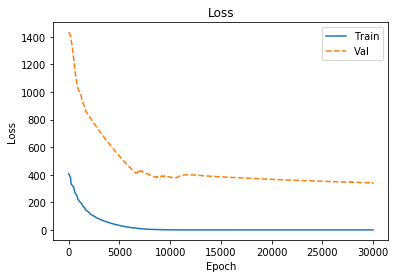

Loss on train dataset: 0.22593747485767712
Loss on validation dataset: 341.0948669860413

Metrics for Classifying Upward Movements
Accuracy on train dataset: 1.0
Accuracy on validation dataset: 1.0


In [7]:
# Reporting Data
print('Learning Curves for Metrics:')
plot_print_metrics(m_history, metrics_train=metrics_train, metrics_val=metrics_val, metrics_names=m.metrics_names)
print()
print('Metrics for Classifying Upward Movements')
print('Accuracy on train dataset: {}'.format(up_cls_acc_train))
print('Accuracy on validation dataset: {}'.format(up_cls_acc_val))